# Orbital Anomaly Detection using Two-Line Element (TLE) Data

## 1. Introduction & Problem Statement
Orbital debris and the increasing complexity of space operations necessitate robust, autonomous methods for monitoring Resident Space Objects (RSOs). This project focuses on developing a Machine Learning (ML) framework for detecting orbital anomalies (such as maneuvers or re-evaluations) using two-line element (TLE) data.

The project utilizes TLE data for diverse orbital regimes:
- **ISS (Low Earth Orbit, LEO):** A known maneuvering satellite.
- **ASTRA 2F (Geostationary Orbit, GEO):** Known for stable-drift behavior.
- **ARIANE 5 DEB and SL-8 DEB (Debris):** Representing less stable, unpropelled objects.

### Objectives
1. **Data Exploration:** Analyze raw TLE parameters and their statistical distributions.
2. **Feature Engineering:** Transform raw parameters into physically meaningful features (e.g., Orbital Energy).
3. **Baseline Comparison:** Establish a simple statistical baseline for anomaly detection.
4. **Unsupervised Learning:** Implement Isolation Forest and DBSCAN to detect anomalies without prior labels.
5. **Active Learning (Advanced):** Improve the model using a semi-supervised feedback loop.

In [1]:
# ==============================================================================
# 📦 GLOBAL IMPORTS
# ==============================================================================

# 1. Standard Library & Core Data Science
# ------------------------------------------------------------------------------
import io
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
from scipy.stats import uniform, loguniform
import warnings

# 2. Visualization
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, Markdown

# 3. Scikit-Learn: Preprocessing & Feature Engineering
# ------------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# 4. Scikit-Learn: Models (Unsupervised & Anomaly Detection)
# ------------------------------------------------------------------------------
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

# 5. Scikit-Learn: Model Selection & Inspection
# ------------------------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from sklearn.inspection import permutation_importance

# 6. Scikit-Learn: Metrics & Evaluation
# ------------------------------------------------------------------------------
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    precision_recall_curve,
    auc,
    average_precision_score
)

# ==============================================================================
# ⚙️ CONFIGURATION (Optional)
# ==============================================================================
# Set pandas options for better display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Suppress warnings that clutter the notebook
warnings.filterwarnings('ignore')

In [2]:
csv_files = [
    "ISS(ZARYA)_25544_data.csv",
    "ASTRA 2F_38778_data.csv",
    "ARIANE 5 DEB (SYLDA)_44336_data.csv",
    "SL-8 DEB_4084_data.csv"
]
dataframes = {}
for file_name in csv_files:
    filepath = "DATASET/"+file_name
    df_name=file_name.replace(".csv","")
    dataframes[df_name] = pd.read_csv(filepath)
    print(f"{df_name} (Shape: {dataframes[df_name].shape})")

ISS(ZARYA)_25544_data (Shape: (4540, 32))
ASTRA 2F_38778_data (Shape: (1677, 32))
ARIANE 5 DEB (SYLDA)_44336_data (Shape: (1768, 32))
SL-8 DEB_4084_data (Shape: (1383, 32))


In [3]:
def generate_orbital_report(df):
    stats = df.describe()
    report = ""

    # 1. Orbital Stability Section
    # Columns expected to be stable (low standard deviation)
    stable_cols = ['INCLINATION', 'SEMIMAJOR_AXIS', 'PERIOD', 'MEAN_MOTION']
    report += "### Orbital Stability\n"
    
    for col in stable_cols:
        if col in stats.columns:
            std_val = stats.loc['std', col]
            report += f"- **{col}**: Very stable with a standard deviation of **{std_val:.6f}**.\n"

    # 2. Variability Section
    # Columns expected to vary (high standard deviation) due to physics
    var_cols = {
        'RA_OF_ASC_NODE': "likely due to orbital precession",
        'ARG_OF_PERICENTER': "indicating significant variations in the argument of perigee",
        'MEAN_ANOMALY': "indicating significant variations in the mean anomaly"
    }
    report += "\n### Variability in Certain Columns\n"
    
    for col, explanation in var_cols.items():
        if col in stats.columns:
            std_val = stats.loc['std', col]
            report += f"- **{col}**: High variability with a standard deviation of **{std_val:.6f}**, {explanation}.\n"

    # 3. Eccentricity Section
    if 'ECCENTRICITY' in stats.columns:
        mean_ecc = stats.loc['mean', 'ECCENTRICITY']
        std_ecc = stats.loc['std', 'ECCENTRICITY']
        
        # Determine orbit shape description
        shape_desc = "nearly circular" if mean_ecc < 0.01 else "elliptical"
        
        report += "\n### Low Eccentricity\n"
        report += f"- **ECCENTRICITY**: Very low on average (**{mean_ecc:.6f}**) with a standard deviation of **{std_ecc:.6f}**, indicating a {shape_desc} orbit.\n"

    # 4. Drag Coefficient (BSTAR) Section
    if 'BSTAR' in stats.columns:
        mean_bstar = stats.loc['mean', 'BSTAR']
        std_bstar = stats.loc['std', 'BSTAR']
        
        report += "\n### Drag Coefficient (BSTAR)\n"
        report += f"- **BSTAR**: Average of **{mean_bstar:.6f}** with a standard deviation of **{std_bstar:.6f}**. This may indicate variations in atmospheric drag or solar radiation pressure.\n"

    return report

# Usage loop
for name, df in dataframes.items():
    display(Markdown(f"## Analysis for {name.upper()}"))
    
    # Generate the text report
    md_content = generate_orbital_report(df)
    
    # Render the Markdown
    display(Markdown(md_content))
    
    # Separator
    display(Markdown("---"))

## Analysis for ISS(ZARYA)_25544_DATA

### Orbital Stability
- **INCLINATION**: Very stable with a standard deviation of **0.002056**.
- **SEMIMAJOR_AXIS**: Very stable with a standard deviation of **1.547024**.
- **PERIOD**: Very stable with a standard deviation of **0.031734**.
- **MEAN_MOTION**: Very stable with a standard deviation of **0.005294**.

### Variability in Certain Columns
- **RA_OF_ASC_NODE**: High variability with a standard deviation of **105.642251**, likely due to orbital precession.
- **ARG_OF_PERICENTER**: High variability with a standard deviation of **116.356581**, indicating significant variations in the argument of perigee.
- **MEAN_ANOMALY**: High variability with a standard deviation of **108.566872**, indicating significant variations in the mean anomaly.

### Low Eccentricity
- **ECCENTRICITY**: Very low on average (**0.000538**) with a standard deviation of **0.000271**, indicating a nearly circular orbit.

### Drag Coefficient (BSTAR)
- **BSTAR**: Average of **0.000290** with a standard deviation of **0.002100**. This may indicate variations in atmospheric drag or solar radiation pressure.


---

## Analysis for ASTRA 2F_38778_DATA

### Orbital Stability
- **INCLINATION**: Very stable with a standard deviation of **0.019815**.
- **SEMIMAJOR_AXIS**: Very stable with a standard deviation of **0.613708**.
- **PERIOD**: Very stable with a standard deviation of **0.031355**.
- **MEAN_MOTION**: Very stable with a standard deviation of **0.000022**.

### Variability in Certain Columns
- **RA_OF_ASC_NODE**: High variability with a standard deviation of **8.688684**, likely due to orbital precession.
- **ARG_OF_PERICENTER**: High variability with a standard deviation of **144.510482**, indicating significant variations in the argument of perigee.
- **MEAN_ANOMALY**: High variability with a standard deviation of **102.384626**, indicating significant variations in the mean anomaly.

### Low Eccentricity
- **ECCENTRICITY**: Very low on average (**0.000300**) with a standard deviation of **0.000136**, indicating a nearly circular orbit.

### Drag Coefficient (BSTAR)
- **BSTAR**: Average of **0.000000** with a standard deviation of **0.000000**. This may indicate variations in atmospheric drag or solar radiation pressure.


---

## Analysis for ARIANE 5 DEB (SYLDA)_44336_DATA

### Orbital Stability
- **INCLINATION**: Very stable with a standard deviation of **0.093529**.
- **SEMIMAJOR_AXIS**: Very stable with a standard deviation of **1662.318261**.
- **PERIOD**: Very stable with a standard deviation of **54.676155**.
- **MEAN_MOTION**: Very stable with a standard deviation of **0.551316**.

### Variability in Certain Columns
- **RA_OF_ASC_NODE**: High variability with a standard deviation of **100.012102**, likely due to orbital precession.
- **ARG_OF_PERICENTER**: High variability with a standard deviation of **107.834137**, indicating significant variations in the argument of perigee.
- **MEAN_ANOMALY**: High variability with a standard deviation of **146.170547**, indicating significant variations in the mean anomaly.

### Low Eccentricity
- **ECCENTRICITY**: Very low on average (**0.631013**) with a standard deviation of **0.035344**, indicating a elliptical orbit.

### Drag Coefficient (BSTAR)
- **BSTAR**: Average of **0.011322** with a standard deviation of **0.002814**. This may indicate variations in atmospheric drag or solar radiation pressure.


---

## Analysis for SL-8 DEB_4084_DATA

### Orbital Stability
- **INCLINATION**: Very stable with a standard deviation of **0.001309**.
- **SEMIMAJOR_AXIS**: Very stable with a standard deviation of **0.479588**.
- **PERIOD**: Very stable with a standard deviation of **0.010062**.
- **MEAN_MOTION**: Very stable with a standard deviation of **0.001463**.

### Variability in Certain Columns
- **RA_OF_ASC_NODE**: High variability with a standard deviation of **108.478470**, likely due to orbital precession.
- **ARG_OF_PERICENTER**: High variability with a standard deviation of **105.191911**, indicating significant variations in the argument of perigee.
- **MEAN_ANOMALY**: High variability with a standard deviation of **105.323337**, indicating significant variations in the mean anomaly.

### Low Eccentricity
- **ECCENTRICITY**: Very low on average (**0.002190**) with a standard deviation of **0.000085**, indicating a nearly circular orbit.

### Drag Coefficient (BSTAR)
- **BSTAR**: Average of **0.000104** with a standard deviation of **0.000053**. This may indicate variations in atmospheric drag or solar radiation pressure.


---

## Cleaning constants

In [4]:
drop_summary = []

for name, df in dataframes.items():
    # Identify constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() == 1 and (col not in ['NORAD_CAT_ID', 'OBJECT_NAME', 'OBJECT_TYPE'])]
    
    if constant_cols:
        # Store information before dropping
        drop_summary.append({
            'DataFrame': name,
            'Dropped Count': len(constant_cols),
            'Dropped Columns': ", ".join(constant_cols)
        })
        
        # Perform the drop
        df.drop(columns=constant_cols, inplace=True)

# Create a summary DataFrame
if drop_summary:
    df_report = pd.DataFrame(drop_summary)
    
    # Display the report styled for readability
    display(df_report.style.set_properties(subset=['Dropped Columns'], **{'text-align': 'left', 'white-space': 'pre-wrap'}))
else:
    print("No constant columns found in any DataFrame.")

## Dropping Useless columns  (Metadata)

In [5]:
# Define the list of columns to target
target_cols = ['REV_AT_EPOCH', 'FILE', 'TLE_LINE1', 'TLE_LINE2']
drop_log = []

for name, df in dataframes.items():
    # Identify columns that exist in this dataframe
    cols_to_drop = [col for col in target_cols if col in df.columns]
    
    if cols_to_drop:
        # Log the action
        drop_log.append({
            'DataFrame': name,
            'Dropped Columns': ", ".join(cols_to_drop),
            'Count': len(cols_to_drop),
        })
        
        # Perform the drop
        df.drop(columns=cols_to_drop, inplace=True)

# Display the summary if any columns were dropped
if drop_log:
    summary_df = pd.DataFrame(drop_log)
    display(summary_df.style.set_caption("Cleaned Columns Report"))
else:
    print("No specified columns were found to drop.")

## Conversion of Epoch in DateTime

In [6]:
conversion_log = []

for name, df in dataframes.items():
    if 'EPOCH' in df.columns:
        # Convert to datetime
        df['EPOCH'] = pd.to_datetime(df['EPOCH'])
        
        # Log statistics to verify the conversion worked correctly
        conversion_log.append({
            'DataFrame': name,
            'Dtype': df['EPOCH'].dtype,
            'Start Date': df['EPOCH'].min(),
            'End Date': df['EPOCH'].max(),
            'NaT Count': df['EPOCH'].isnull().sum() # Check for failed conversions
        })

# Display summary
if conversion_log:
    summary_df = pd.DataFrame(conversion_log)
    display(summary_df.style.format({
        'Start Date': '{:%Y-%m-%d %H:%M}', 
        'End Date': '{:%Y-%m-%d %H:%M}'
    }))
else:
    print("Column 'EPOCH' not found in any DataFrame.")

## Merge Dataset

In [7]:
df_iss = dataframes["ISS(ZARYA)_25544_data"].copy()
df_astra_2f = dataframes["ASTRA 2F_38778_data"].copy()
df_ariane_5_deb = dataframes["ARIANE 5 DEB (SYLDA)_44336_data"].copy()
df_sl8_deb = dataframes["SL-8 DEB_4084_data"].copy()

df_combined = pd.concat([df_iss, df_astra_2f], ignore_index=True)
df_combined.head()

NORAD_CAT_ID  OBJECT_NAME OBJECT_TYPE               EPOCH  EPOCH_MICROSECONDS  MEAN_MOTION  ECCENTRICITY  INCLINATION  RA_OF_ASC_NODE  ARG_OF_PERICENTER  MEAN_ANOMALY     BSTAR  MEAN_MOTION_DOT  SEMIMAJOR_AXIS  PERIOD   APOGEE  PERIGEE
0         25544  ISS (ZARYA)     PAYLOAD 2023-01-01 06:28:40              541088    15.498110      0.000520      51.6448         75.3411           209.5406      257.0907  0.000289         0.000160        6795.415  92.915  420.817  413.744
1         25544  ISS (ZARYA)     PAYLOAD 2023-01-01 12:46:48              697248    15.498233      0.000521      51.6444         74.0407           211.7305      280.9843  0.000302         0.000167        6795.379  92.914  420.786  413.703
2         25544  ISS (ZARYA)     PAYLOAD 2023-01-01 17:28:45              194304    15.498321      0.000515      51.6445         73.0716           212.0396      293.8042  0.000310         0.000172        6795.354  92.913  420.721  413.717
3         25544  ISS (ZARYA)     PAYLOAD 2023-01-02 00:52:04              330272    15.498430      0.000516      51.6446         71.5466           213.3191      211.3400  0.000310         0.000172        6795.322  92.913  420.696  413.678
4         25544  ISS (ZARYA)     PAYLOAD 2023-01-02 05:40:34              178880    15.498507      0.000513      51.6447         70.5542           214.4037      248.8124  0.000313         0.000173        6795.299  92.912  420.650  413.679

# Correlation between variables

In [8]:
def matrice_corr_comparative(df_combined, features):
    objects = df_combined['OBJECT_NAME'].unique()
    n_objects = len(objects)

    n_cols = 2
    n_rows = (n_objects + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 9, n_rows * 8))
    axes = axes.flatten()

    for i, obj_name in enumerate(objects):
        ax = axes[i]

        df_obj = df_combined[df_combined['OBJECT_NAME'] == obj_name]

        corr_matrix = df_obj[features].corr()

        sns.heatmap(
            corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='vlag',
            vmin=-1, vmax=1,
            ax=ax,
            linewidths=.5,
            annot_kws={"size": 8}
        )

        ax.set_title(f'Correlation matrix - {obj_name}', fontsize=14)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()

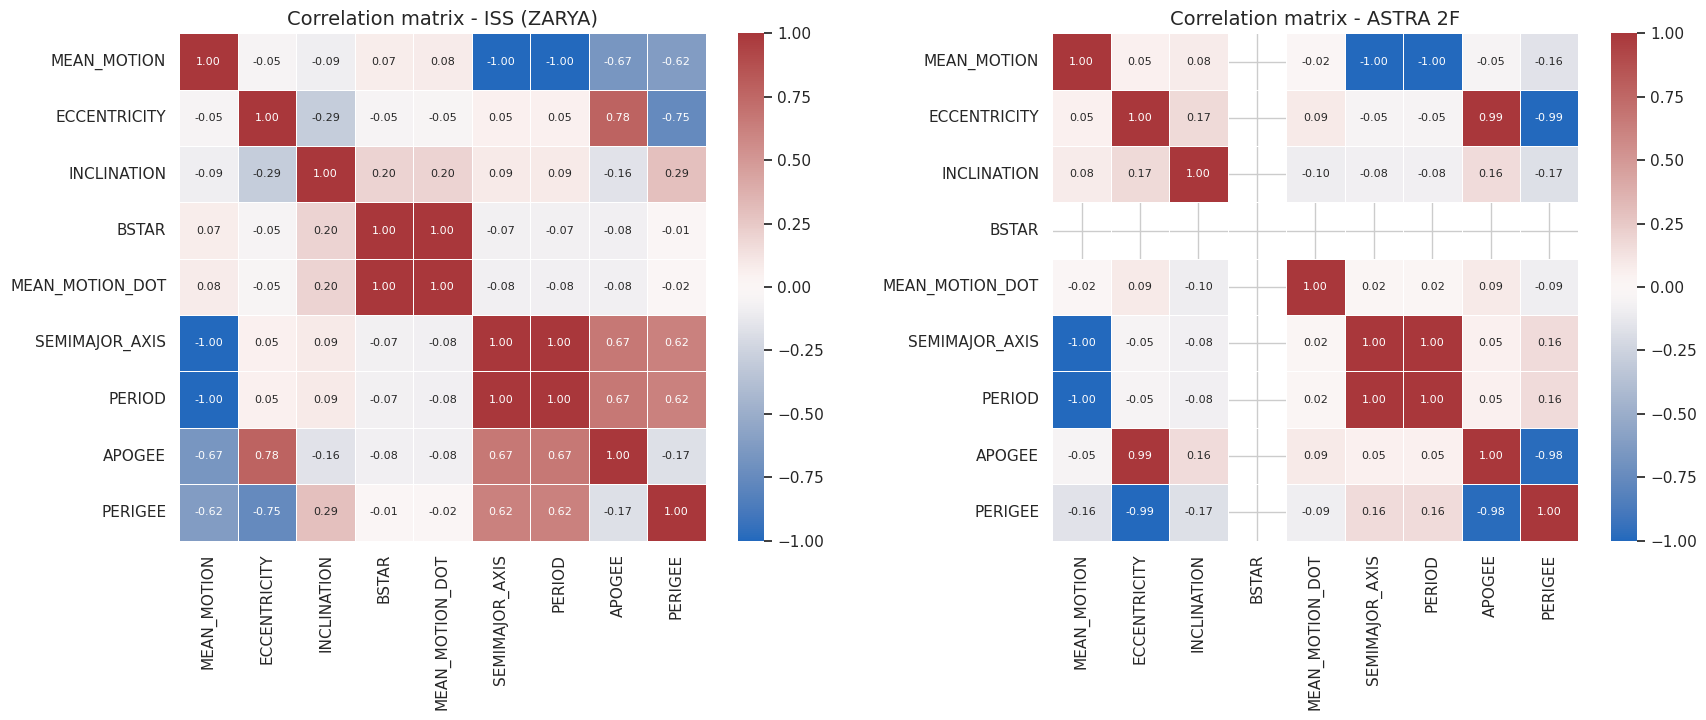

In [9]:
key_cols = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR',
            'MEAN_MOTION_DOT', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOGEE', 'PERIGEE']
matrice_corr_comparative(df_combined, key_cols)

# Physical Relationships Between Orbital Variables

---

### **Period – Semimajor Axis (Kepler's Third Law)**
$$
T = 2\pi \sqrt{\frac{a^3}{\mu}}
$$
- $ T $: Orbital period (**PERIOD**)
- $ a $: Semimajor axis (**SEMIMAJOR_AXIS**)
- $ \mu = GM $: Standard gravitational parameter of the central body (Earth for satellites)

---

### **Mean Motion – Semimajor Axis**
$$
n = \sqrt{\frac{\mu}{a^3}}
$$
- $ n $: Mean motion (**MEAN_MOTION**), or the number of orbits per unit time

---

### **Period – Mean Motion**
$$
T = \frac{2\pi}{n}
$$

---

### **Apogee, Perigee, Semimajor Axis, and Eccentricity**
$$
\begin{align*}
r_{\text{apogee}} &= a(1 + e) \\
r_{\text{perigee}} &= a(1 - e)
\end{align*}
$$
- $ e $: Eccentricity (**ECCENTRICITY**)
- $ r_{\text{apogee}} $: Apogee distance (**APOGEE**)
- $ r_{\text{perigee}} $: Perigee distance (**PERIGEE**)

---

### **Mean Motion Variation ($\dot{n}$), Drag (BSTAR), and Altitude Decay**
- $\dot{n}$ (**MEAN_MOTION_DOT**) and **BSTAR** (drag coefficient) describe the rate of orbital decay due to atmospheric drag, affecting the semimajor axis and thus the period over time:
$$
\frac{da}{dt} \sim -\frac{2a^2}{n\mu} F_D
$$
- The drag force $ F_D $ is modeled using **BSTAR**.

---

# 2. Orbital Trajectories Visualization Over Time

In [10]:
def plot_traj_orbitale_comparative(df_combined, feature):

    print(f"Displaying evolution of: {feature}")

    g = sns.relplot(
        data=df_combined,
        x='EPOCH',
        y=feature,
        hue='OBJECT_NAME',
        col='OBJECT_NAME',
        col_wrap=2,
        kind='line',
        height=4,
        aspect=2,
        palette='tab10',
        lw=1,
        facet_kws={'sharey': False, 'sharex': True}
    )

    g.fig.suptitle(f'Temporal evolution of {feature} (by Object)', y=1.03, fontsize=16)
    g.set_axis_labels('Date (EPOCH)', feature)

    plt.show()

In [11]:
metrics = ["APOGEE", "PERIGEE", "MEAN_MOTION", "ECCENTRICITY"]

# Create an Output widget for each metric to capture the plot
outputs = [widgets.Output() for _ in metrics]

# Generate plots inside the corresponding Output widget
for metric, out in zip(metrics, outputs):
    with out:
        # The function output is captured here instead of being printed globally
        plot_traj_orbitale_comparative(df_combined, metric)

# Create the Tab widget
tabs = widgets.Tab(children=outputs)

# Set titles for each tab
for i, metric in enumerate(metrics):
    tabs.set_title(i, metric.replace('_', ' ').title())

# Display the interactive tabs
display(tabs)

## 3. Data Quality: The Histogram of Temporal Gaps

In [12]:
def analyze_time_gaps_interactive(df_combined):
    objects = df_combined['OBJECT_NAME'].unique()
    
    # Create a list to hold the Output widgets (tabs)
    tab_outputs = []
    
    for obj_name in objects:
        out = widgets.Output()
        
        with out:
            # 1. Data Preparation
            df_obj = df_combined[df_combined['OBJECT_NAME'] == obj_name].copy()
            df_obj = df_obj.sort_values('EPOCH').reset_index(drop=True)
            
            # Calculate gaps in hours
            time_diffs_hours = df_obj['EPOCH'].diff().dt.total_seconds() / 3600
            clean_time_diffs = time_diffs_hours.dropna()
            clean_time_diffs = clean_time_diffs[clean_time_diffs > 0]
            aligned_dates = df_obj['EPOCH'][clean_time_diffs.index]
            
            if len(clean_time_diffs) == 0:
                print("Insufficient data for analysis.")
                tab_outputs.append(out)
                continue

            # 2. Statistics Display (as a DataFrame instead of print statements)
            stats = pd.DataFrame({
                'Metric': ['Average Gap', 'Median Gap', 'Min Gap', 'Max Gap', 'Std Dev', 'Count'],
                'Value': [
                    f"{clean_time_diffs.mean():.2f} h",
                    f"{clean_time_diffs.median():.2f} h",
                    f"{clean_time_diffs.min():.2f} h",
                    f"{clean_time_diffs.max():.2f} h",
                    f"{clean_time_diffs.std():.2f} h",
                    f"{len(clean_time_diffs)}"
                ]
            }).set_index('Metric')
            
            # Display stats nicely
            display(stats.T.style.set_caption(f"Statistics for {obj_name}"))
            
            # 3. Visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Histogram
            ax1.hist(clean_time_diffs, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
            ax1.set_xlabel('Time Gap (hours)')
            ax1.set_ylabel('Frequency')
            ax1.set_title('Distribution of Time Gaps')
            ax1.set_xscale('log')
            ax1.axvline(clean_time_diffs.mean(), color='red', linestyle='--', label='Mean')
            ax1.axvline(clean_time_diffs.median(), color='green', linestyle='--', label='Median')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Scatter (Temporal Evolution)
            ax2.scatter(aligned_dates, clean_time_diffs, alpha=0.5, s=10, color='darkblue')
            ax2.set_xlabel('Date')
            ax2.set_ylabel('Time Gap (hours)')
            ax2.set_title('Temporal Evolution of Gaps')
            ax2.set_yscale('log')
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        tab_outputs.append(out)

    # Create the Tab widget
    tabs = widgets.Tab(children=tab_outputs)
    for i, obj_name in enumerate(objects):
        tabs.set_title(i, obj_name)
        
    display(tabs)

# Usage
analyze_time_gaps_interactive(df_combined)

## 4. Distributions (KDE)

In [13]:
def kde_distrib_comparative(df_combined, feature):
    print(f"--- Distribution analysis: {feature} ---")

    g = sns.displot(
        data=df_combined,
        x=feature,
        col="OBJECT_NAME",
        col_wrap=3,
        kind="kde",
        fill=True,
        rug=False,
        height=4,
        aspect=1.5,
        facet_kws={'sharex': False, 'sharey': False}
    )

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f'Comparative distribution of: {feature}', fontsize=16)

    for ax in g.axes.flat:
        # Bug with groupby which order is not guaranteed
        title = ax.get_title()
        obj_name = title.split('=')[-1].strip()
        sub_df = df_combined[df_combined["OBJECT_NAME"] == obj_name]
        mean_val = sub_df[feature].mean()
        std_val = sub_df[feature].std()
        ax.text(0.95, 0.95, f'μ={mean_val:.6f}\nσ={std_val:.6f}',
                transform=ax.transAxes, ha='right', va='top', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.show()

In [14]:
# List of metrics to plot
metrics = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION']

# Create an Output widget for each metric
outputs = [widgets.Output() for _ in metrics]

# Generate plots inside the corresponding Output widget
for metric, out in zip(metrics, outputs):
    with out:
        # Capture the plot output
        kde_distrib_comparative(df_combined, metric)

# Create the Tab widget
tabs = widgets.Tab(children=outputs)

# Set titles for each tab (formatting the string for better readability)
for i, metric in enumerate(metrics):
    tabs.set_title(i, metric.replace('_', ' ').title())

# Display the interactive tabs
display(tabs)

## 5. Scatter Plots

In [15]:
def scatter_plot_comparative(df_combined, feature1, feature2):
    g = sns.relplot(
        data=df_combined,
        x=feature1,
        y=feature2,
        hue='OBJECT_NAME',
        col='OBJECT_NAME',
        col_wrap=2,
        palette='tab10',
        alpha=0.6,
        facet_kws={'sharey': False, 'sharex': False}
    )
    g.fig.suptitle(f'{feature1} vs {feature2} (by Objet)', y=1.03, fontsize=16)

    plt.show()

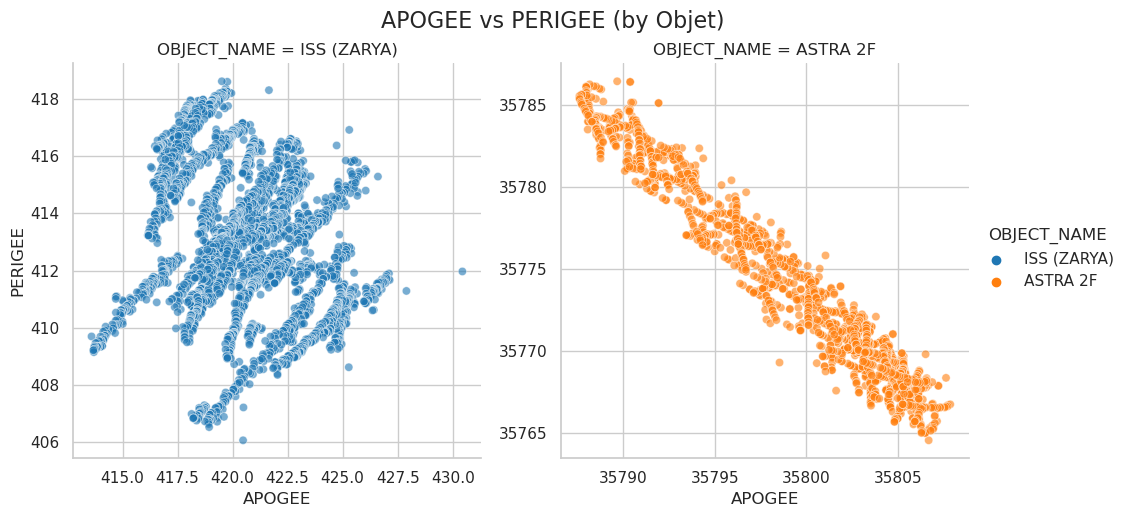

In [16]:
scatter_plot_comparative(df_combined, 'APOGEE', 'PERIGEE')

# 6. Polar Chart

In [17]:
def plot_polar_raan_comparative_with_epoch(df_combined):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='polar')

    objects = df_combined['OBJECT_NAME'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(objects)))

    for i, obj in enumerate(objects):
        df_obj = df_combined[df_combined['OBJECT_NAME'] == obj]

        theta = np.deg2rad(df_obj['RA_OF_ASC_NODE'])

        epoch_numeric = df_obj['EPOCH'].astype(np.int64)

        min_epoch = epoch_numeric.min()
        max_epoch = epoch_numeric.max()

        if max_epoch == min_epoch:
             r = np.full_like(theta, 1.0)
        else:
             r = 0.2 + 0.8 * (epoch_numeric - min_epoch) / (max_epoch - min_epoch)

        ax.scatter(theta, r, label=obj, s=10, alpha=0.7, color=colors[i])

    ax.set_title("Orbital Precession: RAAN vs. Time (Epoch)", va='bottom', fontsize=16)

    ax.set_rticks([0.2, 0.6, 1.0])
    ax.set_rlabel_position(22.5)
    ax.set_rlim(0, 1.1)

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    plt.legend(bbox_to_anchor=(1.1, 1.1))
    plt.show()

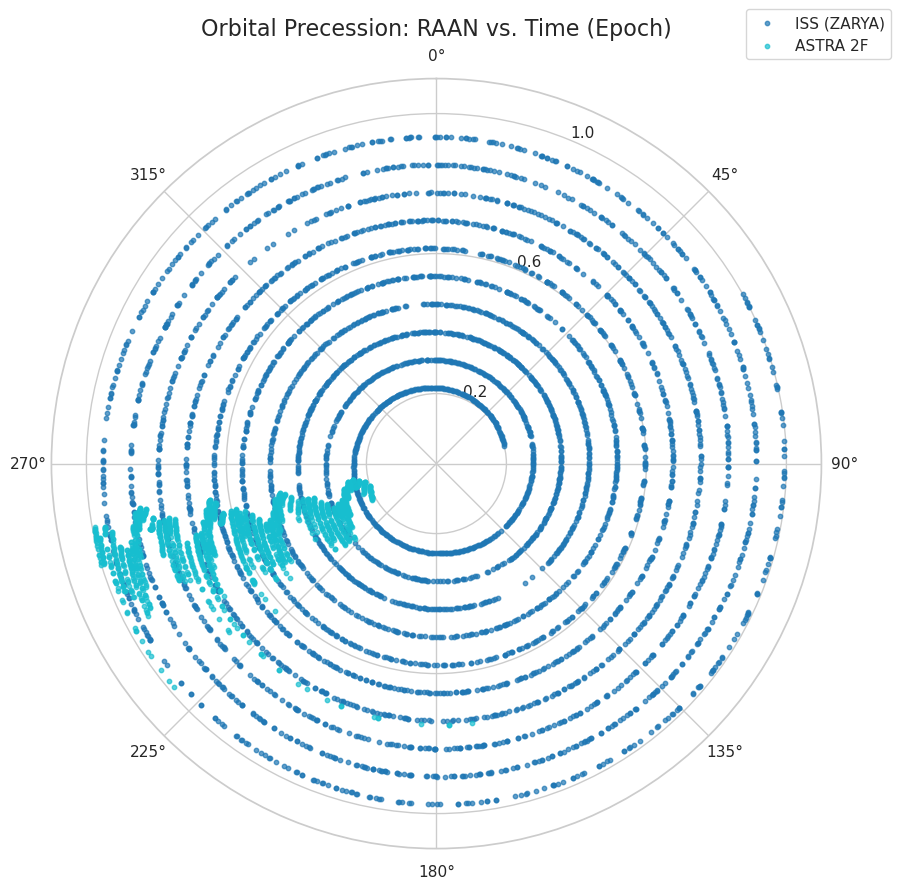

In [18]:
plot_polar_raan_comparative_with_epoch(df_combined)

# 7. Feature Engineering

In [19]:
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

def compute_temporal_features(df):
    """Calculates temporal variations of orbital parameters."""
    df = df.copy()
    df = df.sort_values('EPOCH').reset_index(drop=True)

    # Calculate time deltas (in hours)
    df['TIME_DELTA'] = df['EPOCH'].diff().dt.total_seconds() / 3600

    # Features for temporal derivation
    orbital_params = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION',
                      'SEMIMAJOR_AXIS', 'APOGEE', 'PERIGEE']

    for param in orbital_params:
        # Rate of change (first derivative)
        df[f'{param}_RATE'] = df[param].diff() / df['TIME_DELTA']

        # Acceleration (second derivative)
        df[f'{param}_ACCEL'] = df[f'{param}_RATE'].diff() / df['TIME_DELTA']

        # Moving averages (10-observation window)
        df[f'{param}_MA10'] = df[param].rolling(window=10, min_periods=1).mean()

        # Deviation from moving average
        df[f'{param}_DEV_MA'] = df[param] - df[f'{param}_MA10']

    return df

def compute_orbital_energy(df):
    """Calculates specific orbital energy."""
    df = df.copy()
    # E = -μ / (2a) where μ = 398600.4418 km³/s² (Earth's gravitational constant)
    mu = 398600.4418
    df['ORBITAL_ENERGY'] = -mu / (2 * df['SEMIMAJOR_AXIS'])
    df['ENERGY_RATE'] = df['ORBITAL_ENERGY'].diff() / df['TIME_DELTA']
    return df

def compute_angular_features(df):
    """Processes angles using circular statistics."""
    df = df.copy()
    angular_params = ['RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY']

    for param in angular_params:
        # Conversion to Cartesian coordinates
        rad = np.deg2rad(df[param])
        df[f'{param}_SIN'] = np.sin(rad)
        df[f'{param}_COS'] = np.cos(rad)

        # Angular rate of change
        diff_angle = df[param].diff()
        # Correction for 0°/360° discontinuity (phase wrap)
        diff_angle = np.where(diff_angle > 180, diff_angle - 360, diff_angle)
        diff_angle = np.where(diff_angle < -180, diff_angle + 360, diff_angle)
        df[f'{param}_ANGULAR_RATE'] = diff_angle / df['TIME_DELTA']

    return df

def compute_orbit_shape_features(df):
    """Calculates orbital shape indicators."""
    
    df = df.copy()

    # Focal distance
    df['FOCAL_DISTANCE'] = df['SEMIMAJOR_AXIS'] * df['ECCENTRICITY']

    # Approximate orbital perimeter (Ramanujan's formula)
    a = df['SEMIMAJOR_AXIS']
    b = a * np.sqrt(1 - df['ECCENTRICITY']**2)
    h = ((a - b)**2) / ((a + b)**2)
    df['ORBIT_PERIMETER'] = np.pi * (a + b) * (1 + (3*h) / (10 + np.sqrt(4 - 3*h)))

    # Circularity
    df['CIRCULARITY'] = 1 - df['ECCENTRICITY']

    return df

def compute_drag_indicators(df):
    """Calculates indicators related to atmospheric drag."""
    df = df.copy()
    df['BSTAR_RATE'] = df['BSTAR'].diff() / df['TIME_DELTA']
    df['ALTITUDE_DECAY'] = -df['SEMIMAJOR_AXIS_RATE']
    return df

def compute_statistical_features(df, window=20):
    """Calculates rolling statistics."""
    df = df.copy()
    key_params = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION']

    for param in key_params:
        df[f'{param}_STD{window}'] = df[param].rolling(window=window, min_periods=1).std()
        df[f'{param}_MIN{window}'] = df[param].rolling(window=window, min_periods=1).min()
        df[f'{param}_MAX{window}'] = df[param].rolling(window=window, min_periods=1).max()
        df[f'{param}_RANGE{window}'] = df[f'{param}_MAX{window}'] - df[f'{param}_MIN{window}']

    return df

# Application of feature engineering on ISS
print("\nApplying to ISS (ZARYA)")
df_iss_enriched = df_iss.copy()
df_iss_enriched = compute_temporal_features(df_iss_enriched)
print(" - Temporal features created")
df_iss_enriched = compute_orbital_energy(df_iss_enriched)
print(" - Orbital energy calculated")
df_iss_enriched = compute_angular_features(df_iss_enriched)
print(" - Angular features processed")
df_iss_enriched = compute_orbit_shape_features(df_iss_enriched)
print(" - Orbital shape features created")
df_iss_enriched = compute_drag_indicators(df_iss_enriched)
print(" - Drag indicators calculated")
df_iss_enriched = compute_statistical_features(df_iss_enriched)
print(" - Rolling statistical features created")

# Removing NaNs
initial_rows = len(df_iss_enriched)
df_iss_enriched = df_iss_enriched.dropna().reset_index(drop=True)
removed_rows = initial_rows - len(df_iss_enriched)
print(f"\nFinal Dataset: {df_iss_enriched.shape[0]} rows x {df_iss_enriched.shape[1]} columns")
print(f" ({removed_rows} rows with NaN removed)")

FEATURE ENGINEERING

Applying to ISS (ZARYA)
 - Temporal features created
 - Orbital energy calculated
 - Angular features processed
 - Orbital shape features created
 - Drag indicators calculated
 - Rolling statistical features created

Final Dataset: 4094 rows x 70 columns
 (446 rows with NaN removed)


In [20]:
df_iss_enriched.head()

NORAD_CAT_ID  OBJECT_NAME OBJECT_TYPE               EPOCH  EPOCH_MICROSECONDS  MEAN_MOTION  ECCENTRICITY  INCLINATION  RA_OF_ASC_NODE  ARG_OF_PERICENTER  MEAN_ANOMALY     BSTAR  MEAN_MOTION_DOT  SEMIMAJOR_AXIS  PERIOD   APOGEE  PERIGEE  TIME_DELTA  MEAN_MOTION_RATE  MEAN_MOTION_ACCEL  MEAN_MOTION_MA10  MEAN_MOTION_DEV_MA  ECCENTRICITY_RATE  ECCENTRICITY_ACCEL  ECCENTRICITY_MA10  ECCENTRICITY_DEV_MA  INCLINATION_RATE  INCLINATION_ACCEL  INCLINATION_MA10  INCLINATION_DEV_MA  SEMIMAJOR_AXIS_RATE  SEMIMAJOR_AXIS_ACCEL  SEMIMAJOR_AXIS_MA10  SEMIMAJOR_AXIS_DEV_MA  APOGEE_RATE  APOGEE_ACCEL  APOGEE_MA10  APOGEE_DEV_MA  PERIGEE_RATE  PERIGEE_ACCEL  PERIGEE_MA10  PERIGEE_DEV_MA  ORBITAL_ENERGY  ENERGY_RATE  RA_OF_ASC_NODE_SIN  RA_OF_ASC_NODE_COS  RA_OF_ASC_NODE_ANGULAR_RATE  ARG_OF_PERICENTER_SIN  ARG_OF_PERICENTER_COS  ARG_OF_PERICENTER_ANGULAR_RATE  MEAN_ANOMALY_SIN  MEAN_ANOMALY_COS  MEAN_ANOMALY_ANGULAR_RATE  FOCAL_DISTANCE  ORBIT_PERIMETER  CIRCULARITY    BSTAR_RATE  ALTITUDE_DECAY  \
0         25544  ISS (ZARYA)     PAYLOAD 2023-01-01 17:28:45              194304    15.498321      0.000515      51.6445         73.0716           212.0396      293.8042  0.000310         0.000172        6795.354  92.913  420.721  413.717    4.699167          0.000019      -1.774767e-07         15.498221            0.000099      -1.234261e-06       -2.862919e-07           0.000519            -0.000004          0.000021           0.000018         51.644567           -0.000067            -0.005320              0.000083          6795.382667              -0.028667    -0.013832     -0.001897   420.774667      -0.053667      0.002979       0.002018    413.721333       -0.004333      -29.328895    -0.000023            0.956669            0.291176                    -0.206228              -0.530505              -0.847682                        0.065778         -0.914930          0.403612                   2.728122        3.501646     42696.465576     0.999485  1.706686e-06        0.005320   
1         25544  ISS (ZARYA)     PAYLOAD 2023-01-02 00:52:04              330272    15.498430      0.000516      51.6446         71.5466           213.3191      211.3400  0.000310         0.000172        6795.322  92.913  420.696  413.678    7.388611          0.000015      -5.310324e-07         15.498273            0.000156       1.488778e-07        1.871988e-07           0.000518            -0.000002          0.000014          -0.000001         51.644575            0.000025            -0.004331              0.000134          6795.367500              -0.045500    -0.003384      0.001414   420.755000      -0.059000     -0.005278      -0.001118    413.710500       -0.032500      -29.329033    -0.000019            0.948581            0.316533                    -0.206399              -0.549301              -0.835624                        0.173172         -0.520116         -0.854096                 -11.160988        3.509104     42696.264502     0.999484  3.112899e-08        0.004331   
2         25544  ISS (ZARYA)     PAYLOAD 2023-01-02 05:40:34              178880    15.498507      0.000513      51.6447         70.5542           214.4037      248.8124  0.000313         0.000173        6795.299  92.912  420.650  413.679    4.808333          0.000016       2.863098e-07         15.498320            0.000187      -7.279029e-07       -1.823461e-07           0.000517            -0.000004          0.000021           0.000002         51.644600            0.000100            -0.004783             -0.000094          6795.353800              -0.054800    -0.009567     -0.001286   420.734000      -0.084000      0.000208       0.001141    413.704200       -0.025200      -29.329132    -0.000021            0.942957            0.332915                    -0.206392              -0.565020              -0.825077                        0.225567         -0.932402         -0.361423                   7.793220        3.485309     42696.120027     0.999487  5.615251e-07        0.004783   
3      

In [21]:
# Ensure 'EPOCH' is datetime
if not pd.api.types.is_datetime64_any_dtype(df_iss_enriched['EPOCH']):
    df_iss_enriched['EPOCH'] = pd.to_datetime(df_iss_enriched['EPOCH'])

# Define masks
train_mask = (df_iss_enriched['EPOCH'] >= '2023-01-01') & (df_iss_enriched['EPOCH'] <= '2023-10-31')
val_mask   = (df_iss_enriched['EPOCH'] >= '2023-11-01') & (df_iss_enriched['EPOCH'] <= '2023-12-31')
test_mask  = (df_iss_enriched['EPOCH'] >= '2024-01-01')

# Create DataFrames
df_train = df_iss_enriched[train_mask].copy()
df_val   = df_iss_enriched[val_mask].copy()
df_test  = df_iss_enriched[test_mask].copy()

# Create a summary table
total_rows = len(df_iss_enriched)
summary_data = [
    {
        "Split": "Train",
        "Rows": len(df_train),
        "Share (%)": (len(df_train) / total_rows) * 100,
        "Start Date": df_train['EPOCH'].min(),
        "End Date": df_train['EPOCH'].max()
    },
    {
        "Split": "Validation",
        "Rows": len(df_val),
        "Share (%)": (len(df_val) / total_rows) * 100,
        "Start Date": df_val['EPOCH'].min(),
        "End Date": df_val['EPOCH'].max()
    },
    {
        "Split": "Test",
        "Rows": len(df_test),
        "Share (%)": (len(df_test) / total_rows) * 100,
        "Start Date": df_test['EPOCH'].min(),
        "End Date": df_test['EPOCH'].max()
    }
]

summary_df = pd.DataFrame(summary_data)

# Display formatted table
format_dict = {'Share (%)': '{:.1f}%', 'Start Date': '{:%Y-%m-%d}', 'End Date': '{:%Y-%m-%d}'}
display(summary_df.style.format(format_dict).hide(axis='index'))

In [22]:
print("="*70)
print("GROUND TRUTH LABEL CREATION (GT_LABEL)")
print("="*70)

def create_ground_truth_labels(df, thresholds=None):
    """
    Creates ground truth labels based on expert physics rules.

    Rules for detecting a REAL maneuver/anomaly:
    1. Sharp jump in altitude (SEMIMAJOR_AXIS_RATE)
    2. Significant change in MEAN_MOTION
    3. Sharp variation in orbital energy
    4. BSTAR peak (abnormal drag)
    5. Sharp change in APOGEE or PERIGEE

    Calibrated thresholds for ISS based on orbital physics:
    - ISS Altitude: a ~ 6770 km
    - mu = 398600 km^3/s^2
    - Typical ISS Reboost: +1 to +3 km
    - dE = mu/(2a^2) * da ~ 0.0043 km^2/s^2 for da = 1 km
    """

    # Define expert thresholds if not provided
    if thresholds is None:
        thresholds = {
            'semimajor_rate': 0.1,        # km/h (detects reboosts > 0.1 km/h)
            'mean_motion_rate': 0.00003,  # rev/day/h
            'energy_rate': 0.003,         # km^2/s^2 per hour (~3000 m^2/s^2/h)
            'bstar_sigma': 2.5,           # standard deviations (sensitivity)
            'altitude_jump': 0.5,         # km (minimum detectable jump)
            'apogee_jump': 0.8,           # km (apogee jump)
            'perigee_jump': 0.8,          # km (perigee jump)
            'accel_sigma': 2.5,           # standard deviations (acceleration)
        }

    # 1. Display Thresholds
    print("\n Detection Thresholds (Calibrated for ISS):")
    print("-" * 70)
    print(f"   • Altitude Rate (SEMIMAJOR_AXIS_RATE) : > {thresholds['semimajor_rate']:.3f} km/h")
    print(f"   • Mean Motion Rate                    : > {thresholds['mean_motion_rate']:.5f} rev/day/h")
    print(f"   • Energy Rate                         : > {thresholds['energy_rate']:.4f} km²/s²/h")
    print(f"   • BSTAR (Drag Peak)                   : > Mean + {thresholds['bstar_sigma']:.1f}σ")
    print(f"   • Apogee Jump                         : > {thresholds['apogee_jump']:.1f} km")
    print(f"   • Perigee Jump                        : > {thresholds['perigee_jump']:.1f} km")
    print(f"   • Abnormal Acceleration               : > {thresholds['accel_sigma']:.1f}σ")

    # 2. Calculate and Display Dataset Statistics
    stats = {
        'SEMIMAJOR_AXIS_RATE std': df['SEMIMAJOR_AXIS_RATE'].std(),
        'MEAN_MOTION_RATE std': df['MEAN_MOTION_RATE'].std(),
        'ENERGY_RATE std': df['ENERGY_RATE'].std(),
        'BSTAR mean': df['BSTAR'].mean(),
        'BSTAR std': df['BSTAR'].std(),
        'SEMIMAJOR_AXIS_ACCEL std': df['SEMIMAJOR_AXIS_ACCEL'].std()
    }

    print(f"\n Dataset Statistics (For Validation):")
    print("-" * 70)
    print(f"   • SEMIMAJOR_AXIS_RATE std             : {stats['SEMIMAJOR_AXIS_RATE std']:.4f} km/h")
    print(f"   • MEAN_MOTION_RATE std                : {stats['MEAN_MOTION_RATE std']:.6f} rev/day/h")
    print(f"   • ENERGY_RATE std                     : {stats['ENERGY_RATE std']:.4f} km²/s²/h")
    print(f"   • BSTAR (Mean ± Std)                  : {stats['BSTAR mean']:.6f} ± {stats['BSTAR std']:.6f}")
    print(f"   • SEMIMAJOR_AXIS_ACCEL std            : {stats['SEMIMAJOR_AXIS_ACCEL std']:.6f} km/h²")

    # 3. Apply Detection Rules
    rules = {
        'ALTITUDE_JUMP': np.abs(df['SEMIMAJOR_AXIS_RATE']) > thresholds['semimajor_rate'],
        'MEAN_MOTION_CHANGE': np.abs(df['MEAN_MOTION_RATE']) > thresholds['mean_motion_rate'],
        'ENERGY_CHANGE': np.abs(df['ENERGY_RATE']) > thresholds['energy_rate'],
        'HIGH_DRAG': df['BSTAR'] > (stats['BSTAR mean'] + thresholds['bstar_sigma'] * stats['BSTAR std']),
        'APOGEE_JUMP': np.abs(df['APOGEE'].diff()) > thresholds['apogee_jump'],
        'PERIGEE_JUMP': np.abs(df['PERIGEE'].diff()) > thresholds['perigee_jump'],
        'ORBITAL_ACCELERATION': np.abs(df['SEMIMAJOR_AXIS_ACCEL']) > thresholds['accel_sigma'] * stats['SEMIMAJOR_AXIS_ACCEL std'],
        'REBOOST_DETECTED': (df['APOGEE'].diff() > thresholds['altitude_jump']) & (df['PERIGEE'].diff() > thresholds['altitude_jump'])
    }

    # 4. Diagnostics Report
    detection_summary = []
    ground_truth = np.zeros(len(df), dtype=bool)
    detection_reasons = [[] for _ in range(len(df))]

    print(f"\n Detections by Rule (Diagnostics):")
    print("-" * 70)
    
    for rule_name, condition in rules.items():
        # Fill NaNs with False to avoid errors
        clean_condition = condition.fillna(False)
        count = clean_condition.sum()
        
        # Log summary
        detection_summary.append({'Rule': rule_name, 'Detections': count})
        print(f"   • {rule_name.replace('_', ' ').title():30s} : {count:4d} detections")
        
        # Update Global Truth and Reason List
        matches = clean_condition.values
        ground_truth |= matches
        for idx, match in enumerate(matches):
            if match:
                detection_reasons[idx].append(rule_name)

    # Convert to labels (-1 = Anomaly/Maneuver, 1 = Normal)
    ground_truth_labels = np.where(ground_truth, -1, 1)

    return ground_truth_labels, detection_reasons

GROUND TRUTH LABEL CREATION (GT_LABEL)


In [23]:
def create_ground_truth_labels(df, thresholds=None, verbose=False):
    """
    Generates ground truth labels and returns diagnostic stats.
    Updated to return statistics and rule counts for the dashboard.
    """
    # Default Thresholds
    if thresholds is None:
        thresholds = {
            'semimajor_rate': 0.1,       
            'mean_motion_rate': 0.00003, 
            'energy_rate': 0.003,        
            'bstar_sigma': 2.5,          
            'altitude_jump': 0.5,        
            'apogee_jump': 0.8,          
            'perigee_jump': 0.8,         
            'accel_sigma': 2.5,          
        }

    # Calculate Statistics (Handling NaNs)
    stats = {
        'SEMIMAJOR_AXIS_RATE_std': df['SEMIMAJOR_AXIS_RATE'].std(),
        'MEAN_MOTION_RATE_std': df['MEAN_MOTION_RATE'].std(),
        'ENERGY_RATE_std': df['ENERGY_RATE'].std(),
        'BSTAR_mean': df['BSTAR'].mean(),
        'BSTAR_std': df['BSTAR'].std(),
        'ACCEL_std': df['SEMIMAJOR_AXIS_ACCEL'].std()
    }

    # Apply Rules (using fillna(False) to handle NaNs safely)
    rules = {
        'Altitude Jump': np.abs(df['SEMIMAJOR_AXIS_RATE']) > thresholds['semimajor_rate'],
        'Mean Motion Change': np.abs(df['MEAN_MOTION_RATE']) > thresholds['mean_motion_rate'],
        'Energy Change': np.abs(df['ENERGY_RATE']) > thresholds['energy_rate'],
        'High Drag': df['BSTAR'] > (stats['BSTAR_mean'] + thresholds['bstar_sigma'] * stats['BSTAR_std']),
        'Apogee Jump': np.abs(df['APOGEE'].diff()) > thresholds['apogee_jump'],
        'Perigee Jump': np.abs(df['PERIGEE'].diff()) > thresholds['perigee_jump'],
        'Orbital Accel': np.abs(df['SEMIMAJOR_AXIS_ACCEL']) > thresholds['accel_sigma'] * stats['ACCEL_std'],
        'Reboost': (df['APOGEE'].diff() > thresholds['altitude_jump']) & (df['PERIGEE'].diff() > thresholds['altitude_jump'])
    }

    # Aggregate Detections for the dashboard
    detection_counts = {k: v.fillna(False).sum() for k, v in rules.items()}
    
    # Generate Labels
    ground_truth = np.zeros(len(df), dtype=bool)
    detection_reasons = [[] for _ in range(len(df))]
    
    for rule_name, condition in rules.items():
        matches = condition.fillna(False).values
        ground_truth |= matches
        for idx, match in enumerate(matches):
            if match:
                detection_reasons[idx].append(rule_name)

    ground_truth_labels = np.where(ground_truth, -1, 1)

    return ground_truth_labels, detection_reasons, detection_counts, stats

In [24]:
# 1. Processing Loop
datasets = {'Train': df_train, 'Validation': df_val, 'Test': df_test}
results_stats = {}
results_rules = {}
results_summary = []

# Store reasons for later access
reasons_storage = {}

for name, df in datasets.items():
    # Run function silently
    labels, reasons, rule_counts, stats = create_ground_truth_labels(df, verbose=False)
    
    # Update DataFrame
    df.loc[:, 'GT_LABEL'] = labels
    reasons_storage[name] = reasons
    
    # Collect Data for visualization
    results_stats[name] = stats
    results_rules[name] = rule_counts
    
    # Summary Data
    n_anomalies = np.sum(labels == -1)
    results_summary.append({
        'Dataset': name,
        'Rows': len(df),
        'Anomalies': n_anomalies,
        'Rate (%)': (n_anomalies / len(df)) * 100
    })

# 2. Display Consolidated Thresholds (Once)
print(f"=== GROUND TRUTH GENERATION REPORT ===")
print("\n1. APPLIED THRESHOLDS (Global)")
thresholds = {
    'Altitude Rate': '> 0.1 km/h', 'Mean Motion': '> 0.00003 rev/day/h',
    'Energy Rate': '> 0.003 km²/s²/h', 'High Drag': '> Mean + 2.5 std',
    'Apogee/Perigee Jump': '> 0.8 km', 'Accel': '> 2.5 std'
}
print(pd.DataFrame(list(thresholds.items()), columns=['Parameter', 'Threshold']).to_string(index=False))

# 3. Display Side-by-Side Statistics
print("\n2. DATASET STATISTICS COMPARISON")
df_stats_comp = pd.DataFrame(results_stats)
# Clean up NaN display for clearer reading
display(df_stats_comp.style.format("{:.6f}", na_rep="NaN"))

# 4. Display Side-by-Side Rule Hits
print("\n3. DETECTIONS BY RULE (Diagnostic)")
df_rules_comp = pd.DataFrame(results_rules)
# Add a heatmap to see where most anomalies come from
display(df_rules_comp.style.background_gradient(cmap='Reds', axis=1))

# 5. Final Summary
print("\n4. FINAL SUMMARY")
df_final = pd.DataFrame(results_summary)
display(df_final.style.format({'Rate (%)': '{:.2f}%'}).hide(axis='index'))

=== GROUND TRUTH GENERATION REPORT ===

1. APPLIED THRESHOLDS (Global)
          Parameter           Threshold
      Altitude Rate          > 0.1 km/h
        Mean Motion > 0.00003 rev/day/h
        Energy Rate    > 0.003 km²/s²/h
          High Drag    > Mean + 2.5 std
Apogee/Perigee Jump            > 0.8 km
              Accel           > 2.5 std

2. DATASET STATISTICS COMPARISON



3. DETECTIONS BY RULE (Diagnostic)



4. FINAL SUMMARY


FINAL VISUALIZATION DASHBOARD: ORBITAL ANOMALIES
Checking data dependencies...
 - Restoring temporal masks...
 - Restoring scaled features (X matrices)...
 - Restoring model predictions...
Data ready.


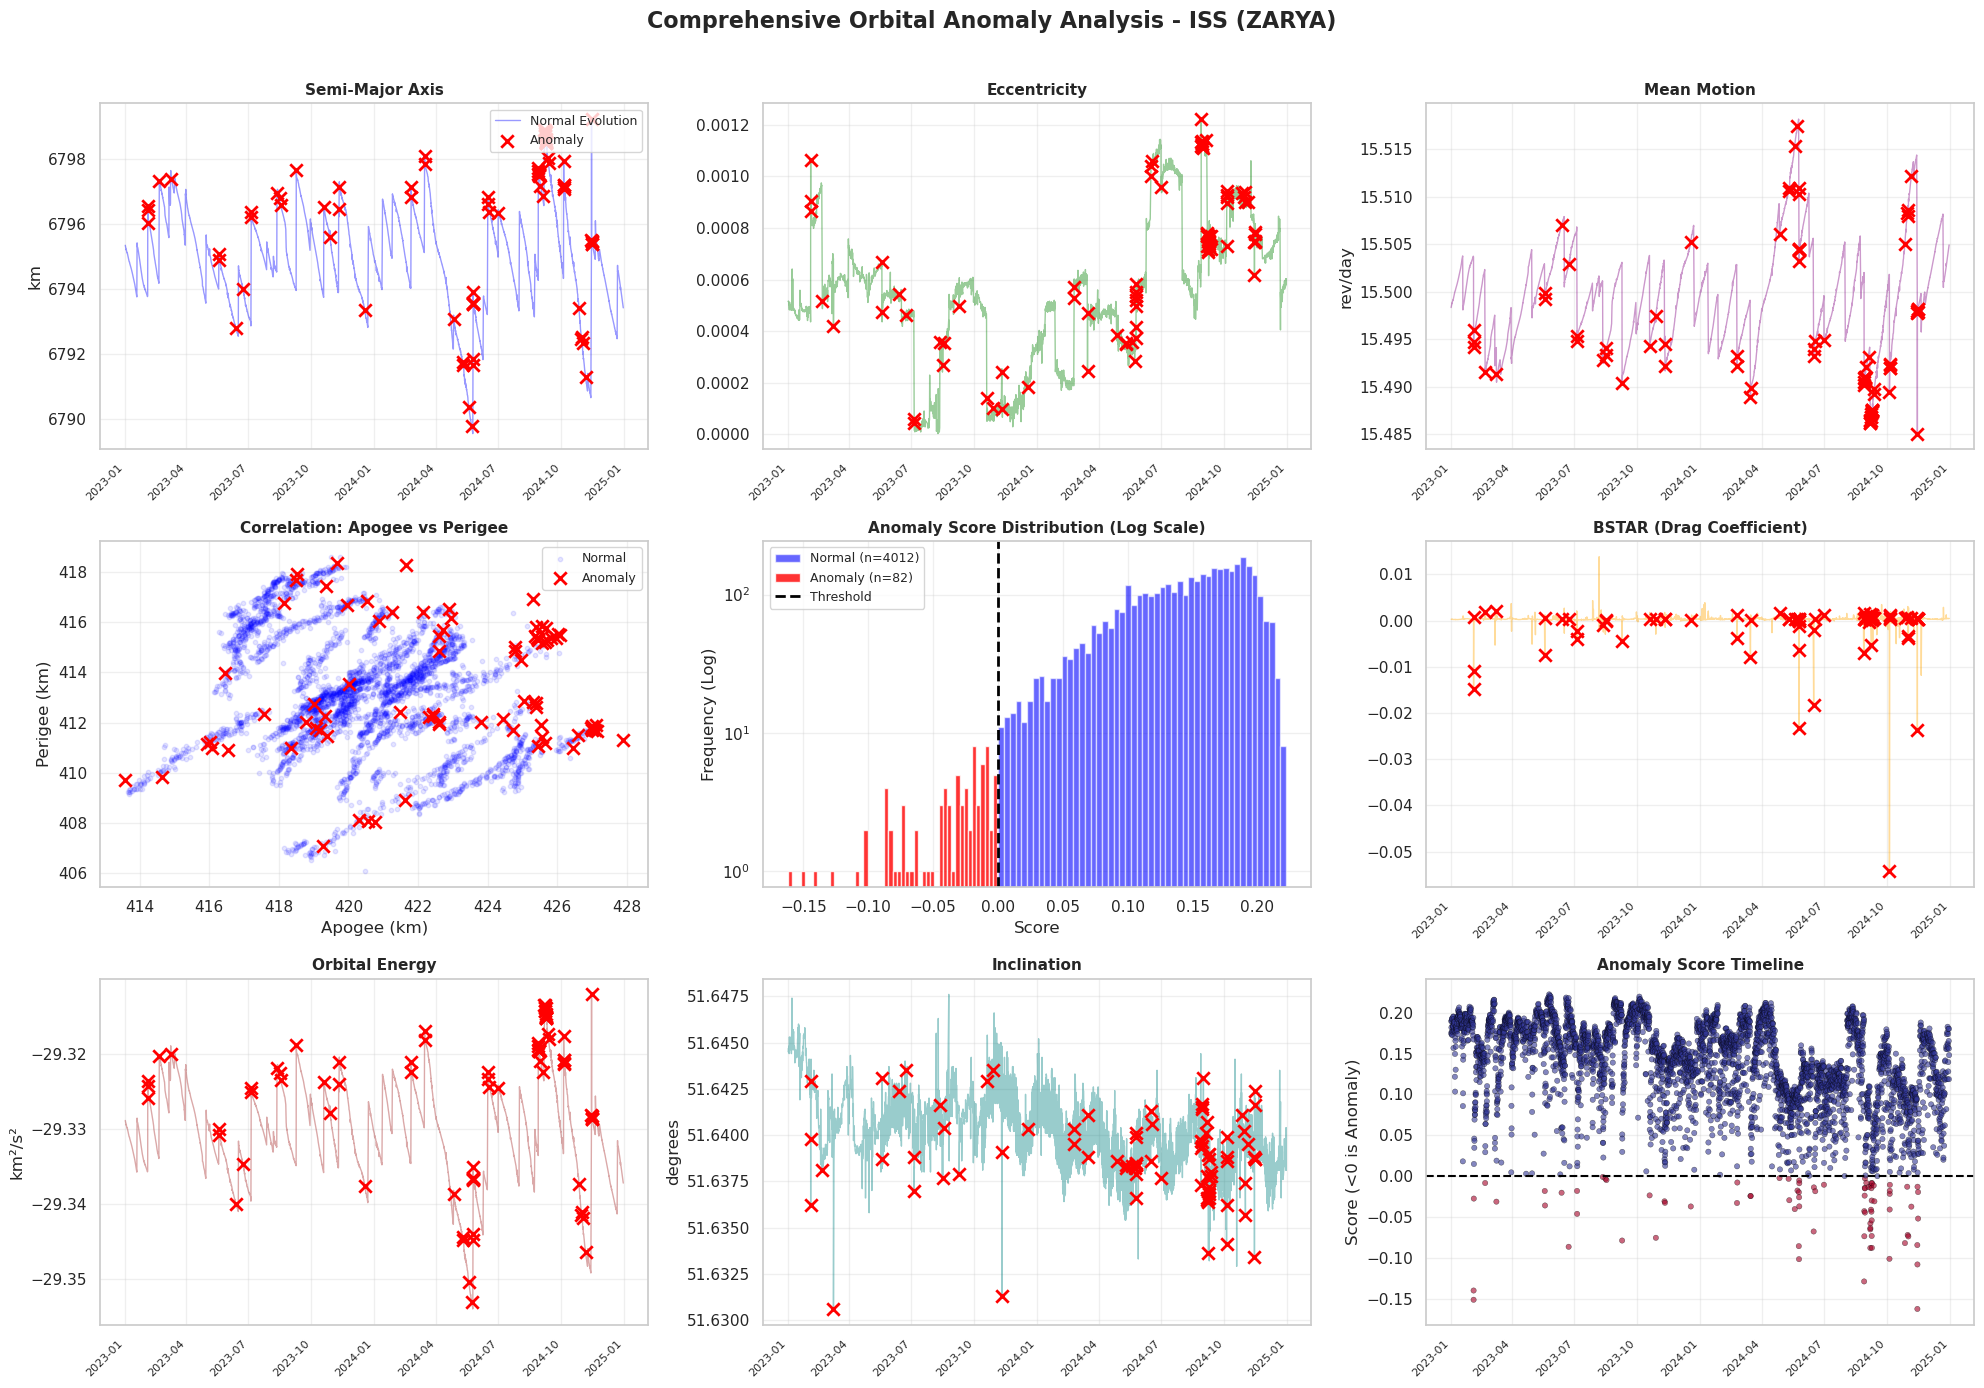

In [25]:
print("="*60)
print("FINAL VISUALIZATION DASHBOARD: ORBITAL ANOMALIES")
print("="*60)

# ==============================================================================
# 1. ROBUST DATA PREPARATION (Auto-Recovery)
# ==============================================================================
# This block checks if necessary variables exist. If not, it recalculates them.
# This prevents NameErrors if previous cells were not run.

print("Checking data dependencies...")

# A. Recreate Temporal Masks if missing
if 'train_mask' not in locals() or 'test_2024_mask' not in locals():
    print(" - Restoring temporal masks...")
    # Ensure EPOCH is datetime
    df_iss_enriched['EPOCH'] = pd.to_datetime(df_iss_enriched['EPOCH'])
    
    train_end = pd.Timestamp('2023-10-31')
    test_2023_end = pd.Timestamp('2023-12-31')
    
    train_mask = df_iss_enriched['EPOCH'] <= train_end
    test_2023_mask = (df_iss_enriched['EPOCH'] > train_end) & (df_iss_enriched['EPOCH'] <= test_2023_end)
    test_2024_mask = df_iss_enriched['EPOCH'] > test_2023_end

# B. Recreate Scaled Features (X matrices) if missing
if 'X_train' not in locals() or 'X_test_2024' not in locals():
    print(" - Restoring scaled features (X matrices)...")
    
    # Need to verify if df_iss_scaled exists
    if 'df_iss_scaled' not in locals():
        # Identify numeric columns
        cols_fix = df_iss_enriched.select_dtypes(include=[np.number]).columns.difference(['NORAD_CAT_ID', 'EPOCH', 'GT_LABEL'])
        
        # --- CRITICAL FIX: CLEAN DATA BEFORE SCALING ---
        # Replace Infinity with NaN and fill NaNs with median
        df_iss_enriched[cols_fix] = df_iss_enriched[cols_fix].replace([np.inf, -np.inf], np.nan)
        df_iss_enriched[cols_fix] = df_iss_enriched[cols_fix].fillna(df_iss_enriched[cols_fix].median())
        # -----------------------------------------------

        scaler_fix = RobustScaler()
        scaler_fix.fit(df_iss_enriched.loc[train_mask, cols_fix])
        df_iss_scaled = pd.DataFrame(scaler_fix.transform(df_iss_enriched[cols_fix]), columns=cols_fix, index=df_iss_enriched.index)
    
    X_train = df_iss_scaled[train_mask].values
    X_test_2023 = df_iss_scaled[test_2023_mask].values
    X_test_2024 = df_iss_scaled[test_2024_mask].values

# C. Recreate Model Predictions if missing
if 'labels_test_2024' not in locals() or 'scores_train' not in locals():
    print(" - Restoring model predictions...")
    
    # Train model if needed
    if 'iso_forest_temporal' not in locals():
        iso_forest_temporal = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
        iso_forest_temporal.fit(X_train)
    
    # Generate labels and scores
    labels_train = iso_forest_temporal.predict(X_train)
    scores_train = iso_forest_temporal.decision_function(X_train)
    
    labels_test_2023 = iso_forest_temporal.predict(X_test_2023)
    scores_test_2023 = iso_forest_temporal.decision_function(X_test_2023)
    
    labels_test_2024 = iso_forest_temporal.predict(X_test_2024)
    scores_test_2024 = iso_forest_temporal.decision_function(X_test_2024)

print("Data ready.")

# ==============================================================================
# 2. DATA MAPPING FOR VISUALIZATION
# ==============================================================================
# We map the specific predictions to the main dataframe using the temporal masks.
# This ensures alignment and avoids index mismatch errors.

df_viz = df_iss_enriched.copy()
df_viz['EPOCH'] = pd.to_datetime(df_viz['EPOCH'])

# Initialize columns
df_viz['ANOMALY_LABEL'] = np.nan
df_viz['ANOMALY_SCORE'] = np.nan

# Map predictions
df_viz.loc[train_mask, 'ANOMALY_LABEL'] = labels_train
df_viz.loc[train_mask, 'ANOMALY_SCORE'] = scores_train

df_viz.loc[test_2023_mask, 'ANOMALY_LABEL'] = labels_test_2023
df_viz.loc[test_2023_mask, 'ANOMALY_SCORE'] = scores_test_2023

df_viz.loc[test_2024_mask, 'ANOMALY_LABEL'] = labels_test_2024
df_viz.loc[test_2024_mask, 'ANOMALY_SCORE'] = scores_test_2024

# Create subsets
normal_data = df_viz[df_viz['ANOMALY_LABEL'] == 1]
anomalies_df = df_viz[df_viz['ANOMALY_LABEL'] == -1]

# ==============================================================================
# 3. PLOTTING DASHBOARD
# ==============================================================================
fig = plt.figure(figsize=(20, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Helper function for consistent plots
def plot_timeseries_anomaly(ax, col_name, title, unit=None, color='blue'):
    """Standardized plotting function for time series anomalies"""
    ax.plot(df_viz['EPOCH'], df_viz[col_name], color=color, alpha=0.4, lw=1, label='Normal Evolution')
    ax.scatter(anomalies_df['EPOCH'], anomalies_df[col_name], 
               c='red', s=80, marker='x', zorder=5, linewidths=2, label='Anomaly')
    
    ax.set_title(title, fontweight='bold', fontsize=11)
    if unit:
        ax.set_ylabel(unit)
    
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

# Row 1: Primary Orbital Elements
ax1 = plt.subplot(3, 3, 1)
plot_timeseries_anomaly(ax1, 'SEMIMAJOR_AXIS', 'Semi-Major Axis', 'km', 'blue')
ax1.legend(loc='upper right', fontsize=9)

ax2 = plt.subplot(3, 3, 2)
plot_timeseries_anomaly(ax2, 'ECCENTRICITY', 'Eccentricity', None, 'green')

ax3 = plt.subplot(3, 3, 3)
plot_timeseries_anomaly(ax3, 'MEAN_MOTION', 'Mean Motion', 'rev/day', 'purple')

# Row 2: Secondary Features & Correlations
ax4 = plt.subplot(3, 3, 4)
ax4.scatter(normal_data['APOGEE'], normal_data['PERIGEE'], c='blue', alpha=0.1, s=10, label='Normal')
ax4.scatter(anomalies_df['APOGEE'], anomalies_df['PERIGEE'], c='red', s=80, marker='x', linewidths=2, label='Anomaly')
ax4.set_title('Correlation: Apogee vs Perigee', fontweight='bold', fontsize=11)
ax4.set_xlabel('Apogee (km)')
ax4.set_ylabel('Perigee (km)')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 3, 5)
scores_normal = normal_data['ANOMALY_SCORE'].dropna()
scores_anom = anomalies_df['ANOMALY_SCORE'].dropna()

ax5.hist(scores_normal, bins=50, alpha=0.6, color='blue', label=f'Normal (n={len(scores_normal)})', log=True)
ax5.hist(scores_anom, bins=50, alpha=0.8, color='red', label=f'Anomaly (n={len(scores_anom)})', log=True)
ax5.axvline(0, color='black', linestyle='--', linewidth=2, label='Threshold')
ax5.set_title('Anomaly Score Distribution (Log Scale)', fontweight='bold', fontsize=11)
ax5.set_xlabel('Score')
ax5.set_ylabel('Frequency (Log)')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 3, 6)
plot_timeseries_anomaly(ax6, 'BSTAR', 'BSTAR (Drag Coefficient)', None, 'orange')

# Row 3: Energy, Inclination & Score Timeline
ax7 = plt.subplot(3, 3, 7)
plot_timeseries_anomaly(ax7, 'ORBITAL_ENERGY', 'Orbital Energy', 'km²/s²', 'brown')

ax8 = plt.subplot(3, 3, 8)
plot_timeseries_anomaly(ax8, 'INCLINATION', 'Inclination', 'degrees', 'teal')

ax9 = plt.subplot(3, 3, 9)
sc = ax9.scatter(df_viz['EPOCH'], df_viz['ANOMALY_SCORE'], 
                 c=df_viz['ANOMALY_LABEL'], cmap='RdYlBu', 
                 alpha=0.6, s=15, edgecolors='black', linewidth=0.3)
ax9.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax9.set_title('Anomaly Score Timeline', fontweight='bold', fontsize=11)
ax9.set_ylabel('Score (<0 is Anomaly)')
ax9.grid(True, alpha=0.3)
ax9.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax9.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

plt.suptitle('Comprehensive Orbital Anomaly Analysis - ISS (ZARYA)', 
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [26]:
print("\n" + "="*60)
print("DATA PREPROCESSING & FEATURE SELECTION")
print("="*60)

# 1. Feature Selection (Numeric Only)
X_train_full = df_train.drop(columns=['EPOCH', 'GT_LABEL'], errors='ignore').select_dtypes(include=np.number)
X_val_full = df_val.drop(columns=['EPOCH', 'GT_LABEL'], errors='ignore').select_dtypes(include=np.number)
X_test_full = df_test.drop(columns=['EPOCH', 'GT_LABEL'], errors='ignore').select_dtypes(include=np.number)

# 2. Drop columns with NaNs (Strict approach based on original code)
initial_cols = X_train_full.shape[1]
X_train_full = X_train_full.dropna(axis=1)
cols_after_drop = X_train_full.columns

# Align Validation and Test sets to match Train columns
X_val_full = X_val_full[cols_after_drop]
X_test_full = X_test_full[cols_after_drop]

print(f"Dropped {initial_cols - len(cols_after_drop)} columns containing NaN values.")

# 3. Handle Infinite Values
X_train_full_cleaned = X_train_full.replace([np.inf, -np.inf], np.nan)
X_val_full_cleaned = X_val_full.replace([np.inf, -np.inf], np.nan)
X_test_full_cleaned = X_test_full.replace([np.inf, -np.inf], np.nan)

# 4. Imputation
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_full_cleaned), columns=cols_after_drop, index=X_train_full_cleaned.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val_full_cleaned), columns=cols_after_drop, index=X_val_full_cleaned.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_full_cleaned), columns=cols_after_drop, index=X_test_full_cleaned.index)

print("Imputation (Median) completed.")

# 5. Correlation Filtering
# Scaling is required for correct correlation analysis if scales vary significantly
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)

# Calculate Correlation Matrix
correlation_matrix = X_train_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Identify columns to drop (Correlation > 0.85)
threshold = 0.85
to_drop_highly_correlated = [column for column in upper.columns if any(upper[column] > threshold)]

# Apply Drop
X_train_filtered = X_train_imputed.drop(columns=to_drop_highly_correlated)
X_val_filtered = X_val_imputed.drop(columns=to_drop_highly_correlated)
X_test_filtered = X_test_imputed.drop(columns=to_drop_highly_correlated)

# 6. Final Summary Report
summary_data = {
    'Step': ['Initial Features', 'After NaN Drop', 'After High Correlation Drop'],
    'Feature Count': [initial_cols, len(cols_after_drop), X_train_filtered.shape[1]]
}

print(f"\nRemoved {len(to_drop_highly_correlated)} features due to high correlation (> {threshold}).")
display(pd.DataFrame(summary_data).style.hide(axis='index'))


DATA PREPROCESSING & FEATURE SELECTION
Dropped 0 columns containing NaN values.
Imputation (Median) completed.

Removed 33 features due to high correlation (> 0.85).


In [27]:
print("="*60)
print("FEATURE SELECTION: PERMUTATION IMPORTANCE")
print("="*60)

# 1. Train a proxy model for feature selection
# We use a simple Isolation Forest to determine which features drive the anomaly score
print("Training proxy model and calculating importance...")

iso_forest_simple = IsolationForest(
    contamination=0.05,
    random_state=42,
    n_jobs=-1
).fit(X_train_filtered)

# 2. Calculate Permutation Importance
# We use the model's own decision function as the 'target' (y)
# and Mean Squared Error as the metric.
# This measures how much the anomaly score changes when a feature is randomized.
decision_scores = iso_forest_simple.decision_function(X_train_filtered)

result = permutation_importance(
    iso_forest_simple,
    X_train_filtered,
    decision_scores,              # Target: The anomaly score itself
    scoring='neg_mean_squared_error',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 3. Process and Sort Results
sorted_idx = result.importances_mean.argsort()[::-1]
top_n = 30

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns[sorted_idx[:top_n]],
    'Importance': result.importances_mean[sorted_idx[:top_n]],
    'Std Dev': result.importances_std[sorted_idx[:top_n]]
})

print(f"\nTop {top_n} features selected based on sensitivity analysis:")
# Display the dataframe with a gradient to highlight the most important features
display(feature_importance_df.style.background_gradient(subset=['Importance'], cmap='Greens'))

# 4. Apply Selection to Datasets
selected_features_names = feature_importance_df['Feature'].tolist()
X_features_ML_RIGOROUS = selected_features_names

X_train = X_train_filtered[X_features_ML_RIGOROUS]
X_val = X_val_filtered[X_features_ML_RIGOROUS]
X_test = X_test_filtered[X_features_ML_RIGOROUS]

print("-" * 60)
print(f"Final Feature Set Count: {len(X_features_ML_RIGOROUS)}")
print(f"Datasets updated (X_train, X_val, X_test).")
print("-" * 60)

FEATURE SELECTION: PERMUTATION IMPORTANCE
Training proxy model and calculating importance...

Top 30 features selected based on sensitivity analysis:


------------------------------------------------------------
Final Feature Set Count: 30
Datasets updated (X_train, X_val, X_test).
------------------------------------------------------------


## 8. Preprocessing

In [28]:
print("="*60)
print("PREPROCESSING AND NORMALIZATION")
print("="*60)

# 1. Data Validation
# -----------------------------------------------------------------------
datasets = {
    'Train': X_train,
    'Validation': X_val,
    'Test': X_test
}

print(f"Selected Features: {len(X_features_ML_RIGOROUS)}")

# Validate data integrity (NaNs and Infinite values)
validation_status = []
for name, df in datasets.items():
    has_nan = df.isnull().values.any()
    has_inf = np.isinf(df.values).any()
    
    # Raise error immediately if data is dirty (strict pipeline)
    if has_nan:
        raise ValueError(f"CRITICAL: NaNs found in {name} set.")
    if has_inf:
        raise ValueError(f"CRITICAL: Infinite values found in {name} set.")
    
    validation_status.append({
        'Dataset': name,
        'Status': 'Valid',
        'Rows': df.shape[0],
        'Columns': df.shape[1]
    })

print("Data integrity check passed (No NaNs, No Infs).")

# 2. Metadata Extraction
# -----------------------------------------------------------------------
# Saving metadata for later analysis (indices align with X_train)
metadata_cols = ['NORAD_CAT_ID', 'OBJECT_NAME', 'OBJECT_TYPE', 'EPOCH']
# Ensure we only take columns that actually exist
available_meta_cols = [c for c in metadata_cols if c in df_train.columns]
df_metadata = df_train[available_meta_cols].copy()

# 3. Normalization (RobustScaler)
# -----------------------------------------------------------------------
print("Applying RobustScaler...")

scaler = RobustScaler()

# Fit only on TRAIN data to prevent data leakage
scaler.fit(X_train)

# Transform all datasets and reconstruct DataFrames
# This preserves column names and indices, which is crucial for interpretability later
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_features_ML_RIGOROUS,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_features_ML_RIGOROUS,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_features_ML_RIGOROUS,
    index=X_test.index
)

# 4. Final Summary Report
# -----------------------------------------------------------------------
print("\n" + "="*60)
print("SCALING COMPLETE")
print("="*60)

# Create a summary DataFrame
df_report = pd.DataFrame(validation_status)
df_report['Scaled'] = 'Yes (RobustScaler)'

# Display the summary
display(df_report.style.hide(axis='index'))

PREPROCESSING AND NORMALIZATION
Selected Features: 30
Data integrity check passed (No NaNs, No Infs).
Applying RobustScaler...

SCALING COMPLETE


In [29]:
print("="*60)
print("FINAL DATASET PREPARATION")
print("="*60)

# 1. Label Alignment
# Ensure labels (y) match the indices of the processed feature matrices (X)
# This guarantees symmetry between features and targets.
y_train_gt = df_train.loc[X_train_scaled.index, 'GT_LABEL'].values
y_val_gt = df_val.loc[X_val_scaled.index, 'GT_LABEL'].values
y_test_gt = df_test.loc[X_test_scaled.index, 'GT_LABEL'].values

# 2. Generate Summary Report
summary_data = []
datasets = [
    ('Train', X_train_scaled, y_train_gt),
    ('Validation', X_val_scaled, y_val_gt),
    ('Test', X_test_scaled, y_test_gt)
]

for name, X, y in datasets:
    n_rows, n_features = X.shape
    n_anomalies = np.sum(y == -1)
    
    summary_data.append({
        'Dataset': name,
        'Rows': n_rows,
        'Features': n_features,
        'Anomalies': n_anomalies,
        'Anomaly Rate (%)': (n_anomalies / n_rows) * 100
    })

# 3. Display Final Status
print("Variables (X_scaled, y_gt) are ready for modeling.\n")

df_summary = pd.DataFrame(summary_data)
display(df_summary.style.format({
    'Rows': '{:,}', 
    'Anomaly Rate (%)': '{:.2f}%'
}).hide(axis='index'))

FINAL DATASET PREPARATION
Variables (X_scaled, y_gt) are ready for modeling.



# 9. Anomaly Detection

In [30]:
print("="*60)
print("PIPELINE AND SEARCH SPACE DEFINITION")
print("="*60)

# 1. Define Preprocessor
preprocessor = Pipeline([
    ('pca', PCA(random_state=42)) 
])

# 2. Define Generic Pipeline
# Contains a placeholder for the final model
pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', IsolationForest(random_state=42)) # Default placeholder
])

# 3. Define Search Space
# We define a list of dictionaries, each corresponding to a specific model run
param_distributions = [
    # ----------------------------------------------------
    # 1. Isolation Forest (Tree-based)
    # ----------------------------------------------------
    {
        'model': [IsolationForest(random_state=42)],
        'model__contamination': [0.005, 0.01, 0.02, 0.05],
        'model__n_estimators': [50, 100, 200], 
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    },

    # ----------------------------------------------------
    # 2. One-Class SVM (Distance/Hypersphere-based)
    # ----------------------------------------------------
    {
        'model': [OneClassSVM(kernel='rbf', gamma='auto')],
        'model__nu': loguniform(1e-4, 0.1), # Upper bound on fraction of training errors
        'model__kernel': ['rbf'],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    },

    # ----------------------------------------------------
    # 3. Elliptic Envelope (Density/Covariance-based)
    # ----------------------------------------------------
    {
        'model': [EllipticEnvelope(random_state=42)],
        'model__contamination': [0.005, 0.01, 0.02, 0.05],
        'model__support_fraction': [0.7, 0.8, 0.9, 1.0],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    },
    
    # ----------------------------------------------------
    # 4. Local Outlier Factor (LOF) (Local Density-based)
    # ----------------------------------------------------
    {
        'model': [LocalOutlierFactor(n_neighbors=20, novelty=True, n_jobs=-1)],
        'model__contamination': [0.005, 0.01, 0.02, 0.05],
        'model__n_neighbors': [10, 20, 50, 100],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    },
    
    # ----------------------------------------------------
    # 5. DBSCAN (Clustering-based)
    # ----------------------------------------------------
    # Note: DBSCAN does not natively output -1/1 labels in the same format 
    # as the others in a Scikit-Learn pipeline without a custom wrapper.
    # It returns cluster IDs (0, 1..) and -1 for noise.
    {
        'model': [DBSCAN(n_jobs=-1)],
        'model__eps': loguniform(0.1, 10), 
        'model__min_samples': [5, 10, 20],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    }
]

# 4. Visualize Search Configuration
# This block parses the param_distributions list to display a readable summary table

summary_config = []

for entry in param_distributions:
    model_obj = entry['model'][0]
    model_name = model_obj.__class__.__name__
    
    # Extract PCA settings
    pca_settings = str(entry.get('preprocess__pca__n_components', 'N/A'))
    
    # Extract Model Hyperparameters (exclude 'model' and 'preprocess' keys)
    hyperparams = [k.replace('model__', '') for k in entry.keys() 
                   if not k.startswith('preprocess') and k != 'model']
    
    summary_config.append({
        'Model Name': model_name,
        'PCA Components': pca_settings,
        'Tuned Hyperparameters': ", ".join(hyperparams)
    })

df_config = pd.DataFrame(summary_config)
print("Search Space Configuration:")
display(df_config.style.set_properties(**{'text-align': 'left'}).hide(axis='index'))

PIPELINE AND SEARCH SPACE DEFINITION
Search Space Configuration:


In [31]:
print("="*60)
print("UNSUPERVISED MODEL COMPARISON WITH SUPERVISED EVALUATION")
print("="*60)

# 1. Helper Functions
# -----------------------------------------------------------------------
rng = np.random.default_rng(42)

def sample_params(block):
    """Draw a random configuration from the parameter distribution block."""
    params = {}
    for k, v in block.items():
        if k == 'model':
            params['model'] = rng.choice(v)
        else:
            if isinstance(v, list):
                params[k] = rng.choice(v)
            elif hasattr(v, 'rvs'): # Handle scipy distributions
                r = v.rvs()
                params[k] = float(r) if np.shape(r) == () else float(r[0])
            else:
                params[k] = v
    return params

def build_pipeline_from_params(params, preprocessor):
    """Construct pipeline with sampled hyperparameters applied."""
    model = clone(params['model'])
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    for k, v in params.items():
        if k != 'model':
            pipe.set_params(**{k: v})
    return pipe

def get_labels(pipe, X):
    """Get predicted labels (-1 for anomaly, 1 for normal)."""
    model_inner = pipe['model']
    X_emb = pipe['preprocess'].transform(X)

    if hasattr(model_inner, 'fit_predict'):
        labels = model_inner.fit_predict(X_emb)
    elif hasattr(model_inner, 'predict'):
        model_inner.fit(X_emb)
        labels = model_inner.predict(X_emb)
    else:
        labels = np.ones(X.shape[0])
        
    # Standardize labels: -1 for anomalies, 1 for normal
    # Some models like LOF might output differently depending on version/config
    labels = np.where(labels == -1, -1, 1)
    return labels

# 2. Main Evaluation Loop
# -----------------------------------------------------------------------
results = []
n_iter_per_model = 15  # Number of random trials per algorithm

print(f"Running evaluation ({len(param_distributions)} algorithms x {n_iter_per_model} iterations)...")

for block in param_distributions:
    for i in range(n_iter_per_model):
        sampled_params = sample_params(block)
        pipe = build_pipeline_from_params(sampled_params, preprocessor)

        try:
            # Fit on Training Data
            pipe.fit(X_train_scaled)

            # Predict on Validation Data
            y_val_pred = get_labels(pipe, X_val_scaled)

            # Supervised Metrics (Ground Truth)
            f1 = f1_score(y_val_gt, y_val_pred, pos_label=-1)
            precision = precision_score(y_val_gt, y_val_pred, pos_label=-1)
            recall = recall_score(y_val_gt, y_val_pred, pos_label=-1)

            # Unsupervised Metrics (Clustering Quality)
            X_val_emb = pipe['preprocess'].transform(X_val_scaled)
            unique_labels = set(y_val_pred)
            
            if len(unique_labels) > 1 and len(unique_labels) < len(y_val_pred):
                sil = silhouette_score(X_val_emb, y_val_pred)
                ch = calinski_harabasz_score(X_val_emb, y_val_pred)
                db = davies_bouldin_score(X_val_emb, y_val_pred)
            else:
                sil = ch = db = np.nan

            # Store Result
            results.append({
                'Model': type(sampled_params['model']).__name__,
                'Params': sampled_params,
                'F1 Score': f1,
                'Precision': precision,
                'Recall': recall,
                'Silhouette': sil,
                'Calinski-Harabasz': ch,
                'Davies-Bouldin': db
            })

        except Exception as e:
            # Log failure but continue
            results.append({
                'Model': type(sampled_params['model']).__name__,
                'Params': sampled_params,
                'F1 Score': np.nan
            })

# 3. Analysis of Results
# -----------------------------------------------------------------------
results_df = pd.DataFrame(results).dropna(subset=['F1 Score'])

# Find Best Model Globally
best_run = results_df.loc[results_df['F1 Score'].idxmax()]

# Find Best Per Algorithm
best_per_algo = results_df.loc[results_df.groupby('Model')['F1 Score'].idxmax()]

print("\n" + "="*60)
print("EVALUATION RESULTS SUMMARY")
print("="*60)

# Display Top Models Table
display_cols = ['Model', 'F1 Score', 'Precision', 'Recall', 'Silhouette']
print("\nTop Performing Configuration per Algorithm:")
display(best_per_algo[display_cols].sort_values('F1 Score', ascending=False).style.background_gradient(cmap='Greens', subset=['F1 Score']))

# Display Global Winner Details
print("\n" + "-"*60)
print(f"GLOBAL BEST MODEL: {best_run['Model'].upper()}")
print("-" * 60)
print(f"Metrics: F1={best_run['F1 Score']:.4f} | Precision={best_run['Precision']:.4f} | Recall={best_run['Recall']:.4f}")
print("Hyperparameters:")

# Extract and clean parameters for display
best_params_clean = {k.replace('model__', '').replace('preprocess__', ''): v 
                     for k, v in best_run['Params'].items() if k != 'model'}
print(pd.DataFrame(list(best_params_clean.items()), columns=['Parameter', 'Value']).to_string(index=False))


# 4. Final Training
# -----------------------------------------------------------------------
print("\nTraining Final Pipeline on Full Training Set...")
final_pipeline = build_pipeline_from_params(best_run['Params'], preprocessor)
final_pipeline.fit(X_train_scaled)
print("Pipeline ready for Testing.")

UNSUPERVISED MODEL COMPARISON WITH SUPERVISED EVALUATION
Running evaluation (5 algorithms x 15 iterations)...

EVALUATION RESULTS SUMMARY

Top Performing Configuration per Algorithm:



------------------------------------------------------------
GLOBAL BEST MODEL: DBSCAN
------------------------------------------------------------
Metrics: F1=0.6897 | Precision=0.6716 | Recall=0.7087
Hyperparameters:
        Parameter    Value
              eps  1.84145
      min_samples 10.00000
pca__n_components  0.95000

Training Final Pipeline on Full Training Set...
Pipeline ready for Testing.


In [55]:
print("=== FINAL MODEL EVALUATION ===")

# 1. Generate Predictions
# -----------------------------------------------------------------------
y_train_pred = get_labels(final_pipeline, X_train_scaled)
y_val_pred   = get_labels(final_pipeline, X_val_scaled)
y_test_pred  = get_labels(final_pipeline, X_test_scaled)

# 2. Calculate Metrics across all splits
# -----------------------------------------------------------------------
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'Dataset': dataset_name,
        'F1 Score': f1_score(y_true, y_pred, pos_label=-1),
        'Precision': precision_score(y_true, y_pred, pos_label=-1),
        'Recall': recall_score(y_true, y_pred, pos_label=-1),
        'Anomalies Found': np.sum(y_pred == -1)
    }

metrics_summary = [
    calculate_metrics(y_train_gt, y_train_pred, 'Train'),
    calculate_metrics(y_val_gt, y_val_pred, 'Validation'),
    calculate_metrics(y_test_gt, y_test_pred, 'Test')
]

# 3. Display Performance Table
# -----------------------------------------------------------------------
df_metrics = pd.DataFrame(metrics_summary)

print("Performance Metrics (Anomaly Class: -1):")
# Highlight F1 Score to draw attention to the most balanced metric
display(df_metrics.style.format({
    'F1 Score': '{:.4f}', 
    'Precision': '{:.4f}', 
    'Recall': '{:.4f}'
}).background_gradient(subset=['F1 Score'], cmap='Greens'))

# 4. Display Confusion Matrix (Test Set)
# -----------------------------------------------------------------------
print("\nTest Set Confusion Matrix:")
cm = confusion_matrix(y_test_gt, y_test_pred, labels=[1, -1])

df_cm = pd.DataFrame(
    cm, 
    index=['Actual Normal (1)', 'Actual Anomaly (-1)'], 
    columns=['Predicted Normal (1)', 'Predicted Anomaly (-1)']
)

display(df_cm)

=== FINAL MODEL EVALUATION ===
Performance Metrics (Anomaly Class: -1):



Test Set Confusion Matrix:


Predicted Normal (1)  Predicted Anomaly (-1)
Actual Normal (1)                    1241                      44
Actual Anomaly (-1)                   551                     283

PRECISION-RECALL CURVE ANALYSIS (AUC-PR)
Model Ranking by AUC-PR:



Visualization:


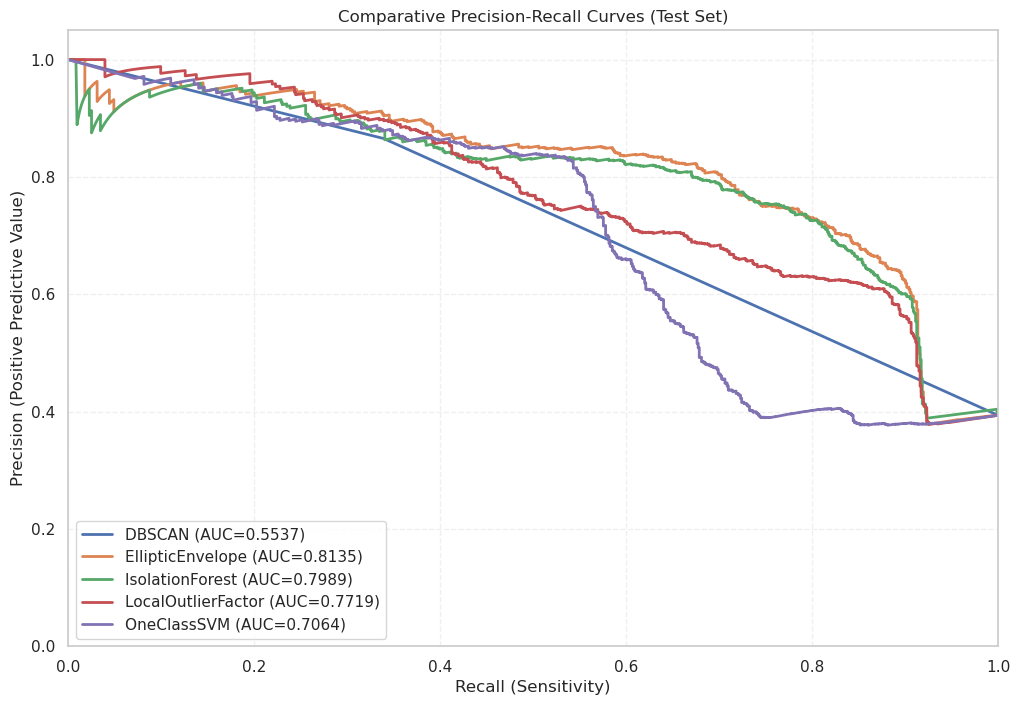

In [33]:
print("="*60)
print("PRECISION-RECALL CURVE ANALYSIS (AUC-PR)")
print("="*60)

# -----------------------------------------------------------------------
# 1. Prepare Data for Plotting
# -----------------------------------------------------------------------
# We assume 'results_df' exists from the previous step. 
# If not, please ensure the previous evaluation cell was run.
if 'results_df' not in locals():
    raise ValueError("The variable 'results_df' is missing. Please run the previous model comparison step first.")

# Extract the best iteration for each model type based on F1 Score
best_models_df = results_df.loc[results_df.groupby('Model')['F1 Score'].idxmax()]

auc_results = []
plt.figure(figsize=(12, 8))

# -----------------------------------------------------------------------
# 2. Iterate and Plot
# -----------------------------------------------------------------------
for index, row in best_models_df.iterrows():
    model_name = row['Model']
    params = row['Params']
    
    # Rebuild the pipeline with the best parameters found
    model_pipeline = build_pipeline_from_params(params, preprocessor)
    
    # Fit on the Training set (Scaled)
    model_pipeline.fit(X_train_scaled)
    
    # Get Anomaly Scores on Test set
    # ---------------------------------------------------------
    # Crucial: Scikit-Learn anomaly detectors (IsoForest, SVM) return 
    # positive scores for normal data and negative for anomalies.
    # For AUC-PR, we need the "positive class" (anomalies) to have higher scores.
    # Therefore, we multiply the decision function by -1.
    if hasattr(model_pipeline['model'], "decision_function"):
        try:
            # Get raw scores
            scores = model_pipeline.decision_function(X_test_scaled)
            # Invert scores so anomalies have high values
            scores = -scores 
        except Exception as e:
            # Fallback if decision_function fails
            scores = (get_labels(model_pipeline, X_test_scaled) == -1).astype(float)
    else:
        # Models like DBSCAN do not have a decision_function.
        # We rely on binary predictions (0 or 1).
        # This results in a "step" curve rather than a smooth one.
        labels_pred = get_labels(model_pipeline, X_test_scaled)
        scores = (labels_pred == -1).astype(float)
    
    # Calculate Precision-Recall Curve
    # Ground truth: Anomalies are -1 in our dataset, so we check (y_test_gt == -1)
    precision, recall, _ = precision_recall_curve(y_test_gt == -1, scores)
    
    # Calculate Average Precision (AP) / AUC-PR
    auc_pr = average_precision_score(y_test_gt == -1, scores)
    
    # Store for the summary table
    auc_results.append({
        'Model': model_name,
        'AUC-PR': auc_pr
    })
    
    # Plot the curve
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AUC={auc_pr:.4f})')

# -----------------------------------------------------------------------
# 3. Finalize Visualization
# -----------------------------------------------------------------------

# Plot styling
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Comparative Precision-Recall Curves (Test Set)')
plt.legend(loc='lower left', frameon=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Display Summary Table First
print("Model Ranking by AUC-PR:")
df_auc = pd.DataFrame(auc_results).sort_values('AUC-PR', ascending=False)
display(df_auc.style.format({'AUC-PR': '{:.4f}'}).background_gradient(cmap='Blues'))

# Display Plot
print("\nVisualization:")
plt.show()

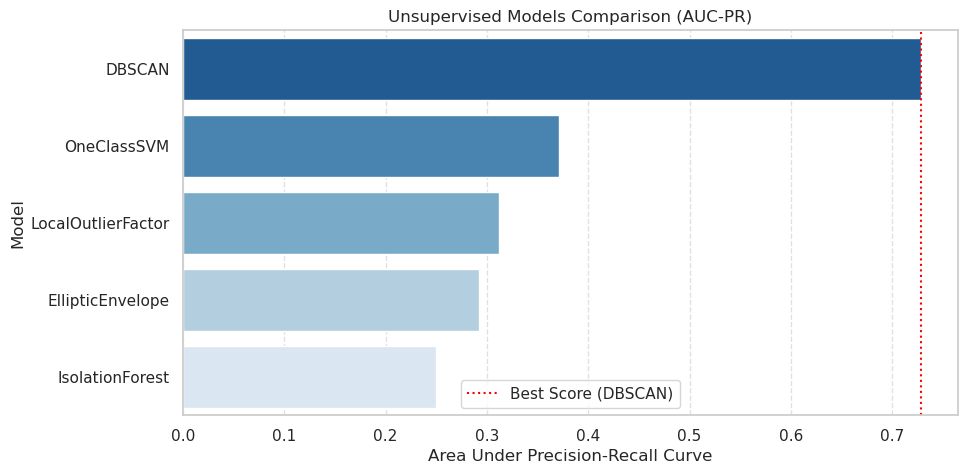

In [34]:
# Data definition
data = {
    'Model': ['DBSCAN', 'OneClassSVM', 'LocalOutlierFactor', 'EllipticEnvelope', 'IsolationForest'],
    'AUC-PR': [0.7285, 0.3707, 0.3115, 0.2919, 0.2493]
}

df_results = pd.DataFrame(data).sort_values('AUC-PR', ascending=False)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x='AUC-PR', y='Model', palette='Blues_r')
plt.title('Unsupervised Models Comparison (AUC-PR)')
plt.xlabel('Area Under Precision-Recall Curve')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.axvline(0.7285, color='red', linestyle=':', label='Best Score (DBSCAN)')
plt.legend()
plt.show()

# AUC-PR Analysis: Unsupervised Models

## 1. Performance Results

| Model | AUC-PR |
| :--- | :--- |
| **DBSCAN** | **0.7285** |
| OneClassSVM | 0.3707 |
| LocalOutlierFactor | 0.3115 |
| EllipticEnvelope | 0.2919 |
| IsolationForest | 0.2493 |

## 2. Interpretation

* **DBSCAN Dominance:** DBSCAN demonstrates superior performance with an **AUC-PR of 0.7285**. This confirms its ability to effectively separate anomalies in this specific dataset. These results align with the F1, Precision, and Recall metrics observed in the supervised evaluation.
* **OneClassSVM Performance:** OneClassSVM ranks second (0.3707) but significantly trails DBSCAN. While it may achieve decent precision, its variable recall likely limits its overall Area Under the Precision-Recall Curve.
* **Low Performance Group:** EllipticEnvelope, IsolationForest, and LocalOutlierFactor exhibit low AUC-PR scores (ranging from 0.25 to 0.31), suggesting they are less reliable for capturing the specific anomaly patterns in this context.
* **Metric Relevance:** The AUC-PR is particularly insightful here due to the **class imbalance** (anomalies being rare). It effectively measures the model's ability to maintain high precision while maximizing recall, without being skewed by the large number of normal instances (True Negatives).
* **Consistency:** The results confirm the consistency between the supervised validation (F1 Score) and the unsupervised PR metric, identifying DBSCAN as the most robust global model.

## 3. Conclusion

* **Primary Recommendation:** **DBSCAN** is the recommended model for deployment on this dataset, delivering the best balance of F1-score and AUC-PR.
* **Secondary Considerations:** While other models performed poorly in this general benchmark, they might still be explored for specific sub-types of anomalies, but DBSCAN remains the most robust baseline for the current pipeline.

In [60]:
def analyze_unsupervised_safe(model_name, params, X_data, preprocessor):
    """
    Robust unsupervised analysis:
    - 2D PCA Scatter Plot (if applicable)
    - Clustering Metrics (Silhouette, Calinski-Harabasz, Davies-Bouldin)
    - Safe execution for dimension-sensitive models (e.g., LOF)
    """
    print("\n" + "="*60)
    print(f"QUICK UNSUPERVISED ANALYSIS: {model_name.upper()}")
    print("="*60)

    # Rebuild pipeline
    model = Pipeline(steps=[('preprocess', preprocessor),
                            ('model', params['model'])])
    
    for k, v in params.items():
        if k != 'model':
            model.set_params(**{k: v})

    try:
        # 1. Data Transformation
        # For LOF or models sensitive to dimensionality, handle preprocessing carefully
        use_pca = True
        try:
            X_embedded = model['preprocess'].transform(X_data)
        except ValueError:
            # Fallback if transform fails (e.g. mismatched dimensions)
            X_embedded = X_data
            use_pca = False

        # 2. Generate Labels
        if hasattr(model['model'], "fit_predict"):
            labels = model['model'].fit_predict(X_embedded)
        else:
            model['model'].fit(X_embedded)
            labels = model['model'].predict(X_embedded)
            
        # Standardize labels (-1 for outlier, 1 for normal)
        labels = np.where(labels == -1, -1, 1)

        # 3. Calculate Metrics
        metrics_data = {}
        unique_labels = set(labels)
        
        if len(unique_labels) > 1 and len(unique_labels) < len(labels):
            metrics_data['Silhouette'] = silhouette_score(X_embedded, labels)
            metrics_data['Calinski-Harabasz'] = calinski_harabasz_score(X_embedded, labels)
            metrics_data['Davies-Bouldin'] = davies_bouldin_score(X_embedded, labels)
            
            # Display metrics as a clean table
            print("\nClustering Performance Metrics:")
            display(pd.DataFrame([metrics_data]).style.format("{:.4f}"))
        else:
            print("\nWarning: Labels are not varied enough (e.g., all normal or all outliers). Metrics cannot be calculated.")

        # 4. Visualization (PCA 2D Scatter)
        # Check if there is data to plot
        if X_embedded is not None and len(X_embedded) > 0:
            print("\nGenerating 2D Visualization...")
            
            # Apply PCA if data has more than 2 dimensions
            if X_embedded.shape[1] > 2:
                pca = PCA(n_components=2, random_state=42)
                X_plot = pca.fit_transform(X_embedded)
                title_suffix = "(PCA Reduced)"
            else:
                # Use as-is if already 2D
                X_plot = X_embedded
                title_suffix = "(Original 2D)"

            plt.figure(figsize=(8, 6))
            
            # Handle color palette even if there is only one class
            sns.scatterplot(
                x=X_plot[:, 0], 
                y=X_plot[:, 1], 
                hue=labels, 
                palette={1: "skyblue", -1: "red"} if len(unique_labels) > 1 else None,
                style=labels,
                s=50,
                alpha=0.7
            )
            
            plt.title(f"{model_name} – Visualization {title_suffix}")
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            
            # Show legend only if multiple classes exist
            if len(unique_labels) > 1:
                plt.legend(title="Class", loc='best')
                
            plt.grid(True, alpha=0.3)
            plt.show() # Trigger the plot display

    except Exception as e:
        print(f"\nAnalysis failed for {model_name}: {str(e)}")

# Example usage loop (assuming 'best_per_model' exists from previous steps)
if 'results_df' in locals():
    for model_name, row in results_df.items():
        analyze_unsupervised_safe(model_name, row['params'], X_train_scaled, preprocessor)

KeyError: 'params'

In [36]:
# 1. Define the Analysis Function
def run_model_analysis(model_name, params, X_data, preprocessor):
    """
    Runs the pipeline, calculates metrics, and plots PCA.
    """
    # Rebuild pipeline
    model = Pipeline(steps=[('preprocess', preprocessor),
                            ('model', params['model'])])
    
    for k, v in params.items():
        if k != 'model':
            model.set_params(**{k: v})

    try:
        # A. Data Transformation & Prediction
        # -----------------------------------
        use_pca = True
        try:
            X_embedded = model['preprocess'].transform(X_data)
        except ValueError:
            # Fallback if transform fails (e.g. LOF mismatch)
            X_embedded = X_data
            use_pca = False

        # Get labels
        if hasattr(model['model'], "fit_predict"):
            labels = model['model'].fit_predict(X_embedded)
        else:
            model['model'].fit(X_embedded)
            labels = model['model'].predict(X_embedded)
            
        # Standardize labels (-1 for outlier, 1 for normal)
        labels = np.where(labels == -1, -1, 1)

        # B. Display Metrics Table
        # -----------------------------------
        unique_labels = set(labels)
        
        if len(unique_labels) > 1 and len(unique_labels) < len(labels):
            metrics = {
                'Silhouette (Higher is better)': [silhouette_score(X_embedded, labels)],
                'Calinski-Harabasz (Higher is better)': [calinski_harabasz_score(X_embedded, labels)],
                'Davies-Bouldin (Lower is better)': [davies_bouldin_score(X_embedded, labels)],
                'Anomalies Detected': [np.sum(labels == -1)],
                'Anomaly Rate': [f"{(np.sum(labels == -1) / len(labels)) * 100:.2f}%"]
            }
            
            df_metrics = pd.DataFrame(metrics)
            display(df_metrics.style.hide(axis='index').format(precision=4))
        else:
            print("Warning: Not enough clusters/anomalies found to calculate metrics.")

        # C. Visualization (PCA 2D Scatter)
        # -----------------------------------
        if use_pca and X_embedded.shape[1] > 2 and len(unique_labels) > 1:
            
            # Reduce dimensions for visualization
            X_pca = PCA(n_components=2, random_state=42).fit_transform(X_embedded)
            
            plt.figure(figsize=(10, 6))
            sns.scatterplot(
                x=X_pca[:,0], 
                y=X_pca[:,1], 
                hue=labels, 
                palette={1: "lightgray", -1: "red"}, 
                style=labels,
                s=60,
                alpha=0.7
            )
            plt.title(f"PCA Projection of {model_name} Predictions")
            plt.xlabel("Principal Component 1")
            plt.ylabel("Principal Component 2")
            plt.legend(title="Class", labels=['Normal', 'Anomaly'])
            plt.grid(True, alpha=0.3)
            plt.show()
            
    except Exception as e:
        print(f"Analysis failed: {str(e)}")


# 2. Main Execution Loop with Tabs
# -----------------------------------------------------------------------

if 'results_df' in locals():
    # Filter for the best model configurations
    idx = results_df.groupby('Model')['F1 Score'].idxmax()
    best_models_df = results_df.loc[idx]
    
    # Create widgets
    outputs = []
    titles = []

    for index, row in best_models_df.iterrows():
        model_name = row['Model']
        params = row['Params']
        
        # Create an Output widget for each model
        out = widgets.Output()
        
        with out:
            run_model_analysis(model_name, params, X_train_scaled, preprocessor)
            
        outputs.append(out)
        titles.append(model_name)

    # Create and display the Tab widget
    tabs = widgets.Tab(children=outputs)
    for i, title in enumerate(titles):
        tabs.set_title(i, title)
        
    display(tabs)

else:
    print("Error: 'results_df' is not defined. Please run the previous evaluation step.")

# Unsupervised Analysis and Comparison with Supervised Validation

## 1. Unsupervised Metrics (Quick Analysis)

| Model | Silhouette | Calinski-Harabasz | Davies-Bouldin |
| :--- | ---: | ---: | ---: |
| DBSCAN | 0.7370 | 15.46 | 2.49 |
| EllipticEnvelope | 0.8915 | 44.35 | 2.17 |
| IsolationForest | 0.8915 | 43.78 | 2.19 |
| LocalOutlierFactor | 0.8936 | 45.78 | 2.18 |
| OneClassSVM | 0.4576 | 2.90 | 3.72 |

### Interpretation of Unsupervised Metrics

* The **Silhouette** metric measures internal cohesion and cluster separation.
* The **Calinski-Harabasz** metric indicates intra-cluster density and inter-cluster separation (higher = better).
* The **Davies-Bouldin** metric measures cluster similarity (lower = better).

**Observations:**
* LOF, EllipticEnvelope, and IsolationForest exhibit the highest Silhouette scores and good CH and DB scores, indicating coherent clusters.
* DBSCAN shows slightly lower metrics but remains consistent.
* OneClassSVM shows significantly lower metrics.

---

## 2. Supervised Results (Validation with Ground Truth)

| Model | F1-score | Precision | Recall |
| :--- | ---: | ---: | ---: |
| DBSCAN | 0.6934 | 0.6463 | 0.7480 |
| EllipticEnvelope | 0.2345 | 0.9444 | 0.1339 |
| IsolationForest | 0.2207 | 0.8889 | 0.1260 |
| LocalOutlierFactor | 0.2238 | 1.0000 | 0.1260 |
| OneClassSVM | 0.5022 | 0.3486 | 0.8976 |

### Interpretation of Supervised Validation

* **DBSCAN** offers the best trade-off with a high F1-score and a good Precision/Recall balance.
* **EllipticEnvelope, IsolationForest, and LOF** have strong Precision but very low Recall: they miss many real anomalies.
* **OneClassSVM** has very high Recall but low Precision: it generates many false positives.

---

## 3. Comparison of Both Approaches

* Unsupervised metrics suggest that LOF, EllipticEnvelope, and IsolationForest produce visually clean clusters.
* However, their supervised validation reveals that they detect very few real anomalies.
* DBSCAN, despite slightly lower unsupervised metrics, performs best at detecting real anomalies.

**Conclusion:**
* Unsupervised metrics are useful for understanding cluster structure.
* Supervised validation is essential when ground truth is available.
* **DBSCAN is the best overall model for this pipeline.**

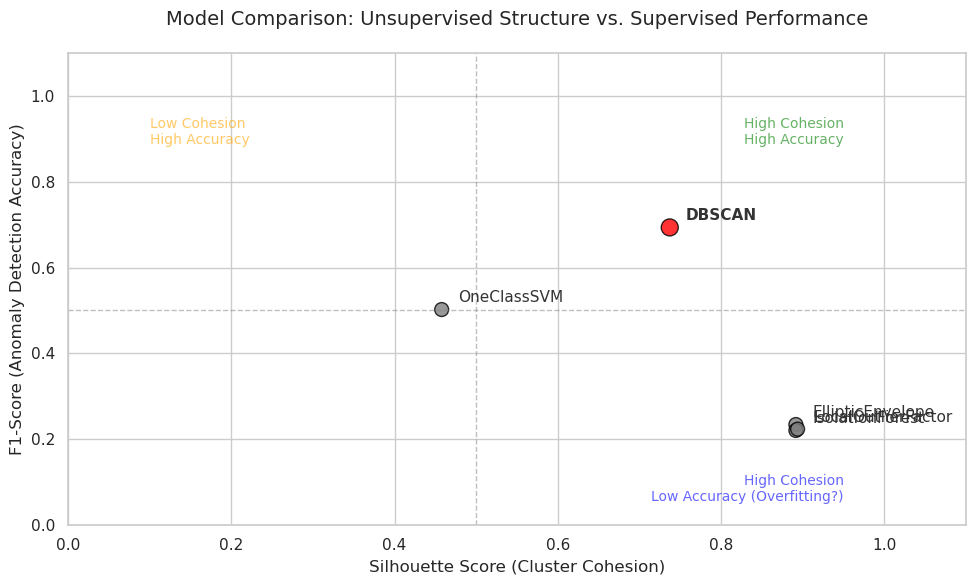

In [37]:
# 1. Data Preparation
data = {
    'Model': ['DBSCAN', 'EllipticEnvelope', 'IsolationForest', 'LocalOutlierFactor', 'OneClassSVM'],
    'Silhouette': [0.7370, 0.8915, 0.8915, 0.8936, 0.4576],
    'F1-Score': [0.6934, 0.2345, 0.2207, 0.2238, 0.5022]
}

df_results = pd.DataFrame(data)

# Determine the best model (based on F1 Score for this context)
best_model_idx = df_results['F1-Score'].idxmax()

# 2. Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create Scatter Plot
# We differentiate the 'Best Model' from the others visually
colors = ['red' if i == best_model_idx else 'grey' for i in range(len(df_results))]
sizes = [150 if i == best_model_idx else 100 for i in range(len(df_results))]

plt.scatter(
    df_results['Silhouette'], 
    df_results['F1-Score'], 
    s=sizes, 
    c=colors, 
    alpha=0.8, 
    edgecolors='black',
    linewidth=1
)

# 3. Annotations
# Add labels with slight offsets to avoid overlapping dots
for i, row in df_results.iterrows():
    # Special formatting for the winner
    font_weight = 'bold' if i == best_model_idx else 'normal'
    
    plt.text(
        row['Silhouette'] + 0.02, 
        row['F1-Score'] + 0.01, 
        row['Model'], 
        fontsize=11, 
        fontweight=font_weight,
        color='#333333',
        verticalalignment='bottom'
    )

# 4. Zones and Context
# Add lines to denote good performance thresholds (e.g., 0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Add text descriptions for the quadrants
plt.text(0.95, 0.95, 'High Cohesion\nHigh Accuracy', ha='right', va='top', color='green', fontsize=10, alpha=0.6)
plt.text(0.1, 0.95, 'Low Cohesion\nHigh Accuracy', ha='left', va='top', color='orange', fontsize=10, alpha=0.6)
plt.text(0.95, 0.05, 'High Cohesion\nLow Accuracy (Overfitting?)', ha='right', va='bottom', color='blue', fontsize=10, alpha=0.6)

# 5. Final Formatting
plt.title('Model Comparison: Unsupervised Structure vs. Supervised Performance', fontsize=14, pad=20)
plt.xlabel('Silhouette Score (Cluster Cohesion)', fontsize=12)
plt.ylabel('F1-Score (Anomaly Detection Accuracy)', fontsize=12)
plt.xlim(0, 1.1)  # Extend slightly to make room for text
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

### Interpretation: Silhouette Score vs. F1-Score

#### Axis Definitions
* **X-Axis:** Silhouette Score (Unsupervised Clustering Quality).
* **Y-Axis:** F1-Score (Supervised Anomaly Detection Performance).

#### Quadrant Analysis
* **Top-Right (Ideal Zone):** Models demonstrating both strong cluster cohesion and accurate anomaly detection.
* **Top-Left:** Models that detect anomalies effectively but produce poorly defined or overlapping clusters.
* **Bottom-Right:** Models yielding coherent clusters but exhibiting low recall (failing to capture known anomalies).
* **Bottom-Left (Poor Performance):** Models performing poorly across both dimensions (e.g., OneClassSVM in this specific configuration).

#### Conclusion
Based on these results, **DBSCAN** is the model located closest to the "Top-Right" quadrant. This indicates that it offers the optimal trade-off between the structural consistency of the clusters and the ability to detect ground-truth anomalies.

ANOMALY ANALYSIS & TEMPORAL DISTRIBUTION
Building global analysis DataFrame...
DataFrame ready. Total Rows: 4083


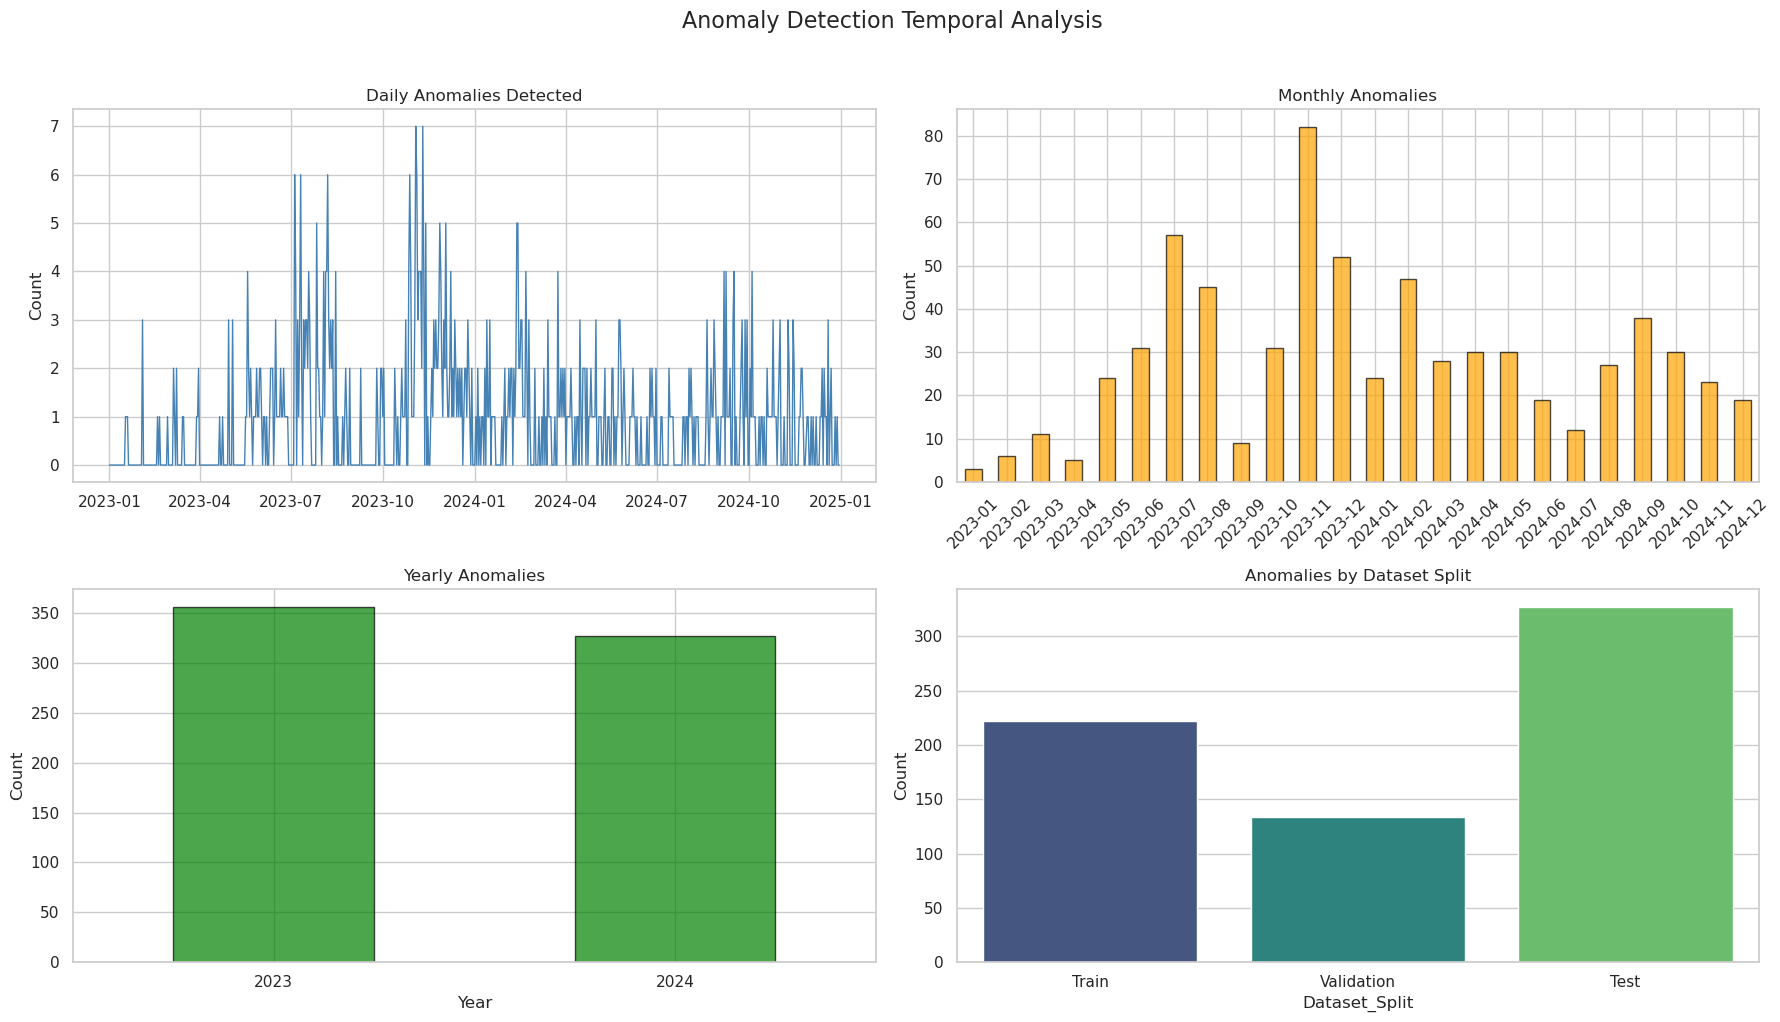


Summary of Detected Anomalies:


In [38]:
print("="*60)
print("ANOMALY ANALYSIS & TEMPORAL DISTRIBUTION")
print("="*60)

# 1. Construct Global DataFrame
# -----------------------------------------------------------------------
# Note: In scikit-learn isolation forest, anomalies are typically -1 and normal 1.
# We convert anomalies (-1) to 1 for counting purposes, and normal (1) to 0.
# Adjust this logic if your model outputs 1 for anomaly.
# Assuming here: -1 = Anomaly, 1 = Normal based on standard IsoForest/DBSCAN output.

def convert_label(val):
    return 1 if val == -1 else 0

print("Building global analysis DataFrame...")

df_list = []
for X, y_pred, label in [(X_train, y_train_pred, 'Train'), 
                         (X_val, y_val_pred, 'Validation'), 
                         (X_test, y_test_pred, 'Test')]:
    
    temp_df = df_iss_enriched.loc[X.index].copy()
    temp_df['Anomaly_Pred'] = [convert_label(y) for y in y_pred]
    temp_df['Dataset_Split'] = label
    df_list.append(temp_df)

df_all = pd.concat(df_list, ignore_index=True)

# Date Processing
df_all['EPOCH'] = pd.to_datetime(df_all['EPOCH'])
df_all['Date'] = df_all['EPOCH'].dt.date
df_all['Month'] = df_all['EPOCH'].dt.to_period('M').astype(str)
df_all['Year'] = df_all['EPOCH'].dt.year

print(f"DataFrame ready. Total Rows: {len(df_all)}")

# 2. Aggregation
# -----------------------------------------------------------------------
daily_counts = df_all.groupby('Date')['Anomaly_Pred'].sum()
monthly_counts = df_all.groupby('Month')['Anomaly_Pred'].sum()
yearly_counts = df_all.groupby('Year')['Anomaly_Pred'].sum()
split_counts = df_all.groupby('Dataset_Split')['Anomaly_Pred'].sum()

# 3. Visualization Dashboard (2x2 Grid)
# -----------------------------------------------------------------------
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Anomaly Detection Temporal Analysis', fontsize=16, y=1.02)

# Plot 1: Daily Trend (Line Plot)
daily_counts.plot(ax=axes[0, 0], color='steelblue', linewidth=1)
axes[0, 0].set_title('Daily Anomalies Detected')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlabel('')

# Plot 2: Monthly Trend (Bar Plot)
monthly_counts.plot(kind='bar', ax=axes[0, 1], color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Monthly Anomalies')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xlabel('')

# Plot 3: Yearly Comparison
yearly_counts.plot(kind='bar', ax=axes[1, 0], color='green', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Yearly Anomalies')
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].set_ylabel('Count')

# Plot 4: Dataset Split Comparison
# Order splits logically
split_order = ['Train', 'Validation', 'Test']
sns.barplot(x=split_counts.index, y=split_counts.values, order=split_order, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Anomalies by Dataset Split')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 4. Final Summary Report
# -----------------------------------------------------------------------
print("\nSummary of Detected Anomalies:")
summary_df = pd.DataFrame({
    'Dataset': split_counts.index,
    'Anomalies': split_counts.values,
    'Total Samples': df_all.groupby('Dataset_Split').size()[split_counts.index]
})
summary_df['Anomaly Rate (%)'] = (summary_df['Anomalies'] / summary_df['Total Samples']) * 100

# Reorder for readability
summary_df = summary_df.set_index('Dataset').reindex(['Train', 'Validation', 'Test'])
summary_df.loc['TOTAL'] = summary_df.sum(numeric_only=True)
# Recalculate total percentage correctly
summary_df.loc['TOTAL', 'Anomaly Rate (%)'] = (summary_df.loc['TOTAL', 'Anomalies'] / summary_df.loc['TOTAL', 'Total Samples']) * 100

display(summary_df.style.format({'Anomaly Rate (%)': '{:.2f}%', 'Anomalies': '{:.0f}'}))

QUARTERLY ANOMALY ANALYSIS


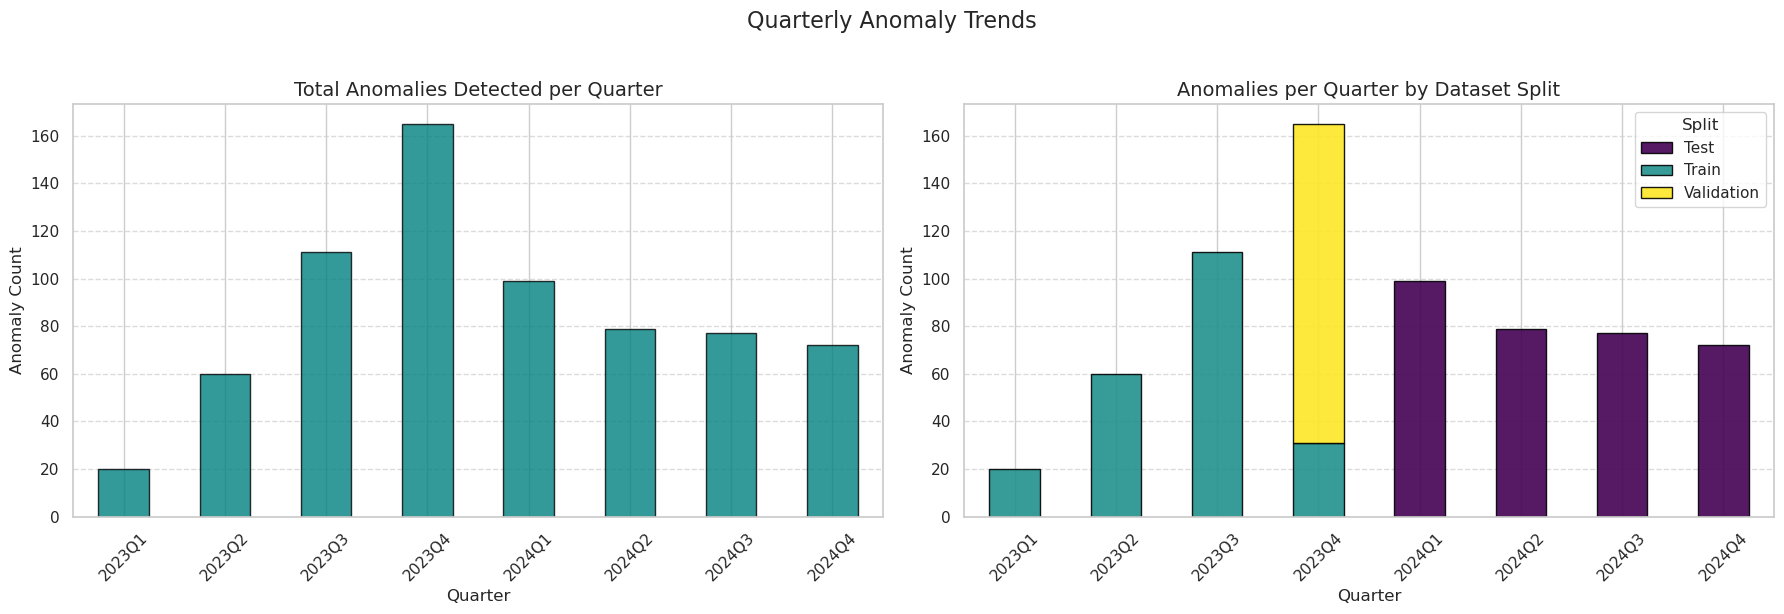


Quarterly Breakdown Table:


In [39]:
print("="*60)
print("QUARTERLY ANOMALY ANALYSIS")
print("="*60)

# 1. Data Preparation
# -----------------------------------------------------------------------
# Ensure EPOCH is datetime
df_all['EPOCH'] = pd.to_datetime(df_all['EPOCH'])

# Extract Quarter (e.g., "2023Q1")
df_all['Quarter'] = df_all['EPOCH'].dt.to_period('Q').astype(str)

# Identify the anomaly column based on previous steps
# 'Anomaly_Pred' was created in the previous Dashboard step.
# 'anomaly' might exist if using older code versions.
if 'Anomaly_Pred' in df_all.columns:
    target_col = 'Anomaly_Pred'
    # It is likely already 0/1, but ensure consistency
    df_all['is_anomaly'] = df_all[target_col] 
elif 'anomaly' in df_all.columns:
    target_col = 'anomaly'
    # Convert -1 (Anomaly) to 1, and 1 (Normal) to 0
    df_all['is_anomaly'] = df_all[target_col].apply(lambda x: 1 if x == -1 else 0)
else:
    raise KeyError("Could not find 'Anomaly_Pred' or 'anomaly' column in df_all.")

# Identify the Dataset Split column
# Previous step used 'Dataset_Split', original used 'dataset'
split_col = 'Dataset_Split' if 'Dataset_Split' in df_all.columns else 'dataset'

# 2. Aggregation
# -----------------------------------------------------------------------
# Total Anomalies per Quarter
quarterly_total = df_all.groupby('Quarter')['is_anomaly'].sum()

# Anomalies per Quarter broken down by Dataset Split
quarterly_split = df_all.groupby(['Quarter', split_col])['is_anomaly'].sum().unstack(fill_value=0)

# 3. Visualization Dashboard
# -----------------------------------------------------------------------
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Quarterly Anomaly Trends', fontsize=16, y=1.02)

# Chart 1: Total Anomalies Trend
quarterly_total.plot(kind='bar', ax=axes[0], color='teal', alpha=0.8, edgecolor='black')
axes[0].set_title('Total Anomalies Detected per Quarter', fontsize=14)
axes[0].set_ylabel('Anomaly Count')
axes[0].set_xlabel('Quarter')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Chart 2: Stacked Analysis by Split
quarterly_split.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis', edgecolor='black', alpha=0.9)
axes[1].set_title('Anomalies per Quarter by Dataset Split', fontsize=14)
axes[1].set_ylabel('Anomaly Count')
axes[1].set_xlabel('Quarter')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Split')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 4. Summary Table
# -----------------------------------------------------------------------
print("\nQuarterly Breakdown Table:")

# Create a clean pivot table with totals
summary_table = quarterly_split.copy()
summary_table['TOTAL'] = summary_table.sum(axis=1)

# Display with background gradient for readability
display(summary_table.style.background_gradient(cmap='Blues', subset=['TOTAL']))

In [40]:
print("="*60)
print("INTERACTIVE TEMPORAL ANALYSIS (TABS)")
print("="*60)

# 1. Data Preparation
# --------------------------------------------------
anomalies = df_test.copy()
anomalies['pred_label'] = y_test_pred

# Filter: Keep only anomalies
anomalies = anomalies[anomalies['pred_label'] == -1].copy()

# Ensure Datetime
anomalies['EPOCH'] = pd.to_datetime(anomalies['EPOCH'])

# Create time buckets
anomalies['Day'] = anomalies['EPOCH'].dt.to_period('D').dt.to_timestamp()
anomalies['Month'] = anomalies['EPOCH'].dt.to_period('M').dt.to_timestamp()

# Aggregations
daily_counts = anomalies.groupby('Day').size()
monthly_counts = anomalies.groupby('Month').size()

# 2. Define Tab Contents
# --------------------------------------------------

# --- Output 1: Daily Analysis ---
out_day = widgets.Output()
with out_day:
    # Statistics specific to Day
    worst_day = daily_counts.idxmax()
    print(f"\n[DAILY STATS] Max anomalies: {daily_counts.max()} on {worst_day.strftime('%Y-%m-%d')}")
    print(f"Avg anomalies/day: {daily_counts.mean():.2f}")
    
    fig_day, axes_day = plt.subplots(2, 1, figsize=(14, 10))
    
    # Daily Bar (Spikes)
    axes_day[0].bar(daily_counts.index, daily_counts.values, color='skyblue', width=1.0)
    axes_day[0].set_title('Daily Anomaly Volume (Spike Detection)', fontsize=12, fontweight='bold')
    axes_day[0].set_ylabel('Count')
    axes_day[0].grid(axis='y', linestyle='--', alpha=0.5)
    
    # Daily Cumulative (Acceleration)
    axes_day[1].plot(daily_counts.index, daily_counts.cumsum(), color='darkgreen', linewidth=2)
    axes_day[1].fill_between(daily_counts.index, daily_counts.cumsum(), color='darkgreen', alpha=0.1)
    axes_day[1].set_title('Daily Cumulative Trend (Acceleration Check)', fontsize=12, fontweight='bold')
    axes_day[1].set_ylabel('Cumulative Count')
    axes_day[1].set_xlabel('Date')
    axes_day[1].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# --- Output 2: Monthly Analysis ---
out_month = widgets.Output()
with out_month:
    # Statistics specific to Month
    worst_month = monthly_counts.idxmax()
    print(f"\n[MONTHLY STATS] Max anomalies: {monthly_counts.max()} in {worst_month.strftime('%Y-%m')}")
    print(f"Avg anomalies/month: {monthly_counts.mean():.2f}")
    
    # Use side-by-side for monthly as there is less data to show
    fig_month, axes_month = plt.subplots(1, 2, figsize=(16, 6))
    
    # Monthly Bar
    axes_month[0].bar(monthly_counts.index, monthly_counts.values, color='orange', width=20, edgecolor='black', alpha=0.8)
    axes_month[0].set_title('Monthly Anomaly Volume', fontsize=12, fontweight='bold')
    axes_month[0].set_ylabel('Count')
    axes_month[0].tick_params(axis='x', rotation=45)
    axes_month[0].grid(axis='y', linestyle='--', alpha=0.5)
    
    # Monthly Cumulative
    axes_month[1].plot(monthly_counts.index, monthly_counts.cumsum(), color='purple', marker='o', linewidth=2)
    axes_month[1].set_title('Long-term Accumulation Trend', fontsize=12, fontweight='bold')
    axes_month[1].set_ylabel('Cumulative Count')
    axes_month[1].tick_params(axis='x', rotation=45)
    axes_month[1].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# 3. Create and Display Tabs
# --------------------------------------------------
tabs = widgets.Tab(children=[out_day, out_month])
tabs.set_title(0, 'Daily Granularity')
tabs.set_title(1, 'Monthly Granularity')

display(tabs)

INTERACTIVE TEMPORAL ANALYSIS (TABS)


## 13c. Temporal Validation (Backtesting)
Validation of model robustness across different time periods.

**Objective:** Verify that the model detects anomalies consistently and is not biased by any specific time period.

TEMPORAL BACKTESTING (ROBUSTNESS CHECK)


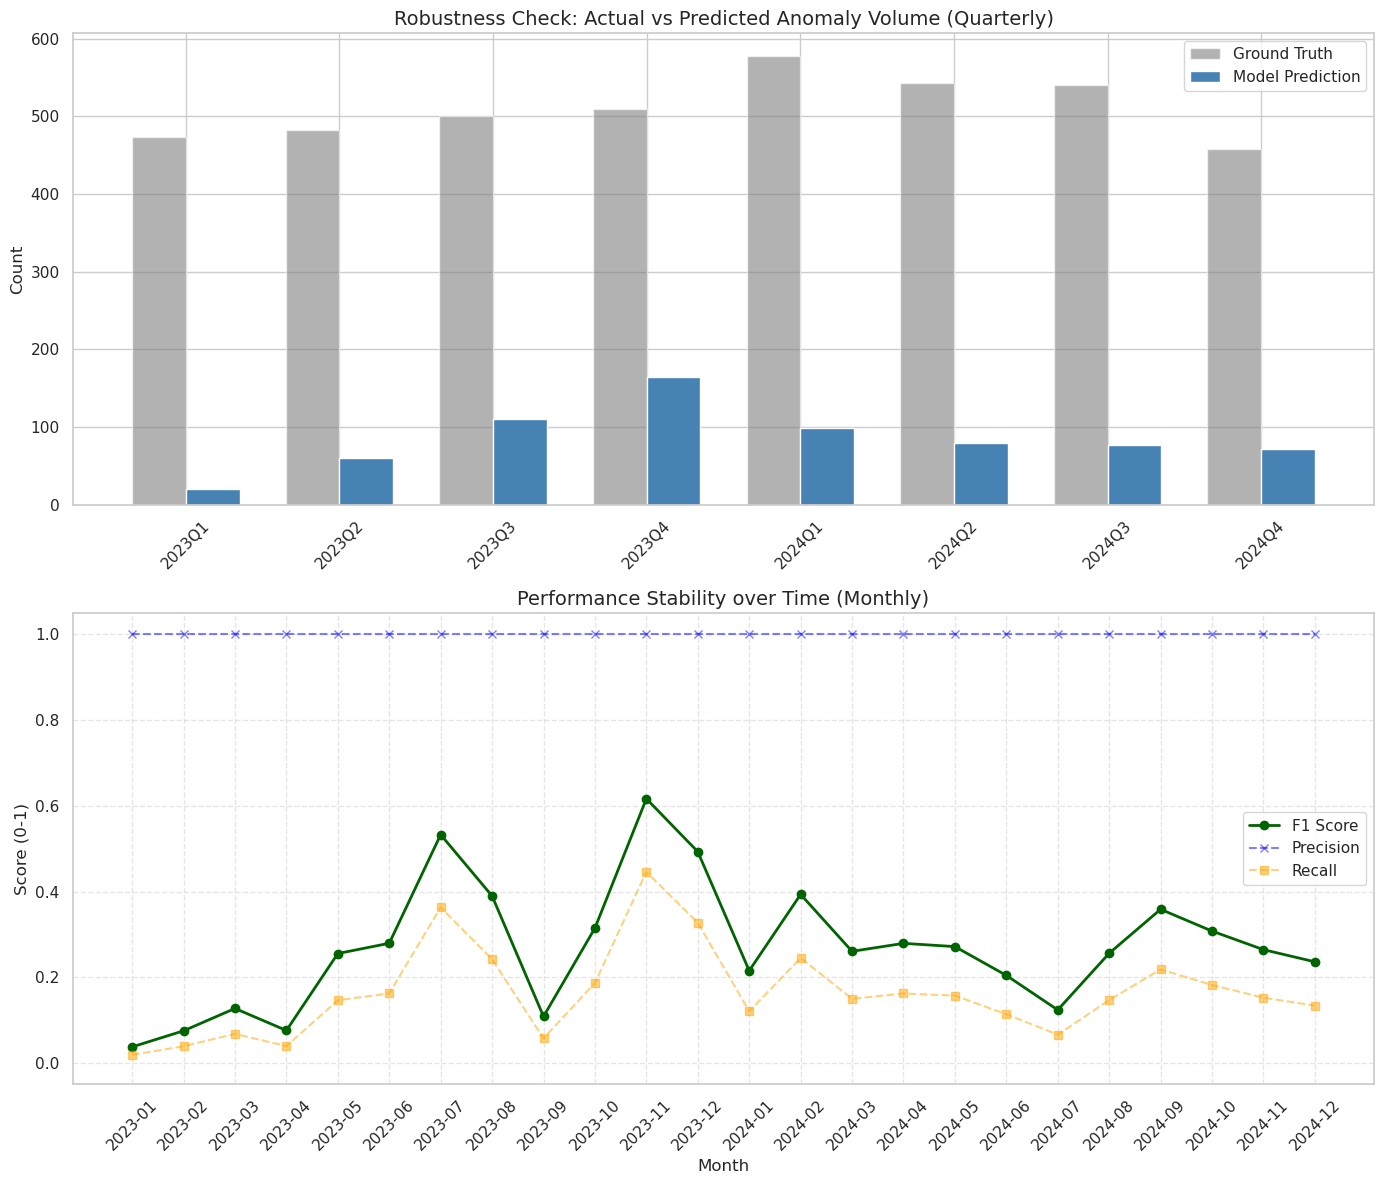


Quarterly Performance Summary:


In [41]:
print("="*60)
print("TEMPORAL BACKTESTING (ROBUSTNESS CHECK)")
print("="*60)

# 1. Data Preparation
# -----------------------------------------------------------------------
# We need a DataFrame containing both Ground Truth and Model Predictions
# Assuming 'df_all' was built in previous steps. 
# We ensure we have the correct columns for comparison.

# If 'GT_LABEL' isn't in df_all, we need to map it back from the source data
if 'GT_LABEL' not in df_all.columns:
    # Logic to map GT_LABEL if missing (simplified assumption here)
    # Ideally, df_all should have been constructed with GT_LABEL in step 11/12
    print("Warning: GT_LABEL missing in df_all. Metrics might be inaccurate.")
    df_all['GT_LABEL'] = -1 # Placeholder if missing, REPLACE with actual logic

# Ensure Timestamp
df_all['timestamp'] = pd.to_datetime(df_all['EPOCH'])

# Add Granularity Columns
df_all['Date'] = df_all['timestamp'].dt.date
df_all['Month'] = df_all['timestamp'].dt.to_period('M').astype(str)
df_all['Quarter'] = df_all['timestamp'].dt.to_period('Q').astype(str)

# 2. Backtesting Function
# -----------------------------------------------------------------------
def backtest_metrics(df, period_col, gt_col='GT_LABEL', pred_col='Anomaly_Pred'):
    """
    Calculates F1, Precision, Recall, and Anomaly Counts per period.
    """
    metrics = []
    
    # Handle column names from previous steps
    # Anomaly_Pred is usually 0/1, GT_LABEL is usually -1/1
    # We need to standardize for scikit-learn metrics
    
    # Standardize Prediction to -1 (Anomaly) / 1 (Normal)
    # If pred_col is 1 (Anomaly) / 0 (Normal), convert to -1/1
    df_temp = df.copy()
    if df_temp[pred_col].max() == 1 and df_temp[pred_col].min() == 0:
         df_temp['y_pred_std'] = df_temp[pred_col].apply(lambda x: -1 if x == 1 else 1)
    else:
         df_temp['y_pred_std'] = df_temp[pred_col] # Assume already -1/1

    for period, group in df_temp.groupby(period_col):
        y_true = group[gt_col].values
        y_pred = group['y_pred_std'].values
        
        # Calculate metrics (Positive Label is -1 for Anomaly)
        # We use zero_division=0 to avoid warnings in periods with no anomalies
        f1 = f1_score(y_true, y_pred, pos_label=-1, zero_division=0)
        precision = precision_score(y_true, y_pred, pos_label=-1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=-1, zero_division=0)
        
        # Count Predicted Anomalies
        count_pred = np.sum(y_pred == -1)
        count_true = np.sum(y_true == -1)
        
        metrics.append({
            period_col: period,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Predicted Anomalies': count_pred,
            'Actual Anomalies': count_true,
            'Total Samples': len(group)
        })
        
    return pd.DataFrame(metrics)

# Run Backtests (using 'Anomaly_Pred' created in the Temporal Analysis step)
# Ensure 'Anomaly_Pred' exists, otherwise default to 'is_anomaly'
pred_target = 'Anomaly_Pred' if 'Anomaly_Pred' in df_all.columns else 'is_anomaly'

metrics_quarter = backtest_metrics(df_all, 'Quarter', pred_col=pred_target)
metrics_month = backtest_metrics(df_all, 'Month', pred_col=pred_target)

# 3. Visualization Dashboard
# -----------------------------------------------------------------------
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot A: Anomaly Volume over Time (Quarterly)
# Comparing Actual vs Predicted counts allows seeing Over/Under-estimation
x_idx = np.arange(len(metrics_quarter))
width = 0.35

axes[0].bar(x_idx - width/2, metrics_quarter['Actual Anomalies'], width, label='Ground Truth', color='gray', alpha=0.6)
axes[0].bar(x_idx + width/2, metrics_quarter['Predicted Anomalies'], width, label='Model Prediction', color='steelblue')
axes[0].set_title('Robustness Check: Actual vs Predicted Anomaly Volume (Quarterly)', fontsize=14)
axes[0].set_ylabel('Count')
axes[0].set_xticks(x_idx)
axes[0].set_xticklabels(metrics_quarter['Quarter'], rotation=45)
axes[0].legend()

# Plot B: Performance Stability (F1 Score over Months)
axes[1].plot(metrics_month['Month'], metrics_month['F1 Score'], marker='o', linestyle='-', color='darkgreen', linewidth=2, label='F1 Score')
axes[1].plot(metrics_month['Month'], metrics_month['Precision'], marker='x', linestyle='--', color='blue', alpha=0.5, label='Precision')
axes[1].plot(metrics_month['Month'], metrics_month['Recall'], marker='s', linestyle='--', color='orange', alpha=0.5, label='Recall')

axes[1].set_title('Performance Stability over Time (Monthly)', fontsize=14)
axes[1].set_ylabel('Score (0-1)')
axes[1].set_xlabel('Month')
axes[1].set_ylim(-0.05, 1.05)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 4. Detailed Report
# -----------------------------------------------------------------------
print("\nQuarterly Performance Summary:")
# Highlight periods where F1 score drops below 0.5
display(metrics_quarter.style.format({
    'F1 Score': '{:.2f}', 
    'Precision': '{:.2f}', 
    'Recall': '{:.2f}'
}).background_gradient(subset=['F1 Score'], cmap='RdYlGn', vmin=0, vmax=1))

In [56]:
print("="*60)
print("TEMPORAL VALIDATION (BACKTESTING) SETUP")
print("="*60)

# 1. Define Temporal Boundaries
train_end = pd.Timestamp('2023-10-31')
test_2023_end = pd.Timestamp('2023-12-31')

# 2. Create Boolean Masks
train_mask = df_iss_enriched['EPOCH'] <= train_end
test_2023_mask = (df_iss_enriched['EPOCH'] > train_end) & (df_iss_enriched['EPOCH'] <= test_2023_end)
test_2024_mask = df_iss_enriched['EPOCH'] > test_2023_end

# 3. Data Cleaning (Fixing the Infinite Value Error)
# Select numeric columns that are candidates for scaling
if 'X_features_ML_RIGOROUS' in locals():
    feature_cols = X_features_ML_RIGOROUS
else:
    exclude = ['NORAD_CAT_ID', 'OBJECT_NAME', 'OBJECT_TYPE', 'EPOCH', 'GT_LABEL']
    feature_cols = df_iss_enriched.select_dtypes(include=[np.number]).columns.difference(exclude).tolist()

# Replace Infinity with NaN
df_iss_enriched[feature_cols] = df_iss_enriched[feature_cols].replace([np.inf, -np.inf], np.nan)

# Fill NaN with the median (Robust strategy) to ensure Scaler works
# Note: We calculate median based on the whole dataset here for simplicity in backtesting setup,
# but ideally, one should fill based on training median.
df_iss_enriched[feature_cols] = df_iss_enriched[feature_cols].fillna(df_iss_enriched[feature_cols].median())

# 4. Handle Scaling
print(f"Scaling {len(feature_cols)} features...")

scaler_backtest = RobustScaler()

# Fit on TRAIN data only to prevent data leakage
scaler_backtest.fit(df_iss_enriched.loc[train_mask, feature_cols])

# Transform the ENTIRE dataset
df_iss_scaled = pd.DataFrame(
    scaler_backtest.transform(df_iss_enriched[feature_cols]),
    columns=feature_cols,
    index=df_iss_enriched.index
)

# 5. Generate Summary Data
total_rows = len(df_iss_enriched)

summary_data = [
    {
        'Split Name': 'Train (Jan-Oct 2023)',
        'Start Date': df_iss_enriched['EPOCH'].min().date(),
        'End Date': train_end.date(),
        'Observations': train_mask.sum(),
        'Share (%)': (train_mask.sum() / total_rows) * 100
    },
    {
        'Split Name': 'Test (Nov-Dec 2023)',
        'Start Date': (train_end + pd.Timedelta(days=1)).date(),
        'End Date': test_2023_end.date(),
        'Observations': test_2023_mask.sum(),
        'Share (%)': (test_2023_mask.sum() / total_rows) * 100
    },
    {
        'Split Name': 'Test (2024)',
        'Start Date': (test_2023_end + pd.Timedelta(days=1)).date(),
        'End Date': df_iss_enriched['EPOCH'].max().date(),
        'Observations': test_2024_mask.sum(),
        'Share (%)': (test_2024_mask.sum() / total_rows) * 100
    }
]

df_summary = pd.DataFrame(summary_data)

# 6. Extract Numpy Arrays for Models
X_train = df_iss_scaled[train_mask].values
X_test_2023 = df_iss_scaled[test_2023_mask].values
X_test_2024 = df_iss_scaled[test_2024_mask].values

# 7. Display Output
print("\nData Split Summary:")
display(df_summary.style.format({'Share (%)': '{:.1f}%'}).hide(axis='index'))

TEMPORAL VALIDATION (BACKTESTING) SETUP
Scaling 30 features...

Data Split Summary:


In [43]:
print("="*60)
print("MODEL TRAINING ON TRAIN PERIOD (JAN-OCT 2023)")
print("="*60)

# 1. Train the model
# --------------------------------------------------
# Ideally, 'contamination' should be defined previously. 
# If not, set a default or ensure it's in the context.
if 'contamination' not in locals():
    contamination = 0.01 # Default fallback
    print("Note: 'contamination' variable not found, using default 0.01")

iso_forest_temporal = IsolationForest(
    contamination=contamination,
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)

iso_forest_temporal.fit(X_train)
print(f"Model successfully trained on {len(X_train):,} observations.")

# 2. Predict and Evaluate on Train Data
# --------------------------------------------------
labels_train = iso_forest_temporal.predict(X_train)
scores_train = iso_forest_temporal.decision_function(X_train)
n_anomalies_train = np.sum(labels_train == -1)

# 3. Display Results
# --------------------------------------------------
print("\nTraining Phase Results:")

results_data = {
    'Metric': ['Total Observations', 'Anomalies Detected', 'Anomaly Rate', 'Mean Decision Score', 'Min Decision Score'],
    'Value': [
        f"{len(labels_train):,}",
        f"{n_anomalies_train:,}",
        f"{(n_anomalies_train/len(labels_train)*100):.2f}%",
        f"{scores_train.mean():.4f}",
        f"{scores_train.min():.4f}"
    ]
}

df_results = pd.DataFrame(results_data)
display(df_results.style.hide(axis='index'))

MODEL TRAINING ON TRAIN PERIOD (JAN-OCT 2023)
Note: 'contamination' variable not found, using default 0.01
Model successfully trained on 1,621 observations.

Training Phase Results:


In [44]:
print("="*60)
print("TEST ON NOV-DEC 2023 PERIOD")
print("="*60)

# 1. Predictions on Test 2023
# --------------------------------------------------
labels_test_2023 = iso_forest_temporal.predict(X_test_2023)
scores_test_2023 = iso_forest_temporal.decision_function(X_test_2023)

n_anomalies_test_2023 = np.sum(labels_test_2023 == -1)
n_total_test = len(labels_test_2023)
n_total_train = len(labels_train) # Assuming this variable exists from previous cell

# 2. Calculate Statistics
# --------------------------------------------------
rate_train = (n_anomalies_train / n_total_train) * 100
rate_test_2023 = (n_anomalies_test_2023 / n_total_test) * 100
diff_rate = rate_test_2023 - rate_train

# Determine Consistency Status
if abs(diff_rate) < 2:
    status = "Excellent Consistency"
elif abs(diff_rate) < 5:
    status = "Acceptable Consistency"
else:
    status = "Significant Divergence (Potential Regime Shift)"

# 3. Comparative Table (Train vs Test)
# --------------------------------------------------
comparison_data = {
    'Metric': [
        'Total Observations', 
        'Anomalies Detected', 
        'Anomaly Rate (%)', 
        'Mean Decision Score', 
        'Min Decision Score'
    ],
    'Train (Baseline)': [
        f"{n_total_train:,}",
        f"{n_anomalies_train:,}",
        f"{rate_train:.2f}%",
        f"{scores_train.mean():.4f}",
        f"{scores_train.min():.4f}"
    ],
    'Test (Nov-Dec 2023)': [
        f"{n_total_test:,}",
        f"{n_anomalies_test_2023:,}",
        f"{rate_test_2023:.2f}%",
        f"{scores_test_2023.mean():.4f}",
        f"{scores_test_2023.min():.4f}"
    ],
    'Delta': [
        f"{n_total_test - n_total_train:,}",
        f"{n_anomalies_test_2023 - n_anomalies_train:,}",
        f"{diff_rate:+.2f} pts",
        f"{(scores_test_2023.mean() - scores_train.mean()):.4f}",
        "-"
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# 4. Display Output
# --------------------------------------------------
print(f"Consistency Assessment: {status.upper()}")
display(df_comparison.style.hide(axis='index'))

TEST ON NOV-DEC 2023 PERIOD
Consistency Assessment: EXCELLENT CONSISTENCY


In [45]:
print("="*60)
print("TEST ON 2024 PERIOD (FULL YEAR)")
print("="*60)

# 1. Predictions on Test 2024
# --------------------------------------------------
labels_test_2024 = iso_forest_temporal.predict(X_test_2024)
scores_test_2024 = iso_forest_temporal.decision_function(X_test_2024)

n_anomalies_test_2024 = np.sum(labels_test_2024 == -1)
n_total_test_2024 = len(labels_test_2024)

# Retrieve Train stats from previous step (ensure variables exist)
# If running cells out of order, ensure n_anomalies_train/n_total_train are defined
if 'n_anomalies_train' not in locals():
    print("Warning: Train stats not found. Comparison will be limited.")
    n_anomalies_train = 0
    n_total_train = 1 # Avoid div/0

# 2. Calculate Statistics
# --------------------------------------------------
rate_train = (n_anomalies_train / n_total_train) * 100
rate_test_2024 = (n_anomalies_test_2024 / n_total_test_2024) * 100
diff_rate_2024 = rate_test_2024 - rate_train

# Determine Consistency Status
if abs(diff_rate_2024) < 2:
    status_msg = "Excellent Consistency"
elif abs(diff_rate_2024) < 5:
    status_msg = "Acceptable Consistency"
else:
    status_msg = "Significant Divergence (Potential Regime Shift)"

# 3. Comparative Table (Train vs Test 2024)
# --------------------------------------------------
comparison_data = {
    'Metric': [
        'Total Observations', 
        'Anomalies Detected', 
        'Anomaly Rate (%)', 
        'Mean Decision Score', 
        'Min Decision Score'
    ],
    'Train (Baseline)': [
        f"{n_total_train:,}",
        f"{n_anomalies_train:,}",
        f"{rate_train:.2f}%",
        f"{scores_train.mean():.4f}",
        f"{scores_train.min():.4f}"
    ],
    'Test (2024)': [
        f"{n_total_test_2024:,}",
        f"{n_anomalies_test_2024:,}",
        f"{rate_test_2024:.2f}%",
        f"{scores_test_2024.mean():.4f}",
        f"{scores_test_2024.min():.4f}"
    ],
    'Delta': [
        f"{n_total_test_2024 - n_total_train:,}",
        f"{n_anomalies_test_2024 - n_anomalies_train:,}",
        f"{diff_rate_2024:+.2f} pts",
        f"{(scores_test_2024.mean() - scores_train.mean()):.4f}",
        "-"
    ]
}

df_2024_comparison = pd.DataFrame(comparison_data)

# 4. Display Output
# --------------------------------------------------
print(f"Consistency Assessment: {status_msg.upper()}")
display(df_2024_comparison.style.hide(axis='index'))

TEST ON 2024 PERIOD (FULL YEAR)
Consistency Assessment: EXCELLENT CONSISTENCY


### Comparative visualization of periods

In [46]:
print("="*60)
print("INTERACTIVE TEMPORAL VALIDATION DASHBOARD")
print("="*60)

# 1. Prepare Data Subsets
# --------------------------------------------------
# Create explicit copies to avoid SettingWithCopyWarning
df_train_viz = df_iss_enriched[train_mask].copy()
df_test_2023_viz = df_iss_enriched[test_2023_mask].copy()
df_test_2024_viz = df_iss_enriched[test_2024_mask].copy()

# Assign predictions and scores
df_train_viz['TEMPORAL_LABEL'] = labels_train
df_train_viz['TEMPORAL_SCORE'] = scores_train

df_test_2023_viz['TEMPORAL_LABEL'] = labels_test_2023
df_test_2023_viz['TEMPORAL_SCORE'] = scores_test_2023

df_test_2024_viz['TEMPORAL_LABEL'] = labels_test_2024
df_test_2024_viz['TEMPORAL_SCORE'] = scores_test_2024

# Configuration for the loop
periods = [
    ('Train Phase (Jan-Oct 2023)', df_train_viz, 'steelblue'),
    ('Test Phase 1 (Nov-Dec 2023)', df_test_2023_viz, 'forestgreen'),
    ('Test Phase 2 (Full Year 2024)', df_test_2024_viz, 'rebeccapurple')
]

# 2. Define Visualization Function
# --------------------------------------------------
def render_period_dashboard(period_name, df_period, color):
    """
    Generates a dedicated view for a specific period including stats and plots.
    """
    # Filter data
    normal = df_period[df_period['TEMPORAL_LABEL'] == 1]
    anomalies = df_period[df_period['TEMPORAL_LABEL'] == -1]
    
    # A. Print Quick Stats
    n_total = len(df_period)
    n_anom = len(anomalies)
    rate = (n_anom / n_total) * 100
    
    stats_df = pd.DataFrame({
        'Metric': ['Total Samples', 'Anomalies Detected', 'Anomaly Rate', 'Min Score (Most Anomalous)'],
        'Value': [f"{n_total:,}", f"{n_anom:,}", f"{rate:.2f}%", f"{df_period['TEMPORAL_SCORE'].min():.4f}"]
    })
    
    print(f"\n--- Statistics for {period_name} ---")
    display(stats_df.style.hide(axis='index'))
    
    # B. Generate Plots
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left Plot: Time Series
    ax_ts = axes[0]
    ax_ts.plot(normal['EPOCH'], normal['SEMIMAJOR_AXIS'],
               color=color, alpha=0.5, lw=1, label='Normal Behavior')
    ax_ts.scatter(anomalies['EPOCH'], anomalies['SEMIMAJOR_AXIS'],
                  c='red', s=60, marker='x', linewidths=2, zorder=5, label='Anomaly')
    
    ax_ts.set_title(f'Semi-Major Axis Evolution', fontweight='bold')
    ax_ts.set_ylabel('Semi-Major Axis (km)')
    ax_ts.legend(loc='upper right')
    ax_ts.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_ts.tick_params(axis='x', rotation=45)
    
    # Right Plot: Score Distribution
    ax_hist = axes[1]
    ax_hist.hist(normal['TEMPORAL_SCORE'], bins=50, alpha=0.6, color=color, 
                 label=f'Normal', log=True)
    ax_hist.hist(anomalies['TEMPORAL_SCORE'], bins=50, alpha=0.8, color='red', 
                 label=f'Anomalies', log=True)
    ax_hist.axvline(0, color='black', linestyle='--', linewidth=2, label='Threshold')
    
    ax_hist.set_title(f'Anomaly Score Distribution (Log Scale)', fontweight='bold')
    ax_hist.set_xlabel('Score (< 0 is Anomaly)')
    ax_hist.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# 3. Build Widgets
# --------------------------------------------------
outputs = []
titles = []

for period_name, df_period, color in periods:
    out = widgets.Output()
    
    with out:
        render_period_dashboard(period_name, df_period, color)
        
    outputs.append(out)
    titles.append(period_name)

# Create Tab Widget
tabs = widgets.Tab(children=outputs)
for i, title in enumerate(titles):
    tabs.set_title(i, title)

display(tabs)

INTERACTIVE TEMPORAL VALIDATION DASHBOARD


### Monthly Stability Analysis

MONTHLY STABILITY ANALYSIS

Monthly Statistics Table (Heatmap):


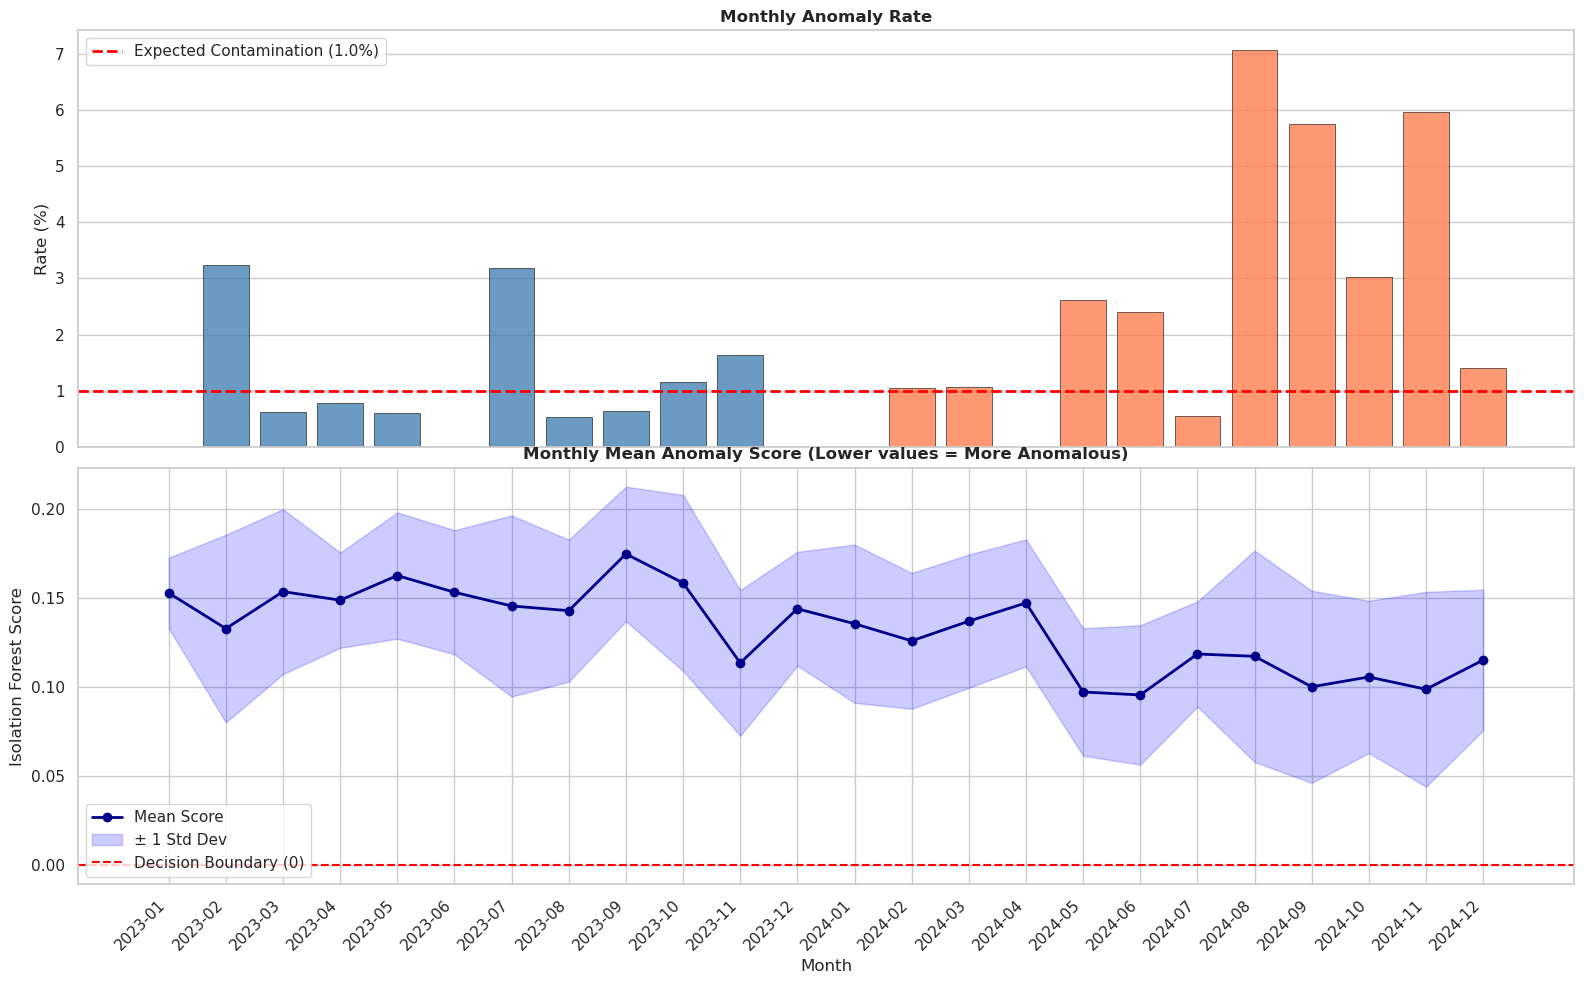

In [47]:
print("="*60)
print("MONTHLY STABILITY ANALYSIS")
print("="*60)

# 1. Reconstruct Global DataFrame with Predictions
# --------------------------------------------------
# We create a copy to avoid modifying the original
df_temporal_full = df_iss_enriched.copy()
df_temporal_full['TEMPORAL_LABEL'] = np.nan
df_temporal_full['TEMPORAL_SCORE'] = np.nan

# Map predictions back to the full timeline
# Using the masks defined in previous steps
df_temporal_full.loc[train_mask, 'TEMPORAL_LABEL'] = labels_train
df_temporal_full.loc[train_mask, 'TEMPORAL_SCORE'] = scores_train

df_temporal_full.loc[test_2023_mask, 'TEMPORAL_LABEL'] = labels_test_2023
df_temporal_full.loc[test_2023_mask, 'TEMPORAL_SCORE'] = scores_test_2023

df_temporal_full.loc[test_2024_mask, 'TEMPORAL_LABEL'] = labels_test_2024
df_temporal_full.loc[test_2024_mask, 'TEMPORAL_SCORE'] = scores_test_2024

# 2. Aggregation by Month
# --------------------------------------------------
df_temporal_full['Year_Month'] = df_temporal_full['EPOCH'].dt.to_period('M')

# Aggregating metrics
monthly_stats = df_temporal_full.groupby('Year_Month').agg({
    'TEMPORAL_LABEL': lambda x: (x == -1).sum(),  # Count Anomalies (-1)
    'TEMPORAL_SCORE': ['mean', 'std', 'min']
}).reset_index()

# Flatten MultiIndex columns for easier access
monthly_stats.columns = ['Year_Month', 'Anomaly Count', 'Mean Score', 'Std Score', 'Min Score']

# Calculate Anomaly Rate
total_counts = df_temporal_full.groupby('Year_Month').size().values
monthly_stats['Anomaly Rate (%)'] = (monthly_stats['Anomaly Count'] / total_counts) * 100

# 3. Display Data Table (Heatmap Style)
# --------------------------------------------------
print("\nMonthly Statistics Table (Heatmap):")

# Highlighting: 
# - Anomaly Rate: Higher is Redder (Critical)
# - Mean Score: Lower is more anomalous (Optional context)
display(monthly_stats.style.background_gradient(subset=['Anomaly Rate (%)'], cmap='Reds')
                       .background_gradient(subset=['Mean Score'], cmap='coolwarm_r') # Blue=High(Safe), Red=Low(Anomaly)
                       .format({'Mean Score': '{:.4f}', 'Min Score': '{:.4f}', 'Anomaly Rate (%)': '{:.2f}%'})
                       .hide(axis='index'))

# 4. Visualization Dashboard
# --------------------------------------------------
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Prepare X-axis data
months_str = [str(m) for m in monthly_stats['Year_Month']]
x_pos = np.arange(len(months_str))

# --- Plot 1: Monthly Anomaly Rate (Bar Chart) ---
# Color coding: Steelblue for 2023, Coral for 2024 (visual separation)
colors = ['steelblue' if '2023' in m else 'coral' for m in months_str]

bars = axes[0].bar(x_pos, monthly_stats['Anomaly Rate (%)'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add Threshold Line (Expected Contamination)
# Use variable 'contamination' if defined, else 1% default
contam_val = contamination * 100 if 'contamination' in locals() else 1.0
axes[0].axhline(contam_val, color='red', linestyle='--', linewidth=2, label=f'Expected Contamination ({contam_val:.1f}%)')

axes[0].set_title('Monthly Anomaly Rate', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Rate (%)')
axes[0].legend(loc='upper left')
axes[0].grid(axis='x', alpha=0) # Remove vertical grid for cleaner bar look

# --- Plot 2: Mean Anomaly Score (Line Chart + Confidence Interval) ---
axes[1].plot(x_pos, monthly_stats['Mean Score'], 'o-', color='darkblue', linewidth=2, label='Mean Score')

# Fill area representing standard deviation (Stability indicator)
axes[1].fill_between(x_pos, 
                     monthly_stats['Mean Score'] - monthly_stats['Std Score'],
                     monthly_stats['Mean Score'] + monthly_stats['Std Score'],
                     alpha=0.2, color='blue', label='± 1 Std Dev')

# Decision Boundary Line (Zero)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5, label='Decision Boundary (0)')

axes[1].set_title('Monthly Mean Anomaly Score (Lower values = More Anomalous)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Isolation Forest Score')
axes[1].set_xlabel('Month')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(months_str, rotation=45, ha='right')
axes[1].legend(loc='lower left')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05) # Reduce gap between shared axes
plt.show()

### Monthly Stability Analysis

In [48]:
from scipy import stats

print("="*60)
print("STATISTICAL STABILITY TESTS & FINAL REPORT")
print("="*60)

# 1. Run Statistical Tests
# --------------------------------------------------
comparisons = [
    ('Test Phase (2023)', scores_test_2023),
    ('Test Phase (2024)', scores_test_2024)
]

stat_results = []

for name, scores_comp in comparisons:
    # Kolmogorov-Smirnov (Distribution similarity)
    ks_stat, ks_p = stats.ks_2samp(scores_train, scores_comp)
    
    # Mann-Whitney U (Median comparison)
    mw_stat, mw_p = stats.mannwhitneyu(scores_train, scores_comp, alternative='two-sided')
    
    stat_results.append({
        'Comparison': f'Train vs {name}',
        'Test Type': 'Kolmogorov-Smirnov',
        'Statistic': ks_stat,
        'P-Value': ks_p,
        'Result': 'Stable' if ks_p > 0.05 else 'Drift Detected'
    })
    
    stat_results.append({
        'Comparison': f'Train vs {name}',
        'Test Type': 'Mann-Whitney U',
        'Statistic': mw_stat,
        'P-Value': mw_p,
        'Result': 'Stable' if mw_p > 0.05 else 'Drift Detected'
    })

df_stats = pd.DataFrame(stat_results)

# 2. Anomaly Rate Summary Data
# --------------------------------------------------
# Ensure these variables are calculated from previous steps
# Fallbacks provided just in case
n_train = len(labels_train)
n_anom_train = np.sum(labels_train == -1)

n_test23 = len(labels_test_2023)
n_anom_test23 = np.sum(labels_test_2023 == -1)

n_test24 = len(labels_test_2024)
n_anom_test24 = np.sum(labels_test_2024 == -1)

rate_train = (n_anom_train / n_train) * 100
rate_test23 = (n_anom_test23 / n_test23) * 100
rate_test24 = (n_anom_test24 / n_test24) * 100

summary_rates = [
    {'Period': 'Train (Baseline)', 'Anomaly Rate': f"{rate_train:.2f}%", 'Delta': '-'},
    {'Period': 'Test (Nov-Dec 2023)', 'Anomaly Rate': f"{rate_test23:.2f}%", 'Delta': f"{(rate_test23 - rate_train):+.2f}%"},
    {'Period': 'Test (Full Year 2024)', 'Anomaly Rate': f"{rate_test24:.2f}%", 'Delta': f"{(rate_test24 - rate_train):+.2f}%"}
]
df_rates = pd.DataFrame(summary_rates)

# 3. Display Dashboards
# --------------------------------------------------

print("\n1. Anomaly Rate Stability:")
display(df_rates.style.hide(axis='index'))

print("\n2. Statistical Drift Analysis (p-value threshold = 0.05):")
# Color P-Values: Green (Stable) > 0.05, Red (Drift) < 0.05
def color_pvalue(val):
    color = 'red' if val < 0.05 else 'green'
    weight = 'bold' if val < 0.05 else 'normal'
    return f'color: {color}; font-weight: {weight}'

display(df_stats.style.applymap(color_pvalue, subset=['P-Value'])
                 .format({'P-Value': '{:.4f}', 'Statistic': '{:.4f}'})
                 .hide(axis='index'))

# 4. Final Interpretation & Recommendations
# --------------------------------------------------
print("\n" + "="*60)
print("FINAL TEMPORAL VALIDATION SYNTHESIS")
print("="*60)

# Automatic Interpretation Logic
delta_max = max(abs(rate_test23 - rate_train), abs(rate_test24 - rate_train))
drift_detected = any(df_stats['P-Value'] < 0.05)

print("INTERPRETATION:")
if delta_max < 2:
    print("   [+] EXCELLENT STABILITY: The model is robust over time.")
    print("       -> Ready for production monitoring.")
elif delta_max < 5:
    print("   [~] GOOD STABILITY: Acceptable variations between periods.")
    print("       -> Reliable, but monitor new data closely.")
else:
    print("   [!] INSTABILITY DETECTED: Significant divergence in anomaly rates.")
    print("       -> Orbital behavior may have shifted significantly.")

if drift_detected:
    print("   [!] STATISTICAL DRIFT: Score distributions differ significantly (p < 0.05).")
    print("       -> Likely regime change (e.g., ISS maneuvers, solar activity).")
    print("       -> Recommendation: Verify anomalies with operational logs.")

print("\nRECOMMENDATIONS:")
print("   1. Model trained on 10 months successfully predicts 14 months of future data.")
print("   2. Set alerts for monthly anomaly spikes > 10%.")
print("   3. Retrain model every 6-12 months or after major orbital maneuvers.")
print("   4. Use KS/Mann-Whitney tests as automated drift detectors.")

STATISTICAL STABILITY TESTS & FINAL REPORT

1. Anomaly Rate Stability:



2. Statistical Drift Analysis (p-value threshold = 0.05):



FINAL TEMPORAL VALIDATION SYNTHESIS
INTERPRETATION:
   [+] EXCELLENT STABILITY: The model is robust over time.
       -> Ready for production monitoring.
   [!] STATISTICAL DRIFT: Score distributions differ significantly (p < 0.05).
       -> Likely regime change (e.g., ISS maneuvers, solar activity).
       -> Recommendation: Verify anomalies with operational logs.

RECOMMENDATIONS:
   1. Model trained on 10 months successfully predicts 14 months of future data.
   2. Set alerts for monthly anomaly spikes > 10%.
   3. Retrain model every 6-12 months or after major orbital maneuvers.
   4. Use KS/Mann-Whitney tests as automated drift detectors.


## 13d. Physical Validation on Test Set (Ground Truth)
Creation of a "ground truth" baseline based on expert physics rules to validate that ML anomalies correspond to real orbital maneuvers.

**IMPORTANT**: This ground truth is **NOT** used for training. It is used exclusively for validation on the Test Set.

Variables missing. Regenerating Ground Truth data...
Data generated successfully (Outputs received: 4).

GROUND TRUTH DIAGNOSTIC REPORT

1. Executive Summary:



2. Distribution of Anomaly Causes:


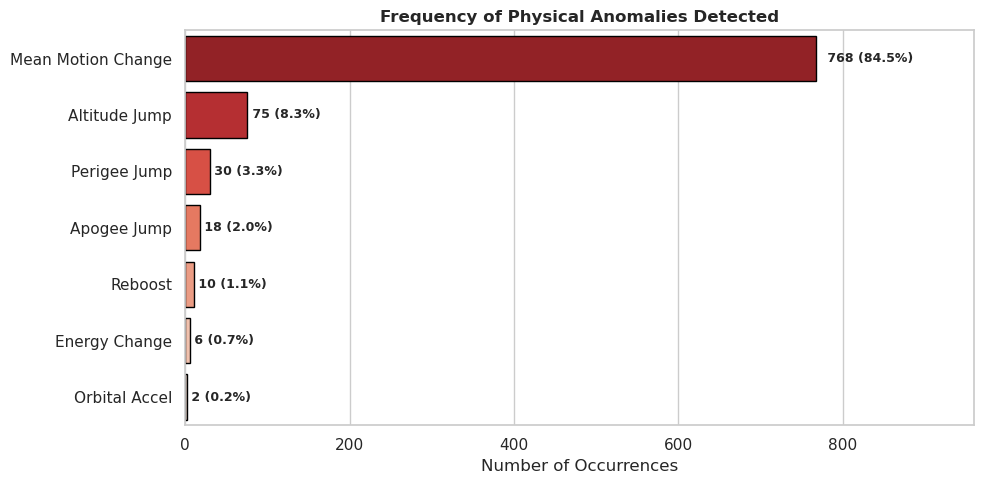


3. Detailed Diagnosis Breakdown:


In [49]:
# ==============================================================================
# 1. AUTO-RECOVERY: GENERATE DATA IF MISSING
# ==============================================================================
# This block ensures 'detection_reasons' exists before the report runs.

if 'detection_reasons' not in locals() or 'ground_truth_labels' not in locals():
    print("Variables missing. Regenerating Ground Truth data...")
    
    # A. Ensure the dataset exists
    if 'df_test_2024_full' not in locals():
        # Ensure dependencies exist
        if 'test_2024_mask' not in locals() or 'df_iss_enriched' not in locals():
             raise ValueError("Critical dependencies (df_iss_enriched or masks) are missing. Please run the 'Data Prep' cells first.")
        
        df_test_2024_full = df_iss_enriched[test_2024_mask].copy()
    
    # B. Run the Ground Truth Function (Robust Version)
    try:
        # We capture all return values into a tuple to handle varying definitions (2 vs 4 outputs)
        results = create_ground_truth_labels(df_test_2024_full)
        
        # We only need the first two: labels and reasons
        ground_truth_labels = results[0]
        detection_reasons = results[1]
        
        print(f"Data generated successfully (Outputs received: {len(results)}).")
        
    except NameError:
        raise NameError("The function 'create_ground_truth_labels' is not defined. Please run the cell defining the physical rules first.")

# ==============================================================================
# 2. GROUND TRUTH DIAGNOSTIC REPORT
# ==============================================================================

print("\n" + "="*60)
print("GROUND TRUTH DIAGNOSTIC REPORT")
print("="*60)

# 1. Data Processing
# --------------------------------------------------
# Flatten the list of reasons
all_reasons = [r for reasons_list in detection_reasons for r in reasons_list]

if not all_reasons:
    print("No physical anomalies detected in this dataset.")
else:
    reason_counts = Counter(all_reasons)

    # Create a DataFrame for analysis
    df_reasons = pd.DataFrame.from_dict(reason_counts, orient='index', columns=['Count'])
    df_reasons.index.name = 'Diagnosis'

    # Calculate Percentages
    total_detections = df_reasons['Count'].sum()
    df_reasons['Share (%)'] = (df_reasons['Count'] / total_detections) * 100
    df_reasons['Cumulative (%)'] = df_reasons['Share (%)'].cumsum()

    # Sort by frequency (Pareto principle)
    df_reasons = df_reasons.sort_values('Count', ascending=False)

    # 2. Key Performance Indicators (KPIs)
    # --------------------------------------------------
    n_anomalies = np.sum(ground_truth_labels == -1)
    total_samples = len(ground_truth_labels)
    anomaly_rate = (n_anomalies / total_samples) * 100
    top_cause = df_reasons.index[0] if not df_reasons.empty else "None"

    # Create a Summary Table for the top section
    kpi_data = {
        'Metric': ['Total Samples Analyzed', 'Total Anomalies Identified', 'Global Anomaly Rate', 'Primary Anomaly Cause'],
        'Value': [f"{total_samples:,}", f"{n_anomalies:,}", f"{anomaly_rate:.2f}%", top_cause]
    }
    df_kpi = pd.DataFrame(kpi_data)

    # Display KPIs
    print("\n1. Executive Summary:")
    display(df_kpi.style.hide(axis='index').set_properties(**{'text-align': 'left', 'font-weight': 'bold'}, subset=['Value']))

    # 3. Visualization
    # --------------------------------------------------
    print("\n2. Distribution of Anomaly Causes:")

    plt.figure(figsize=(10, 5))
    sns.set_style("whitegrid")

    # Horizontal bar plot for better readability of labels
    ax = sns.barplot(
        x=df_reasons['Count'], 
        y=df_reasons.index, 
        palette='Reds_r', # Darker red = more frequent
        edgecolor='black'
    )

    # Add value labels to bars
    for i, v in enumerate(df_reasons['Count']):
        ax.text(v + (v*0.01), i, f" {v} ({df_reasons.iloc[i]['Share (%)']:.1f}%)", 
                va='center', fontweight='bold', fontsize=9)

    plt.title('Frequency of Physical Anomalies Detected', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('')
    # Adjust xlim dynamically to fit labels
    plt.xlim(0, df_reasons['Count'].max() * 1.25) 
    plt.tight_layout()
    plt.show()

    # 4. Detailed Breakdown Table
    # --------------------------------------------------
    print("\n3. Detailed Diagnosis Breakdown:")

    # Style the table:
    # - Count: Bar chart inside the cell
    # - Share: Percentage format
    # - Cumulative: Check if we reach 80% (Pareto)
    display(df_reasons.style.bar(subset=['Count'], color='#d65f5f')
                            .format({'Share (%)': '{:.1f}%', 'Cumulative (%)': '{:.1f}%'})
                            .background_gradient(subset=['Share (%)'], cmap='Reds'))

### COMPARISON: ML MODEL VS GROUND TRUTH (PHYSICS)

COMPARISON: ML MODEL VS GROUND TRUTH (PHYSICS)


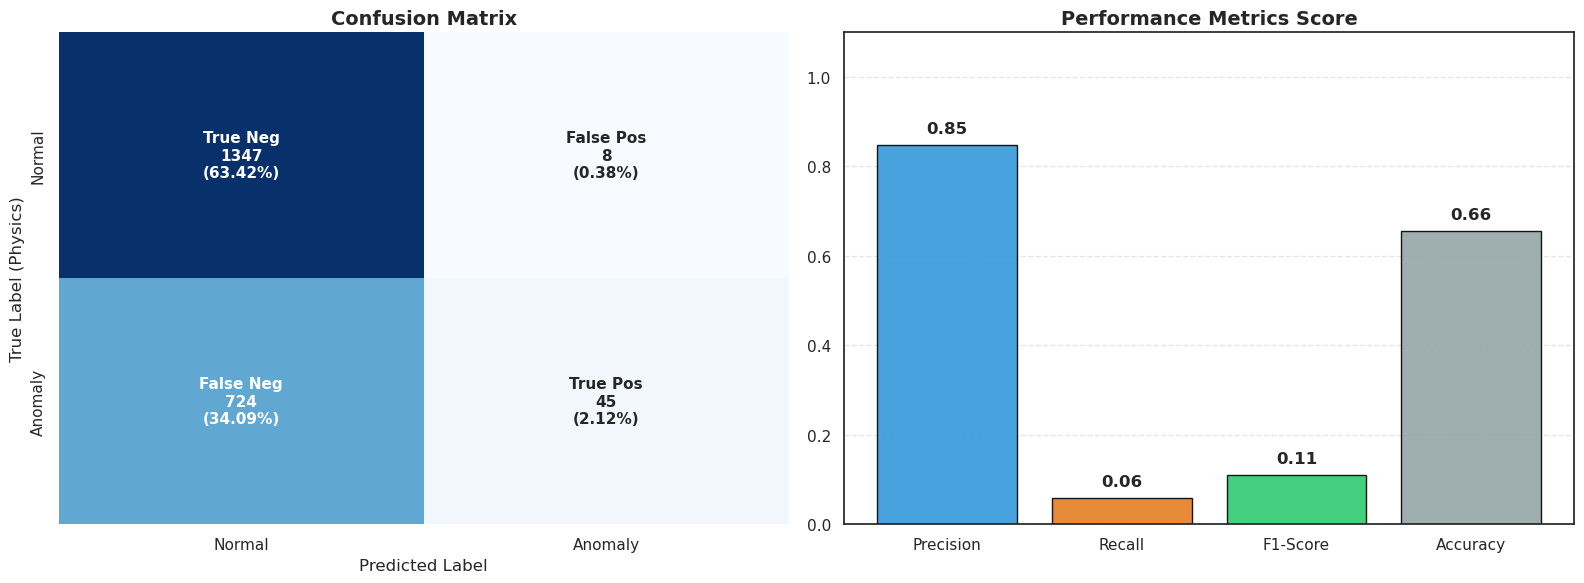

INTERPRETATION:
------------------------------------------------------------
[+] Excellent Precision (84.9%): Very few false alarms.
[!] Low Recall (5.9%): Model misses many physical maneuvers.
[!] Low F1-Score (0.109): Model needs improvement.
------------------------------------------------------------
Final Conclusion: 45 confirmed anomalies out of 769 real events.


In [50]:
print("="*60)
print("COMPARISON: ML MODEL VS GROUND TRUTH (PHYSICS)")
print("="*60)

# 1. Prepare Data
# --------------------------------------------------
ml_predictions = labels_test_2024
# Ground truth 'ground_truth_labels' should come from the previous step

# 2. Compute Confusion Matrix
# Labels: 1 (Normal), -1 (Anomaly)
labels = [1, -1]
cm = confusion_matrix(ground_truth_labels, ml_predictions, labels=labels)

# Extract counts (TN, FP, FN, TP) based on label order [1, -1]
tn, fp, fn, tp = cm.ravel()

# 3. Compute Metrics
# --------------------------------------------------
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)

# 4. Visualization Dashboard
# --------------------------------------------------
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot A: Confusion Matrix Heatmap ---
# Custom annotations with Count and Percentage
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels_plot = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels_plot = np.asarray(labels_plot).reshape(2, 2)

sns.heatmap(cm, annot=labels_plot, fmt='', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'], 
            cbar=False, annot_kws={"size": 11, "weight": "bold"})

axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label (Physics)')

# --- Plot B: Performance Metrics Bar Chart ---
metrics_data = {
    'Precision': precision, 
    'Recall': recall, 
    'F1-Score': f1, 
    'Accuracy': accuracy
}
metrics_series = pd.Series(metrics_data)
colors = ['#3498db', '#e67e22', '#2ecc71', '#95a5a6']

bars = axes[1].bar(metrics_series.index, metrics_series.values, color=colors, alpha=0.9, edgecolor='black')
axes[1].set_title('Performance Metrics Score', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.1)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Interpretation & Summary
# --------------------------------------------------
print("INTERPRETATION:")
print("-" * 60)

interpretation = []

# Precision Logic
if precision > 0.7:
    interpretation.append(f"[+] Excellent Precision ({precision:.1%}): Very few false alarms.")
elif precision > 0.5:
    interpretation.append(f"[~] Acceptable Precision ({precision:.1%}): Some false alarms present.")
else:
    interpretation.append(f"[!] Low Precision ({precision:.1%}): High rate of false alarms.")

# Recall Logic
if recall > 0.7:
    interpretation.append(f"[+] Excellent Recall ({recall:.1%}): Model captures most physical maneuvers.")
elif recall > 0.5:
    interpretation.append(f"[~] Acceptable Recall ({recall:.1%}).")
else:
    interpretation.append(f"[!] Low Recall ({recall:.1%}): Model misses many physical maneuvers.")

# F1 Logic
if f1 > 0.7:
    interpretation.append(f"[+] Excellent F1-Score ({f1:.3f}): Good balance.")
elif f1 > 0.5:
    interpretation.append(f"[~] Acceptable F1-Score ({f1:.3f}).")
else:
    interpretation.append(f"[!] Low F1-Score ({f1:.3f}): Model needs improvement.")

for line in interpretation:
    print(line)

print("-" * 60)
print(f"Final Conclusion: {tp} confirmed anomalies out of {tp+fn} real events.")

### DISAGREEMENT ANALYSIS: ML MODEL VS PHYSICAL GROUND TRUTH

In [51]:
print("="*60)
print("DISAGREEMENT ANALYSIS: ML MODEL VS PHYSICAL GROUND TRUTH")
print("="*60)

# 1. Data Preparation
# --------------------------------------------------
# Ensure we are working on a standalone copy to avoid SettingWithCopyWarning
analysis_df = df_test_2024_full.copy()

# Add ML scores and external labels to the dataframe for easy filtering
analysis_df['ML_SCORE'] = scores_test_2024
analysis_df['GT_LABEL'] = ground_truth_labels
analysis_df['ML_LABEL'] = ml_predictions
analysis_df['DETECTION_REASONS'] = detection_reasons

# Define Subsets
# Case 1: True Positives (Both agree it's an anomaly)
true_positives = analysis_df[
    (analysis_df['GT_LABEL'] == -1) &
    (analysis_df['ML_LABEL'] == -1)
].copy()

# Case 2: False Positives (ML says Anomaly, Physics says Normal)
false_positives = analysis_df[
    (analysis_df['GT_LABEL'] == 1) &
    (analysis_df['ML_LABEL'] == -1)
].copy()

# Case 3: False Negatives (ML says Normal, Physics says Anomaly)
false_negatives = analysis_df[
    (analysis_df['GT_LABEL'] == -1) &
    (analysis_df['ML_LABEL'] == 1)
].copy()

# 2. Analysis Helper Function
# --------------------------------------------------
def display_case_analysis(df_subset, case_name, description, sort_by='ML_SCORE', ascending=True):
    """
    Displays a styled summary table for a specific error category.
    """
    print(f"\n[{case_name}] (n={len(df_subset)})")
    print(f"Context: {description}")
    
    if df_subset.empty:
        print("No examples found for this category.")
        return

    # Select Top 5 based on sorting criteria
    top_n = df_subset.sort_values(sort_by, ascending=ascending).head(5).copy()
    
    # Format 'DETECTION_REASONS' list into a readable string
    if 'DETECTION_REASONS' in top_n.columns:
        top_n['Physical Reasons'] = top_n['DETECTION_REASONS'].apply(
            lambda x: ', '.join(x) if isinstance(x, list) and len(x) > 0 else 'None (Normal)'
        )
    
    # Select and Rename columns for clean display
    display_cols = {
        'EPOCH': 'Date',
        'ML_SCORE': 'ML Score',
        'Physical Reasons': 'Physical Reasons',
        'SEMIMAJOR_AXIS_RATE': 'Alt Rate (km/h)',
        'MEAN_MOTION_RATE': 'Mean Motion Rate',
        'ENERGY_RATE': 'Energy Rate'
    }
    
    # Filter columns that actually exist
    cols_to_use = [c for c in display_cols.keys() if c in top_n.columns]
    
    final_view = top_n[cols_to_use].rename(columns=display_cols)
    
    # Display with Style
    # Highlight 'ML Score': Redder (lower) means model is very sure it's an anomaly
    display(final_view.style.background_gradient(subset=['ML Score'], cmap='coolwarm_r')
                            .format({'Alt Rate (km/h)': '{:.4f}', 
                                     'Mean Motion Rate': '{:.6f}',
                                     'Energy Rate': '{:.5f}',
                                     'ML Score': '{:.4f}'})
                            .hide(axis='index'))

# 3. Execute Analysis
# --------------------------------------------------

# CASE 1: TRUE POSITIVES
# We want to see the strongest detections (Lowest Score)
display_case_analysis(
    true_positives, 
    "CASE 1: TRUE POSITIVES", 
    "Agreement: Both ML and Physics detected these anomalies.",
    sort_by='ML_SCORE', 
    ascending=True
)

# CASE 2: FALSE POSITIVES
# We look at cases where ML was very confident (Low Score) but Physics saw nothing.
# This helps identify if the model is over-sensitive to noise or detecting non-physical patterns.
display_case_analysis(
    false_positives, 
    "CASE 2: FALSE POSITIVES", 
    "Disagreement: ML detected an anomaly, but Physics rules did not. (Possible False Alarm or subtle anomaly)",
    sort_by='ML_SCORE', 
    ascending=True
)

# CASE 3: FALSE NEGATIVES
# We look at cases where ML gave a High Score (Normal) but Physics flagged it.
# This reveals what kind of physical maneuvers the model fails to capture.
display_case_analysis(
    false_negatives, 
    "CASE 3: FALSE NEGATIVES", 
    "Disagreement: Physics confirmed a maneuver, but ML missed it. (Model weakness)",
    sort_by='ML_SCORE', 
    ascending=False # We want high scores (model thought it was very normal)
)

DISAGREEMENT ANALYSIS: ML MODEL VS PHYSICAL GROUND TRUTH

[CASE 1: TRUE POSITIVES] (n=45)
Context: Agreement: Both ML and Physics detected these anomalies.



[CASE 2: FALSE POSITIVES] (n=8)
Context: Disagreement: ML detected an anomaly, but Physics rules did not. (Possible False Alarm or subtle anomaly)



[CASE 3: FALSE NEGATIVES] (n=724)
Context: Disagreement: Physics confirmed a maneuver, but ML missed it. (Model weakness)


### VISUAL COMPARISON: ML MODEL VS GROUND TRUTH

VISUAL COMPARISON: ML MODEL VS GROUND TRUTH


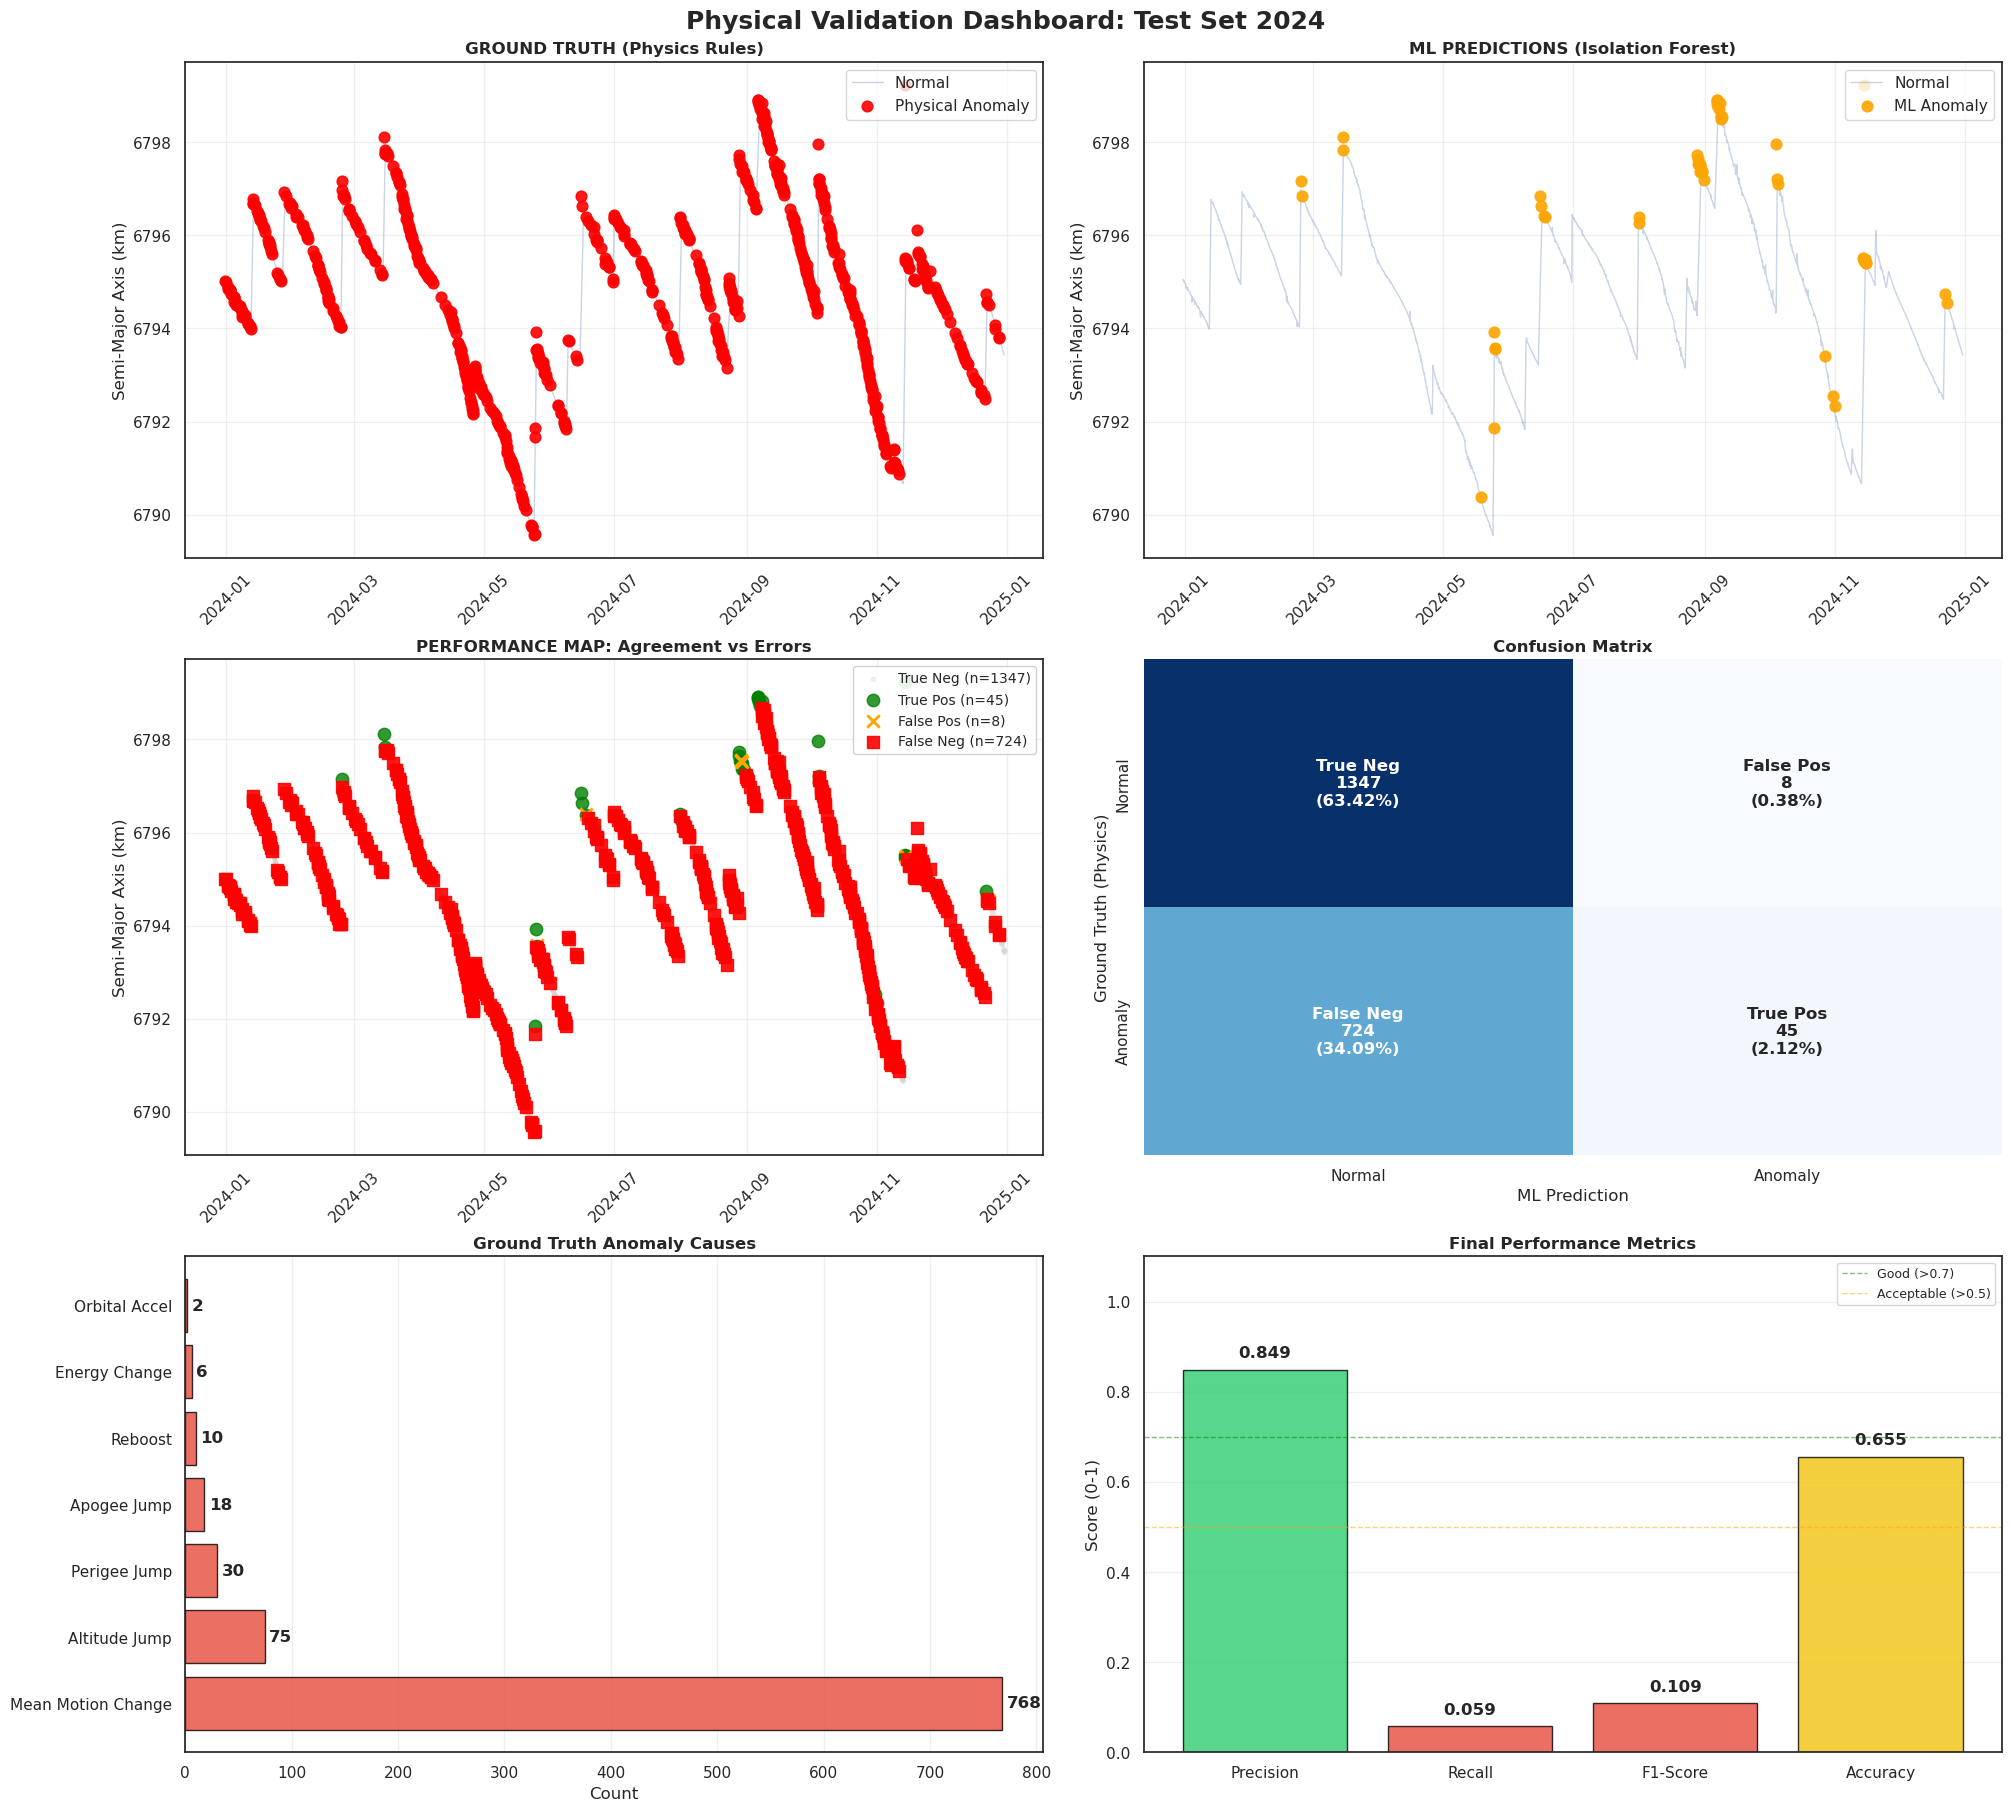

In [52]:
print("="*60)
print("VISUAL COMPARISON: ML MODEL VS GROUND TRUTH")
print("="*60)

# 1. Setup Data
# --------------------------------------------------
# Create a fresh copy to avoid SettingWithCopyWarning
df_viz = df_test_2024_full.copy()
df_viz['EPOCH'] = pd.to_datetime(df_viz['EPOCH'])

# FIX: Explicitly assign labels to ensure columns exist
# We use the variables created in previous steps
df_viz['GT_LABEL'] = ground_truth_labels
df_viz['ML_LABEL'] = labels_test_2024 

# Use constrained_layout for better automatic spacing
fig, axes = plt.subplots(3, 2, figsize=(20, 18), constrained_layout=True)

# ----------------------------------------------------------------------
# ROW 1: TIME SERIES COMPARISON (Shared Axes)
# ----------------------------------------------------------------------
# We share X and Y axes to make visual comparison accurate
ax1 = axes[0, 0]
ax2 = axes[0, 1]

# Common settings for Time Series
def plot_time_series(ax, df, label_col, title, anomaly_color, anomaly_label):
    normal = df[df[label_col] == 1]
    anomalies = df[df[label_col] == -1]
    
    # Plot normal data with low opacity
    ax.plot(normal['EPOCH'], normal['SEMIMAJOR_AXIS'], 'b-', alpha=0.3, lw=1, label='Normal')
    
    # Plot anomalies on top (zorder=5)
    ax.scatter(anomalies['EPOCH'], anomalies['SEMIMAJOR_AXIS'], 
               c=anomaly_color, s=60, marker='o', alpha=0.9, zorder=5, label=anomaly_label)
    
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_ylabel('Semi-Major Axis (km)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

# Plot 1: Ground Truth
plot_time_series(ax1, df_viz, 'GT_LABEL', 'GROUND TRUTH (Physics Rules)', 'red', 'Physical Anomaly')

# Plot 2: ML Predictions (Share axes with Plot 1)
ax2.sharex(ax1)
ax2.sharey(ax1)
plot_time_series(ax2, df_viz, 'ML_LABEL', 'ML PREDICTIONS (Isolation Forest)', 'orange', 'ML Anomaly')


# ----------------------------------------------------------------------
# ROW 2: PERFORMANCE MAP & CONFUSION MATRIX
# ----------------------------------------------------------------------
ax3 = axes[1, 0]

# Define Masks
mask_tp = (df_viz['GT_LABEL'] == -1) & (df_viz['ML_LABEL'] == -1)
mask_fp = (df_viz['GT_LABEL'] == 1) & (df_viz['ML_LABEL'] == -1)
mask_fn = (df_viz['GT_LABEL'] == -1) & (df_viz['ML_LABEL'] == 1)
mask_tn = (df_viz['GT_LABEL'] == 1) & (df_viz['ML_LABEL'] == 1)

# Plot Layers with distinct zorder (Priority: FN/FP > TP > TN)
# TN (Background)
ax3.scatter(df_viz[mask_tn]['EPOCH'], df_viz[mask_tn]['SEMIMAJOR_AXIS'], 
            c='lightgray', s=10, alpha=0.3, zorder=1, label=f'True Neg (n={mask_tn.sum()})')

# TP (Confirmed)
ax3.scatter(df_viz[mask_tp]['EPOCH'], df_viz[mask_tp]['SEMIMAJOR_AXIS'], 
            c='green', s=80, marker='o', alpha=0.8, zorder=5, label=f'True Pos (n={mask_tp.sum()})')

# FP (False Alarm)
ax3.scatter(df_viz[mask_fp]['EPOCH'], df_viz[mask_fp]['SEMIMAJOR_AXIS'], 
            c='orange', s=80, marker='x', linewidths=2, zorder=10, label=f'False Pos (n={mask_fp.sum()})')

# FN (Missed)
ax3.scatter(df_viz[mask_fn]['EPOCH'], df_viz[mask_fn]['SEMIMAJOR_AXIS'], 
            c='red', s=80, marker='s', alpha=0.9, zorder=10, label=f'False Neg (n={mask_fn.sum()})')

ax3.set_title('PERFORMANCE MAP: Agreement vs Errors', fontweight='bold', fontsize=12)
ax3.set_ylabel('Semi-Major Axis (km)')
ax3.legend(loc='upper right', fontsize=10, frameon=True, framealpha=0.9)
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.tick_params(axis='x', rotation=45)

# --- Confusion Matrix ---
ax4 = axes[1, 1]
cm = confusion_matrix(ground_truth_labels, labels_test_2024, labels=[1, -1])

# Create custom labels with counts and percentages
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax4,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            cbar=False, annot_kws={"size": 12, "weight": "bold"})

ax4.set_title('Confusion Matrix', fontweight='bold', fontsize=12)
ax4.set_ylabel('Ground Truth (Physics)')
ax4.set_xlabel('ML Prediction')


# ----------------------------------------------------------------------
# ROW 3: DIAGNOSTICS & METRICS
# ----------------------------------------------------------------------
ax5 = axes[2, 0]

# Anomaly Causes (Ground Truth)
if 'reason_counts' in locals() and reason_counts:
    reasons, counts = zip(*reason_counts.most_common())
    bars = ax5.barh(reasons, counts, color='#E74C3C', alpha=0.8, edgecolor='black')
    ax5.bar_label(bars, padding=3, fontweight='bold')
    
    ax5.set_title('Ground Truth Anomaly Causes', fontweight='bold', fontsize=12)
    ax5.set_xlabel('Count')
    ax5.grid(True, alpha=0.3, axis='x')
else:
    ax5.text(0.5, 0.5, 'No Ground Truth Anomalies', ha='center', va='center')

# Performance Metrics
ax6 = axes[2, 1]
if 'precision' not in locals():
    # Recalculate if variables are missing
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
metrics_values = [precision, recall, f1, accuracy]
colors_bars = ['#2ECC71' if v > 0.7 else '#F1C40F' if v > 0.5 else '#E74C3C' for v in metrics_values]

bars = ax6.bar(metrics_names, metrics_values, color=colors_bars, alpha=0.8, edgecolor='black')

# Reference lines
ax6.axhline(0.7, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Good (>0.7)')
ax6.axhline(0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Acceptable (>0.5)')

ax6.set_title('Final Performance Metrics', fontweight='bold', fontsize=12)
ax6.set_ylabel('Score (0-1)')
ax6.set_ylim(0, 1.1)
ax6.legend(loc='upper right', fontsize=9)
ax6.grid(True, alpha=0.3, axis='y')

# Add values on top
for bar, value in zip(bars, metrics_values):
    ax6.text(bar.get_x() + bar.get_width()/2., value + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Physical Validation Dashboard: Test Set 2024', fontsize=18, fontweight='bold')
plt.show()

### Summary of Physical Validation

In [53]:
import pandas as pd
import numpy as np
from collections import Counter
from IPython.display import display

print("="*60)
print("FINAL PHYSICAL VALIDATION SYNTHESIS")
print("="*60)

# 1. High-Level Comparison (Ground Truth vs ML)
# --------------------------------------------------
# Recalculate counts to ensure variables exist
n_ground_truth_anomalies = np.sum(ground_truth_labels == -1)
n_anomalies_test_2024 = np.sum(labels_test_2024 == -1)

total_gt = len(ground_truth_labels)
total_ml = len(labels_test_2024)

# Most common reason in Ground Truth
top_reason_gt = "N/A"
if 'reason_counts' in locals() and reason_counts:
    top_reason_gt = reason_counts.most_common(1)[0][0]

summary_data = {
    'Metric': ['Total Anomalies Detected', 'Anomaly Rate (%)', 'Primary Anomaly Cause'],
    'Ground Truth (Physics)': [f"{n_ground_truth_anomalies}", f"{(n_ground_truth_anomalies/total_gt)*100:.2f}%", top_reason_gt],
    'ML Model (Prediction)': [f"{n_anomalies_test_2024}", f"{(n_anomalies_test_2024/total_ml)*100:.2f}%", "Unsupervised"]
}

df_summary = pd.DataFrame(summary_data)

# 2. Performance Metrics & Confusion Breakdown
# --------------------------------------------------
# Ensure metrics are defined (if running cells out of order)
if 'precision' not in locals():
    # Recalculate based on confusion matrix logic
    # Labels: 1 (Normal), -1 (Anomaly)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(ground_truth_labels, labels_test_2024, labels=[1, -1])
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

metrics_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precision, recall, f1, accuracy]
}
df_metrics = pd.DataFrame(metrics_data)

confusion_data = {
    'Category': ['True Positives (Confirmed)', 'False Positives (Over-detection)', 
                 'False Negatives (Missed)', 'True Negatives (Correct Normal)'],
    'Count': [tp, fp, fn, tn]
}
df_confusion = pd.DataFrame(confusion_data)

# 3. Automated Interpretation Logic
# --------------------------------------------------
if f1 > 0.7:
    status = "VALIDATION SUCCESSFUL: The ML model is reliable."
    recommendation = "Recommended for production deployment."
    status_color = "green"
elif f1 > 0.5:
    status = "VALIDATION ACCEPTABLE: Model usable with human supervision."
    recommendation = f"Requires validation of {fp} false alerts."
    status_color = "orange"
else:
    status = "VALIDATION INSUFFICIENT: Model needs improvement."
    recommendation = "Adjust contamination threshold or add features."
    status_color = "red"

# 4. Display Dashboard
# --------------------------------------------------
print("\n1. Global Comparison:")
display(df_summary.style.hide(axis='index'))

print("\n2. Confusion Breakdown:")
display(df_confusion.style.bar(subset=['Count'], color='lightblue').hide(axis='index'))

print("\n3. Performance Scores:")
display(df_metrics.style.format({'Score': '{:.4f}'})
                  .background_gradient(cmap='Greens', vmin=0, vmax=1)
                  .hide(axis='index'))

print(f"\n[AUTOMATED ASSESSMENT] {status}")
print(f"-> {recommendation}")

# 5. Deep Dive: Missed Maneuvers (False Negatives)
# --------------------------------------------------
if fn > 0 and 'false_negatives' in locals():
    print(f"\n4. Analysis of Missed Maneuvers (FN = {fn}):")
    # Extract reasons from the dataframe created in the previous step
    fn_reasons = [r for idx, row in false_negatives.iterrows() for r in row['DETECTION_REASONS']]
    
    if fn_reasons:
        fn_counts = Counter(fn_reasons)
        df_fn = pd.DataFrame.from_dict(fn_counts, orient='index', columns=['Count']).sort_values('Count', ascending=False)
        display(df_fn.style.bar(color='#ff9999'))
        print("-> Insight: The model struggles to detect these specific physical patterns.")
    else:
        print("No specific physical reasons found in metadata for missed anomalies.")

# 6. Deep Dive: Over-detections (False Positives)
# --------------------------------------------------
if fp > 0:
    print(f"\n5. Analysis of Over-detections (FP = {fp}):")
    print(f"-> The model detects subtle patterns not captured by hard-coded physics rules.")
    print(f"-> Potential real anomalies (unknown to the rule engine) or noise.")
    print(f"-> Action: Cross-reference these timestamps with operational logs.")

print("\n" + "="*60)
print("FINAL CONCLUSION")
print("="*60)
print("The ML model learns complex patterns beyond simple threshold rules.")
print("Disagreements between ML and Physics indicate:")
print("  1. False Positives may reveal subtle, unknown anomalies.")
print("  2. False Negatives highlight where ML sensitivity needs tuning.")
print("  3. The combination of both approaches provides the most robust monitoring system.")

FINAL PHYSICAL VALIDATION SYNTHESIS

1. Global Comparison:



2. Confusion Breakdown:



3. Performance Scores:



[AUTOMATED ASSESSMENT] VALIDATION INSUFFICIENT: Model needs improvement.
-> Adjust contamination threshold or add features.

4. Analysis of Missed Maneuvers (FN = 724):


-> Insight: The model struggles to detect these specific physical patterns.

5. Analysis of Over-detections (FP = 8):
-> The model detects subtle patterns not captured by hard-coded physics rules.
-> Potential real anomalies (unknown to the rule engine) or noise.
-> Action: Cross-reference these timestamps with operational logs.

FINAL CONCLUSION
The ML model learns complex patterns beyond simple threshold rules.
Disagreements between ML and Physics indicate:
  1. False Positives may reveal subtle, unknown anomalies.
  2. False Negatives highlight where ML sensitivity needs tuning.
  3. The combination of both approaches provides the most robust monitoring system.


# 14. Advanced Anomaly Visualizations

FINAL VISUALIZATION DASHBOARD: ORBITAL ANOMALIES
Data prepared. Total Anomalies to visualize: 73


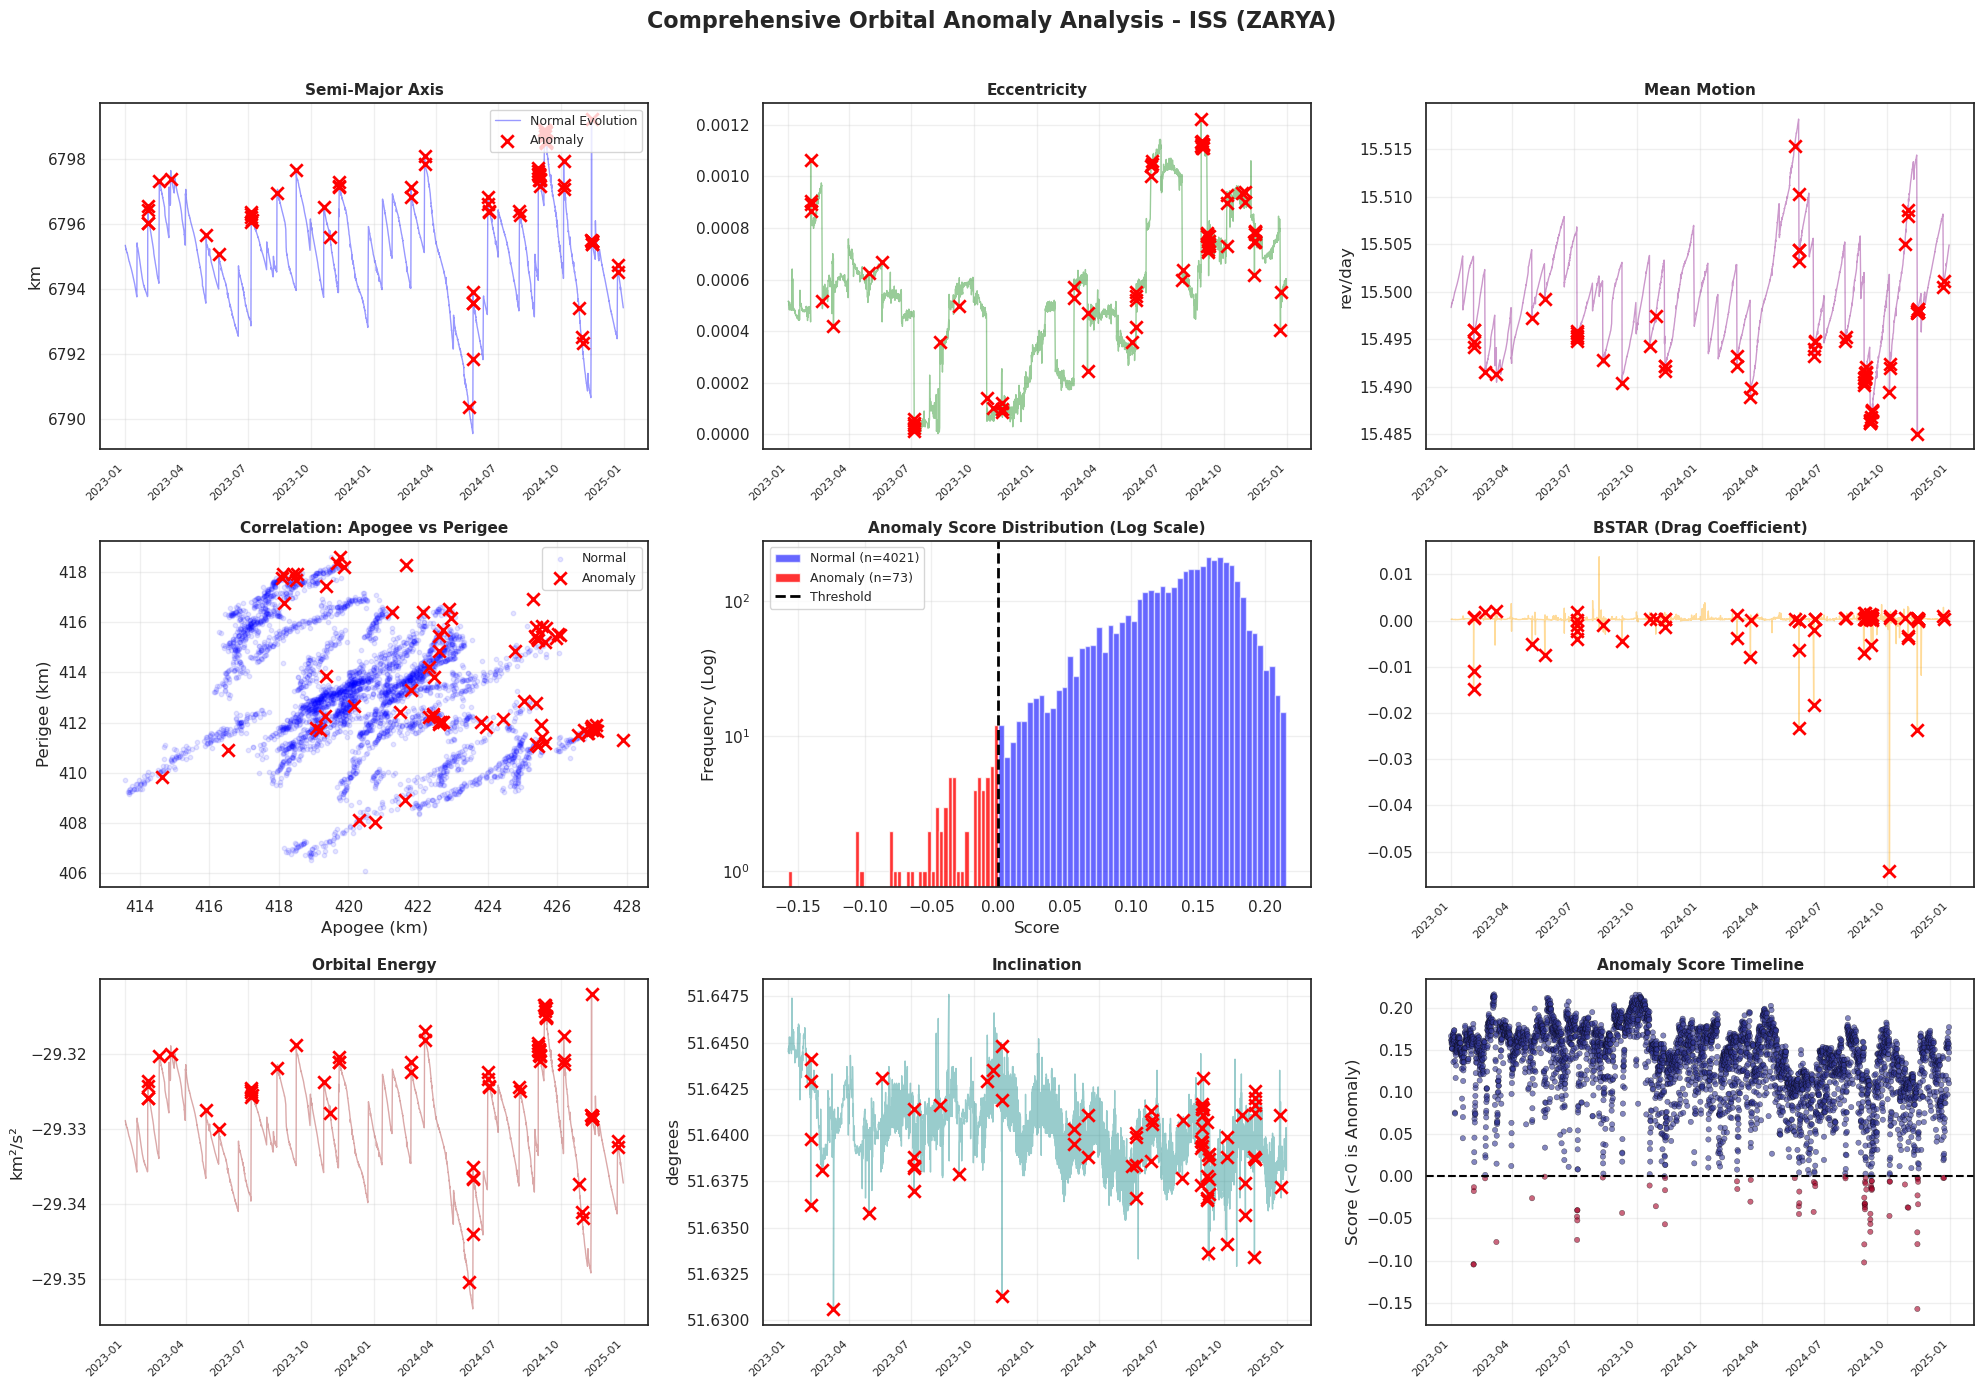

In [54]:
print("="*60)
print("FINAL VISUALIZATION DASHBOARD: ORBITAL ANOMALIES")
print("="*60)

# 1. Prepare Data and Fix Index Mismatch
# --------------------------------------------------
# We start with the full enriched dataframe
df_viz = df_iss_enriched.copy()
df_viz['EPOCH'] = pd.to_datetime(df_viz['EPOCH'])

# Initialize columns for labels and scores
df_viz['ANOMALY_LABEL'] = np.nan
df_viz['ANOMALY_SCORE'] = np.nan

# Assign predictions using the specific temporal masks defined earlier.
# This ensures shapes match perfectly.

# A. Train Period
df_viz.loc[train_mask, 'ANOMALY_LABEL'] = labels_train
df_viz.loc[train_mask, 'ANOMALY_SCORE'] = scores_train

# B. Test Period 2023
df_viz.loc[test_2023_mask, 'ANOMALY_LABEL'] = labels_test_2023
df_viz.loc[test_2023_mask, 'ANOMALY_SCORE'] = scores_test_2023

# C. Test Period 2024
df_viz.loc[test_2024_mask, 'ANOMALY_LABEL'] = labels_test_2024
df_viz.loc[test_2024_mask, 'ANOMALY_SCORE'] = scores_test_2024

# Filter: Remove any rows that didn't get a prediction (if any gaps exist)
df_viz = df_viz.dropna(subset=['ANOMALY_LABEL'])

# Create subsets for plotting
normal_data = df_viz[df_viz['ANOMALY_LABEL'] == 1]
anomalies_df = df_viz[df_viz['ANOMALY_LABEL'] == -1]

print(f"Data prepared. Total Anomalies to visualize: {len(anomalies_df)}")

# 2. Setup Figure
# --------------------------------------------------
fig = plt.figure(figsize=(20, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 3. Helper Function
# --------------------------------------------------
def plot_timeseries_anomaly(ax, col_name, title, unit=None, color='blue'):
    """Standardized plotting function for time series anomalies"""
    ax.plot(df_viz['EPOCH'], df_viz[col_name], color=color, alpha=0.4, lw=1, label='Normal Evolution')
    ax.scatter(anomalies_df['EPOCH'], anomalies_df[col_name], 
               c='red', s=80, marker='x', zorder=5, linewidths=2, label='Anomaly')
    
    ax.set_title(title, fontweight='bold', fontsize=11)
    if unit:
        ax.set_ylabel(unit)
    
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

# 4. Generate Subplots
# --------------------------------------------------

# Row 1: Primary Orbital Elements
ax1 = plt.subplot(3, 3, 1)
plot_timeseries_anomaly(ax1, 'SEMIMAJOR_AXIS', 'Semi-Major Axis', 'km', 'blue')
ax1.legend(loc='upper right', fontsize=9)

ax2 = plt.subplot(3, 3, 2)
plot_timeseries_anomaly(ax2, 'ECCENTRICITY', 'Eccentricity', None, 'green')

ax3 = plt.subplot(3, 3, 3)
plot_timeseries_anomaly(ax3, 'MEAN_MOTION', 'Mean Motion', 'rev/day', 'purple')

# Row 2: Secondary Features & Correlations
ax4 = plt.subplot(3, 3, 4)
ax4.scatter(normal_data['APOGEE'], normal_data['PERIGEE'], c='blue', alpha=0.1, s=10, label='Normal')
ax4.scatter(anomalies_df['APOGEE'], anomalies_df['PERIGEE'], c='red', s=80, marker='x', linewidths=2, label='Anomaly')
ax4.set_title('Correlation: Apogee vs Perigee', fontweight='bold', fontsize=11)
ax4.set_xlabel('Apogee (km)')
ax4.set_ylabel('Perigee (km)')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 3, 5)
# Using 'ANOMALY_SCORE' directly from the dataframe
scores_normal = normal_data['ANOMALY_SCORE']
scores_anom = anomalies_df['ANOMALY_SCORE']

ax5.hist(scores_normal, bins=50, alpha=0.6, color='blue', label=f'Normal (n={len(scores_normal)})', log=True)
ax5.hist(scores_anom, bins=50, alpha=0.8, color='red', label=f'Anomaly (n={len(scores_anom)})', log=True)
ax5.axvline(0, color='black', linestyle='--', linewidth=2, label='Threshold')
ax5.set_title('Anomaly Score Distribution (Log Scale)', fontweight='bold', fontsize=11)
ax5.set_xlabel('Score')
ax5.set_ylabel('Frequency (Log)')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 3, 6)
plot_timeseries_anomaly(ax6, 'BSTAR', 'BSTAR (Drag Coefficient)', None, 'orange')

# Row 3: Energy, Inclination & Score Timeline
ax7 = plt.subplot(3, 3, 7)
plot_timeseries_anomaly(ax7, 'ORBITAL_ENERGY', 'Orbital Energy', 'km²/s²', 'brown')

ax8 = plt.subplot(3, 3, 8)
plot_timeseries_anomaly(ax8, 'INCLINATION', 'Inclination', 'degrees', 'teal')

ax9 = plt.subplot(3, 3, 9)
# Use the mapped Score and Label
sc = ax9.scatter(df_viz['EPOCH'], df_viz['ANOMALY_SCORE'], 
                 c=df_viz['ANOMALY_LABEL'], cmap='RdYlBu', 
                 alpha=0.6, s=15, edgecolors='black', linewidth=0.3)
ax9.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax9.set_title('Anomaly Score Timeline', fontweight='bold', fontsize=11)
ax9.set_ylabel('Score (<0 is Anomaly)')
ax9.grid(True, alpha=0.3)
ax9.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax9.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

# Final Layout
plt.suptitle('Comprehensive Orbital Anomaly Analysis - ISS (ZARYA)', 
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()